## Phylogenetic models in R

### 1. Introduction and resources

This practical should be a refresher on linear models in `R`, before introducing you to a phylogentic least squares model, or a PGLS. Because species that are closely related often share similar traits, this means we can't treat them as statistically independent. However, if we look at how the traits are spread throughout the tree, we can 'control' for this non-independance. 
We'll go into more detail when we run our PGLS. 

### 2. Linear models

For this pratical we'll be working data from the family Anatidae (ducks) to investigate Bergmann’s rule, if there is a relationship between latitude and body mass. 
First, we'll load in the data and inspect it:

In [15]:
# Load the duck latitudinal and bodymass data
duck_data <- read.csv("duck_data.csv",h=T) 

# Check it's been imported
str(duck_data)
head(duck_data)

# Remove any NAs in the data (make sure to check you're not loosing too much data!)
duck_data <- na.omit(duck_data)

'data.frame':	32 obs. of  4 variables:
 $ Birdtree.Name: Factor w/ 32 levels "Phalacrocorax_africanus",..: 20 1 14 22 28 26 18 21 16 6 ...
 $ English.Name : Factor w/ 32 levels "Auckland Shag",..: 21 28 11 20 25 6 14 3 4 22 ...
 $ Midpoint.Lat : num  -22.9 -0.38 -29.2 23.72 42.72 ...
 $ Body.Mass    : num  727 545 762 427 676 ...


,Birdtree.Name,English.Name,Midpoint.Lat,Body.Mass
,<fct>,<fct>,<dbl>,<dbl>
1,Phalacrocorax_melanoleucos,Little Pied Cormorant,-22.90,727.36
2,Phalacrocorax_africanus,Reed Cormorant,-0.38,545.00
3,Phalacrocorax_coronatus,Crowned Cormorant,-29.20,762.19
4,Phalacrocorax_niger,Little Cormorant,23.72,427.00
5,Phalacrocorax_pygmeus,Pygmy Cormorant,42.72,675.97
6,Phalacrocorax_penicillatus,Brandt's Cormorant,32.27,2224.24


The midpoint latitude is the center of the distribution of each species. Because we're interested in the distance from equator, we'll use the `abs()` function to convert our data.

In [ ]:
duck_data$abs_latitude <- abs(duck_data$Midpoint.Lat)

We'll start by looking at the relationship between body mass and latitude using a scatterplot.

In [ ]:
plot(Body_Mass ~ abs_latitude, data = duck_data)

Now there doesn't seem to be much of a relationship at all from our plot. However, to double check we should look at the spread of data for both variables. In particular, body mass is often scaled logarithmically, with lots of small species and fewer large ones. Therefore we might not be seeing the true relationship! 

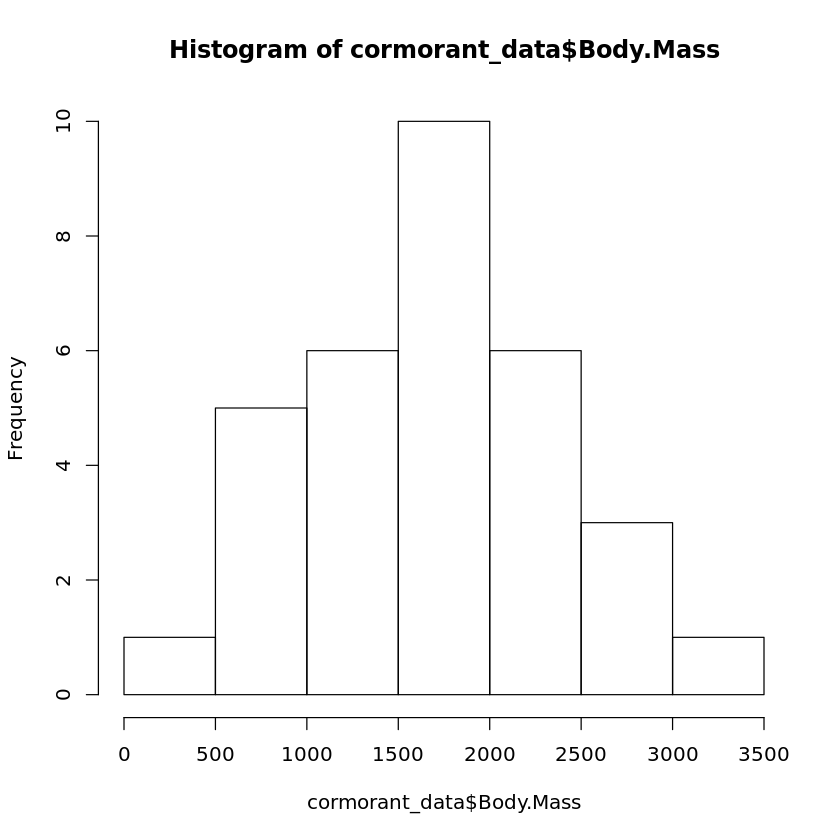

In [18]:
# We'll use a histogram to look at the spread.
hist(duck_data$Body_Mass)

As we suspected! The histogram suggests a log-normal distribution. If we take logs we might see a more normal distribution.

In [ ]:
duck_data$log_BM <- log(duck_data$Body_Mass)
hist(duck_data$log_BM)

Now we've got some data that resembles a more normal distribution! We'll now look at the spread of latitude.

In [ ]:
hist(duck_data$abs_latitude)

Not great, but no obvious signs of left or right skews in the data, so we can work with it. We'll leave it as it is.
Let's look at the new relationship between the two variables:

In [ ]:
plot(log_BM ~ abs_latitude, data = duck_data)

Now we're starting to see some kind of relationship! There's a lot of spread to the points, but we can see the smallest species at the lowest latitudes, and the largest at the highest. To really find out if there's a relationship we can test our hypothesis with a linear model. 

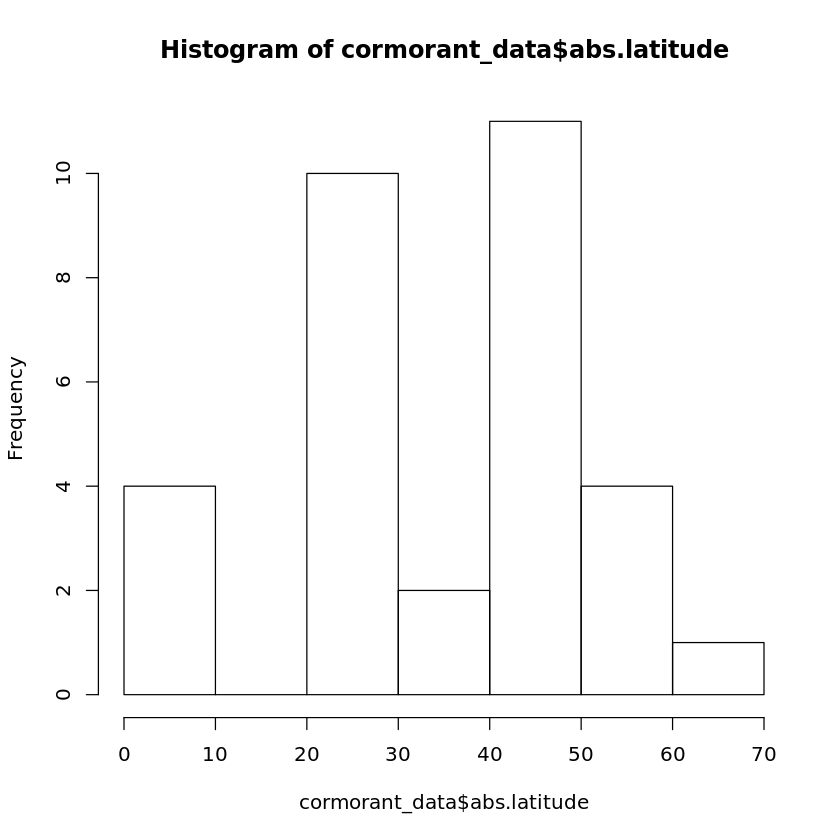

In [20]:
# Run a basic linear model
duck_model <- lm(log_BM ~ abs_latitude, data = duck_data)

# Inspect our linear model
summary(duck_model)

Now we can investigate if there is a relationship. There's quite a lot going on with our output, but for this practical we'll focus on just a few main things:

`Coefficients`: This tells us about our predictors in the model. In this one there's 2, the intercept, and latitude.  We'll break each section down further.

`Estimate`: The estimate of our coefficients tells us what value it should have. For the intercept this will be the point that that crosses across the y axis. For latitude, this will be the gradient of the relationship between latitude and body mass. 

`Std. Error`: This shows how much faith we have in our estimates. We're fairly certain that our estimates will fall within the range: Estimate +- Standard Error. 

`t value`: This is our test statistic. In a linear model we're testing if each of our estimate values are significantly different from zero. If our estimate and standard error don't overlap zero, it normally means they are significant. 

`Pr(>|t|)`: This is our p values for each predictor. This is calculated by weighing up the degrees of freedom against our test statistic, and tells us what the chance is that we observed the same pattern in our data given that there was no relationship, i.e. the null hypothesis is true. 

`Multiple R-squared`: This tells us how much of the variation in our response variable is explained by our model. Large values are better, but often in macro-evolution we see smaller values. Because traits at a macro scale are often driven by multiple selection pressures, which may sometimes be species-specific, we typically explain less variation than smaller more targeted studies. 

`Adjusted R squared`: This also explains the varition in response, but penalises us for including more predictors. This reduces the chances of over-fitting models with lots of predictors that don't contribute much. This is the R-squared that tends to be reported in publications. 

`F Statistc` & `DF` & `p-value`: The last line reports the overall results of our model. When reporting the statistic tests in the results section, we tend to quote these values for the model. This test is comparing our model line against a flat horizontal line at the mean body mass. Simply put, does our latitude model explain more of the variance in body mass than the mean. This is easiest to explain with a quick example:

In [ ]:
# Create some data
x <- c(12,18,21, 36, 44, 54, 59)
y <- c(2, 4, 7, 11, 12, 14, 15)

# Create a linear model based only on the mean of body mass
mean <- lm(y ~ 1)

# Create a linear model where x predicts y
linear <- lm(y ~ x)

# Create a plot window with one row and two columns
par(mfrow =c (1,2))

# Plot our data for the mean
plot(x,y, xlim = c(0,60), ylim =c(0,15), main = "Mean") 

# Add the line of the linear model based on the mean
abline(mean, col="red")

# Add in lines to show the distance from each point to mean line (the residuals)
segments(x, y, x, predict(mean))

# Do the same to plot our data with the linear model based on x
plot(x,y, xlim = c(0,60), ylim =c(0,15), main = "Linear")  
abline(linear, col="blue")
segments(x, y, x, predict(linear))

From the plots we can see that the blue linear model line passes closer to all of our data points than simply using the mean line. The black lines from our data points to the linear model are the residual variation left over once we've accounted for x. This is often referred to as the residuals.

The F statistic in our summary output is testing if there is a siginificant difference between the residuals from using our mean line against using our linear model instead. This is weighed up against the number of degrees of freedom to calculate our p-value. 

Degrees of freedom can be a tricky subject but are actually quite simple to understand. They are calculated from the number of independent data points in your model, minus the number of predictors. This is to prevent models that over-fit the data. So models with lots of data points have high degrees of freedom which means we need lower F statistic values to be certain of our model. For models with few data points it depends on the number of predictors. If there's few predictors, like in our model, that means that we can accept lower F statistics. We can be more confident in our relationship if we used fewer predictors to describe it. If we use lots of predictors, we can be less certain in our model, because each predictor may explain some of the variation just by chance. Therefore we need a higher F statistic. When you report your models, report both the degrees of freedom and the F statistic alongside your p-value for the whole model. 

Now that we understand a bit more about our summary report, lets look at it again to investigate the relationship between body mass and latitude. 

In [ ]:
summary(duck_model)

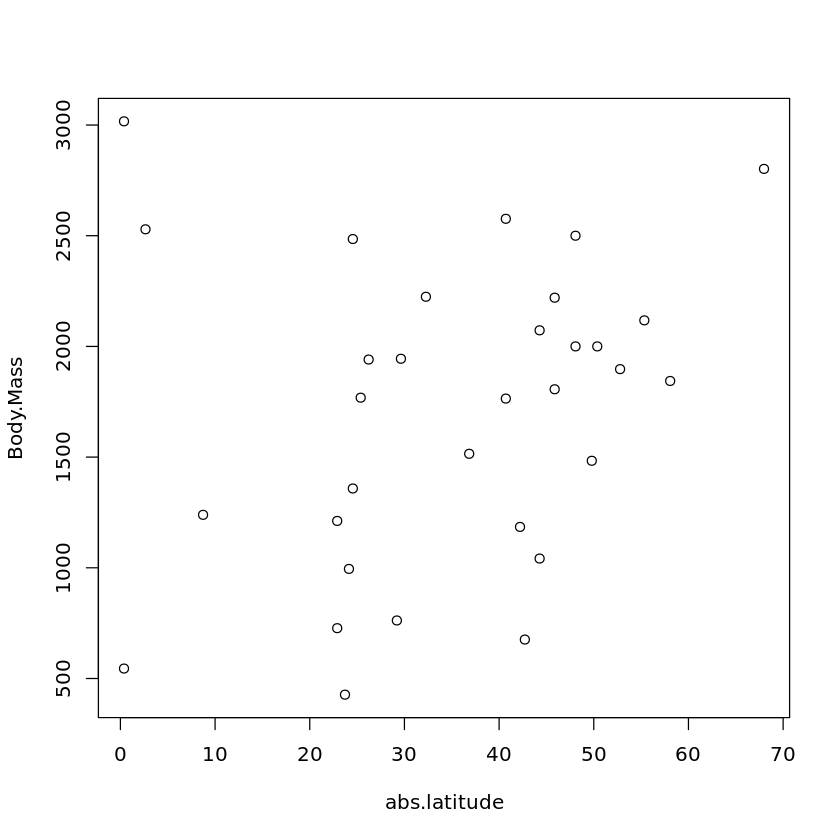

In [22]:
# A scatter plot.
plot(Body.Mass~abs.latitude, duck_data)

It looks like there could be some relationship there, but it's hard to tell. Therefore we'll run a linear model to check.

In [24]:
# We separate our dependant variables from predictors using a tilda ~
cormorant_lm <- lm(Body.Mass~abs.latitude, data=duck_data)
summary(cormorant_lm)


Call:
lm(formula = Body.Mass ~ abs.latitude, data = cormorant_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1182.46  -440.54    14.15   334.32  1617.23 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1395.972    277.969   5.022 2.19e-05 ***
abs.latitude    9.000      7.217   1.247    0.222    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 679.4 on 30 degrees of freedom
Multiple R-squared:  0.04929,	Adjusted R-squared:  0.0176 
F-statistic: 1.555 on 1 and 30 DF,  p-value: 0.222


In [26]:
library(ape)
library(caper)
library(phytools)

Loading required package: MASS

Loading required package: mvtnorm

Loading required package: maps



In [8]:
cormorant_lm <- lm(Body.mass~abs(Latitude), data=na.omit(turds))
summary(cormorant_lm)


Call:
lm(formula = Body.mass ~ abs(Latitude), data = na.omit(turds))

Residuals:
    Min      1Q  Median      3Q     Max 
-52.388 -15.918  -0.481  15.634 102.894 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    65.1502     3.3732   19.31   <2e-16 ***
abs(Latitude)   0.1485     0.1303    1.14    0.256    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 27.97 on 159 degrees of freedom
Multiple R-squared:  0.008107,	Adjusted R-squared:  0.001869 
F-statistic:   1.3 on 1 and 159 DF,  p-value: 0.256


In [9]:
turds <- read.csv("turd_test.csv")

In [4]:
head(turds)
str(turds)

,Jetz_Name,English.Name,Diet,Body.mass,Latitude
,<fct>,<fct>,<fct>,<dbl>,<dbl>
1,Chaetops frenatus,Cape Rock-jumper,IN,54.99,-33.17
2,Chaetops aurantius,Drakensberg Rockjumper,IN,54.10,-30.51
3,Neocossyphus rufus,Red-tailed Ant-thrush,IN,65.90,0.38
4,Neocossyphus poensis,White-tailed Ant-thrush,IN,51.78,0.38
5,Stizorhina fraseri,Rufous Flycatcher-thrush,IN,35.70,-1.89
6,Stizorhina finschi,Finsch's Rufous Thrush,IN,36.99,6.06


'data.frame':	173 obs. of  5 variables:
 $ Jetz_Name   : Factor w/ 173 levels "Alethe choloensis",..: 24 23 57 56 64 63 47 54 51 48 ...
 $ English.Name: Factor w/ 173 levels "Abyssinian Ground-thrush",..: 28 45 114 169 119 57 144 130 80 23 ...
 $ Diet        : Factor w/ 2 levels "FR","IN": 2 2 2 2 2 2 1 1 2 2 ...
 $ Body.mass   : num  55 54.1 65.9 51.8 35.7 ...
 $ Latitude    : num  -33.17 -30.51 0.38 0.38 -1.89 ...


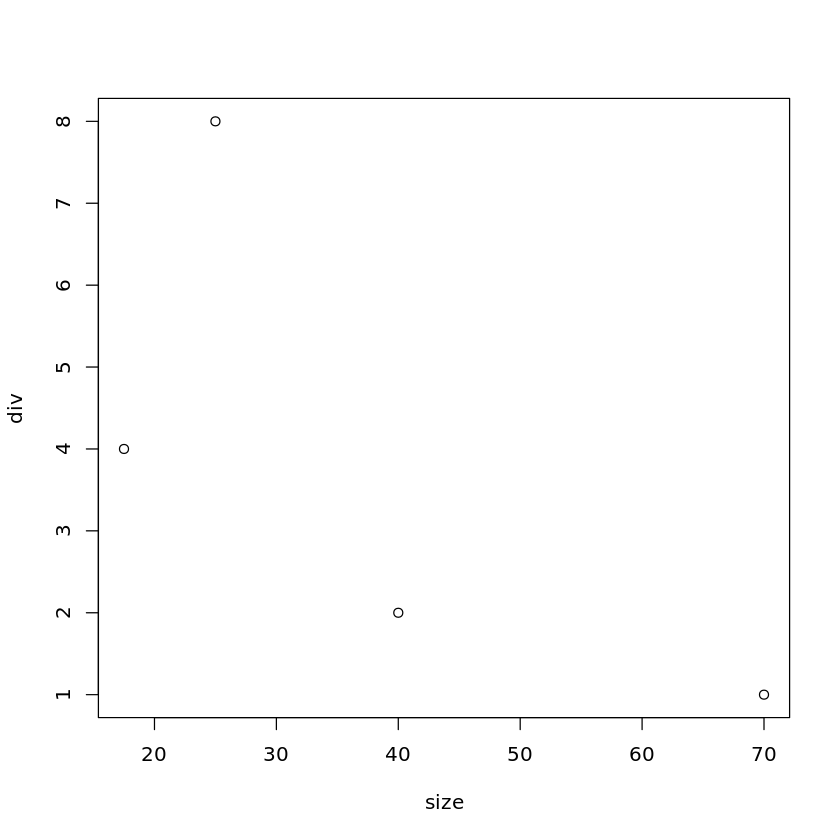

In [1]:
# These are the body sizes for the species in each clade
bs_clade1 <- c(10,15,20,25)
bs_clade2 <- c(30,50)
bs_clade3 <- c(5,10,25,30,50,55,10,15)
bs_clade4 <- c(70) 

# we calculate the mean body size for each clade
bs1_mean< - mean(bs_clade1)
bs2 <- mean(bs_clade2)
bs3 <- mean(bs_clade3)
bs4 <- mean(bs_clade4)
size <- c(bs1,bs2,bs3,bs4) # a vector of mean body sizes 
div <- c(4,2,8,1) # a vector of species richness

plot(size, div) # visualise it

In [4]:
library(ape)
libary(caper)
library(phytools)

ERROR: Error in library(ape): there is no package called ‘ape’


In [ ]:
comp_corm

In [31]:
corm <- pgls(Body.Mass~abs.latitude, data=cormorant, lambda="ML")
summary(corm)


Call:
pgls(formula = Body.Mass ~ abs.latitude, data = cormorant, lambda = "ML")

Residuals:
    Min      1Q  Median      3Q     Max 
-350.67  -23.22   50.54  112.66  381.79 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [ ML]  : 0.000
   lower bound : 0.000, p = 1    
   upper bound : 1.000, p = < 2.22e-16
   95.0% CI   : (NA, 0.458)
delta  [Fix]  : 1.000

Coefficients:
              Estimate Std. Error t value  Pr(>|t|)    
(Intercept)  1395.9725   277.9692  5.0220 2.189e-05 ***
abs.latitude    9.0004     7.2168  1.2472     0.222    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 158.1 on 30 degrees of freedom
Multiple R-squared: 0.04929,	Adjusted R-squared: 0.0176 
F-statistic: 1.555 on 1 and 30 DF,  p-value: 0.222 

In [28]:
random.tree<-sample(tree,size=1)[[1]] #this selects one tree at random from the tree file
cormorant<-comparative.data(random.tree,cormorant_data,Birdtree.Name) 

## PGLS

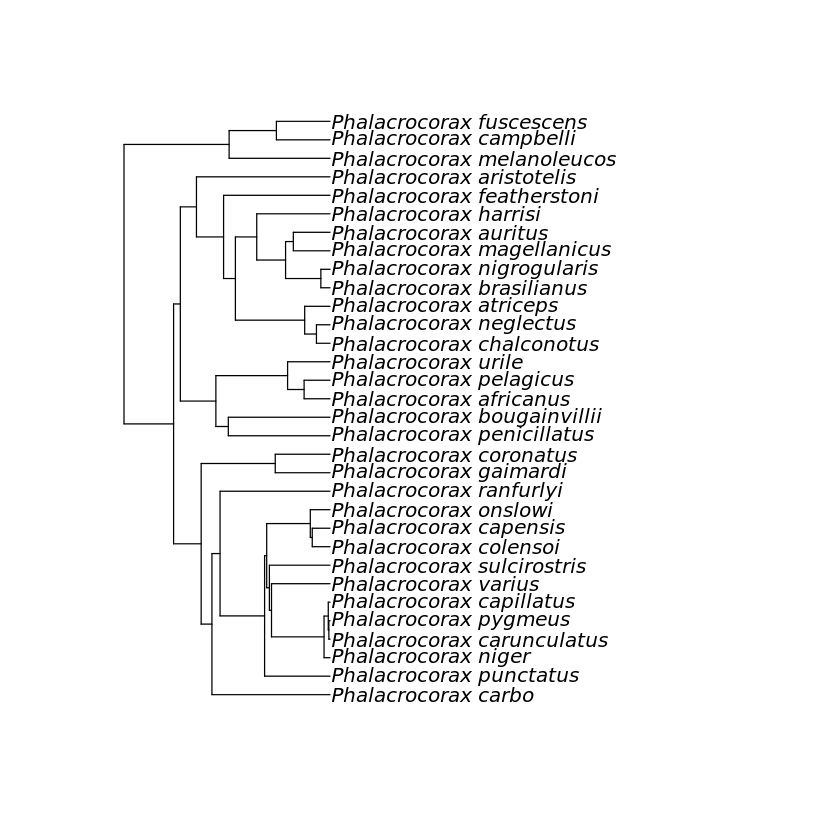

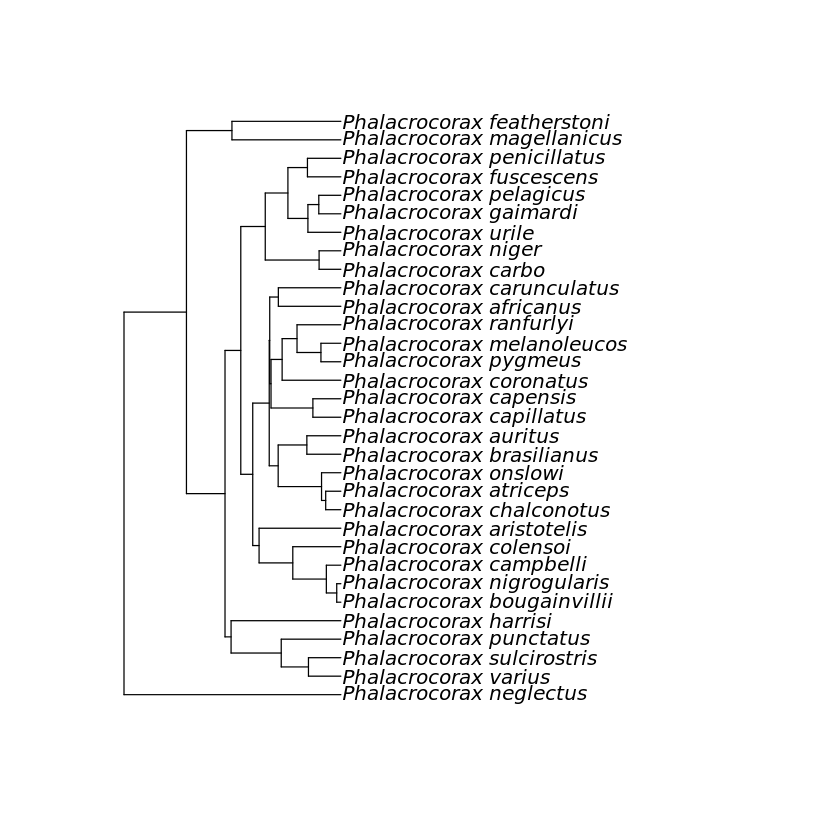

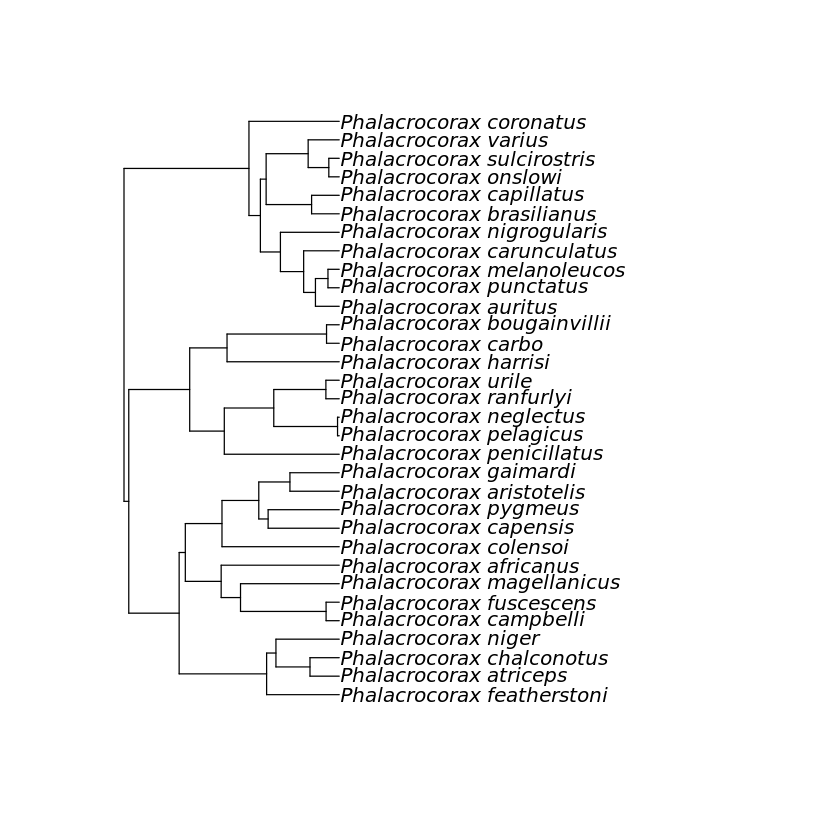

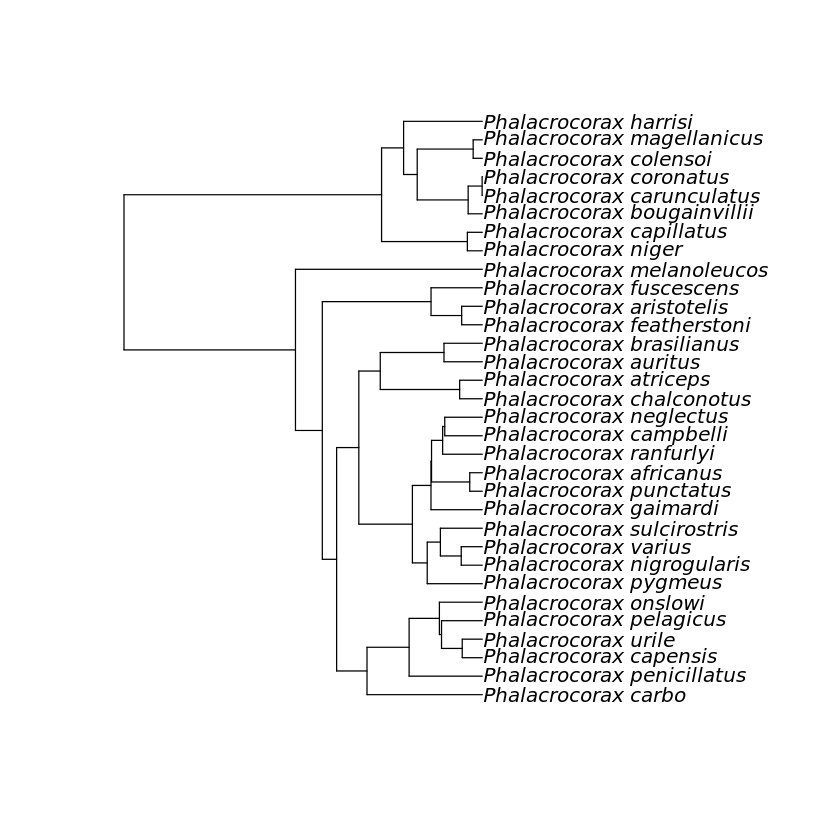

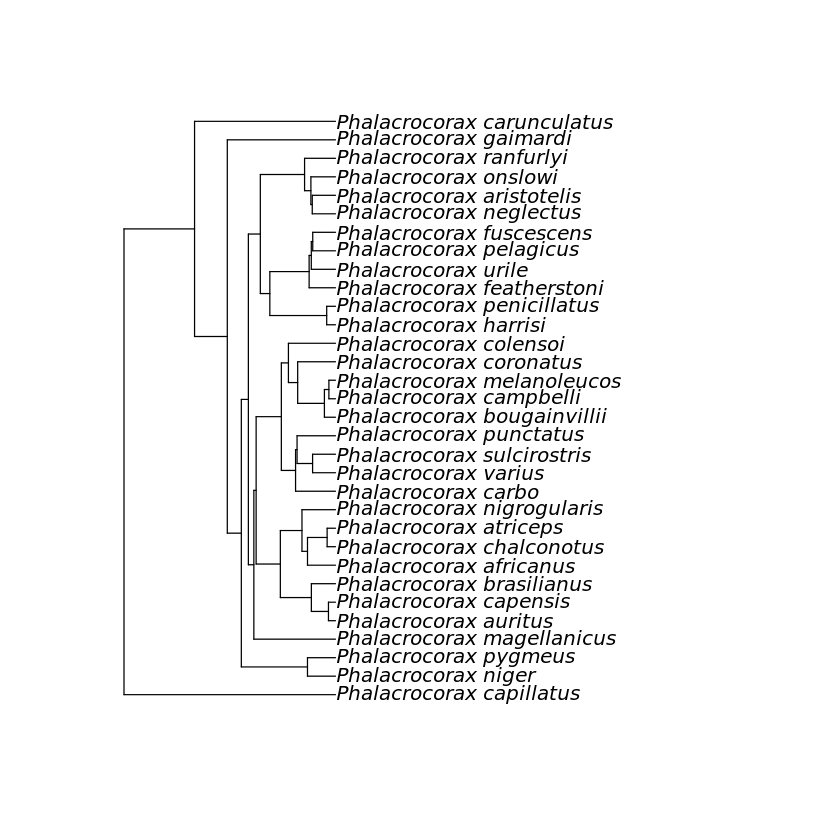

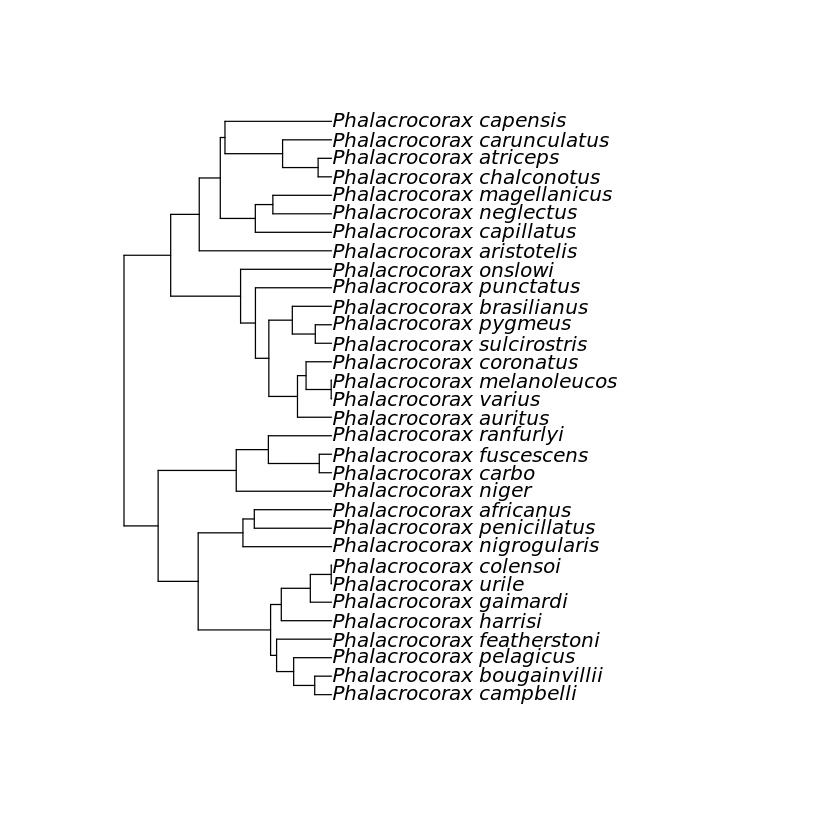

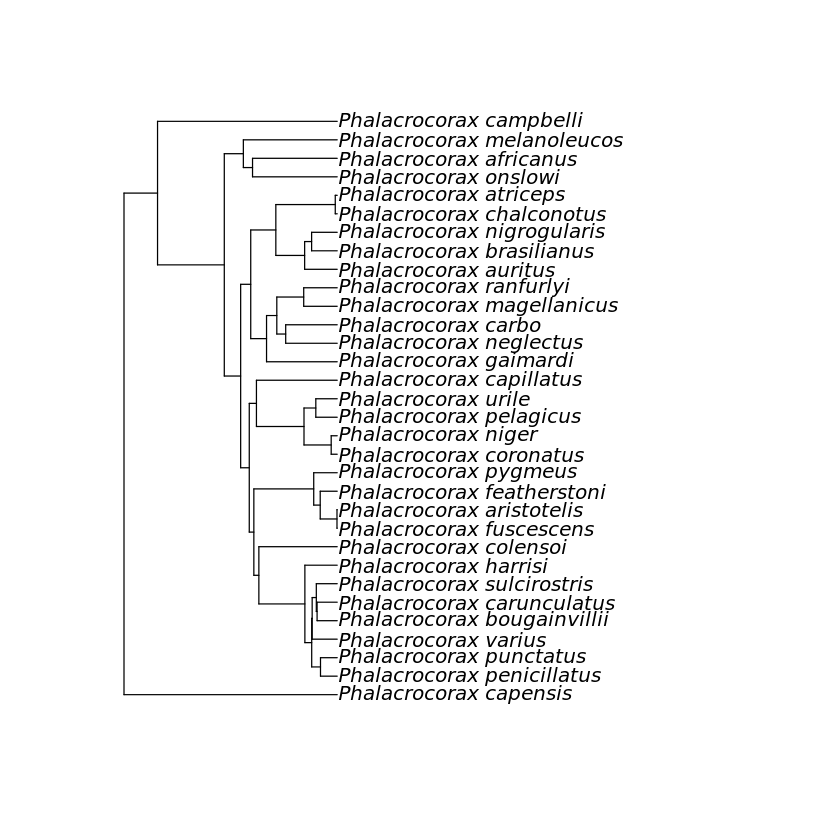

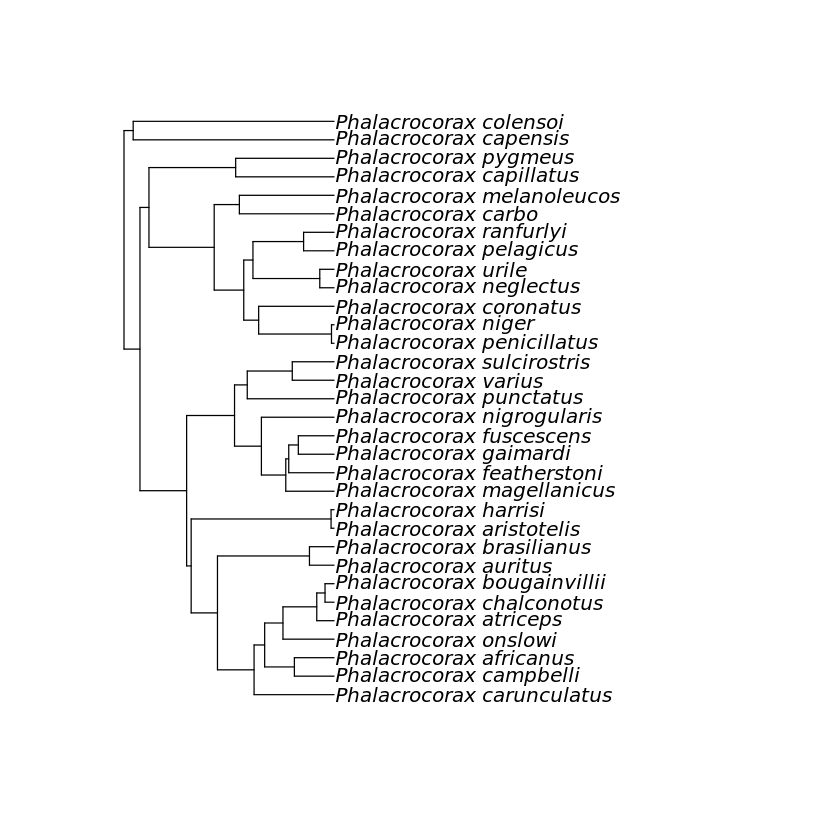

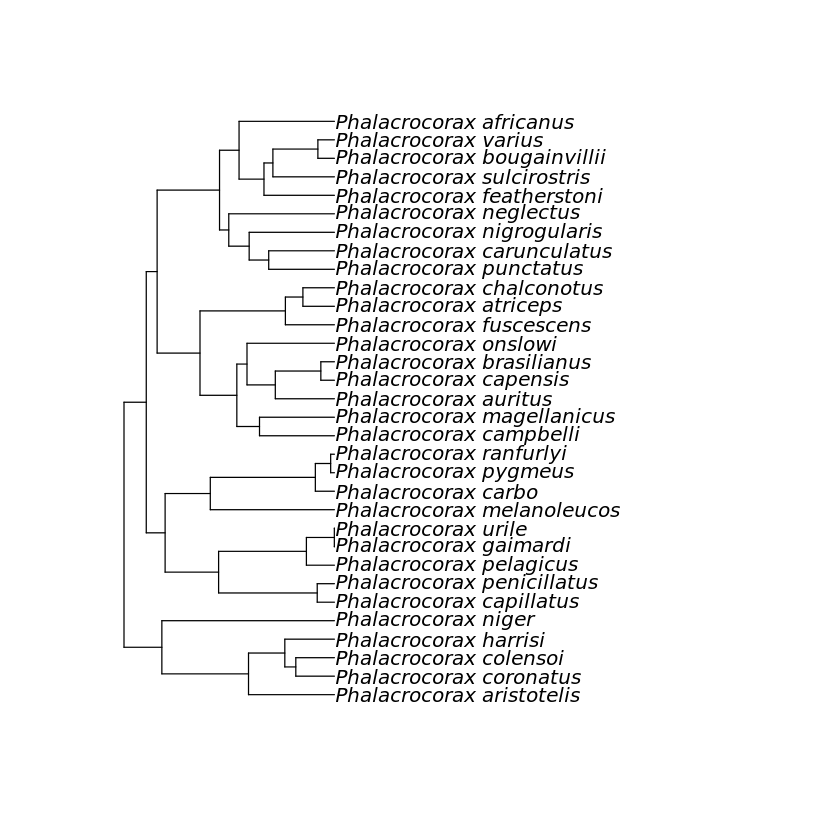

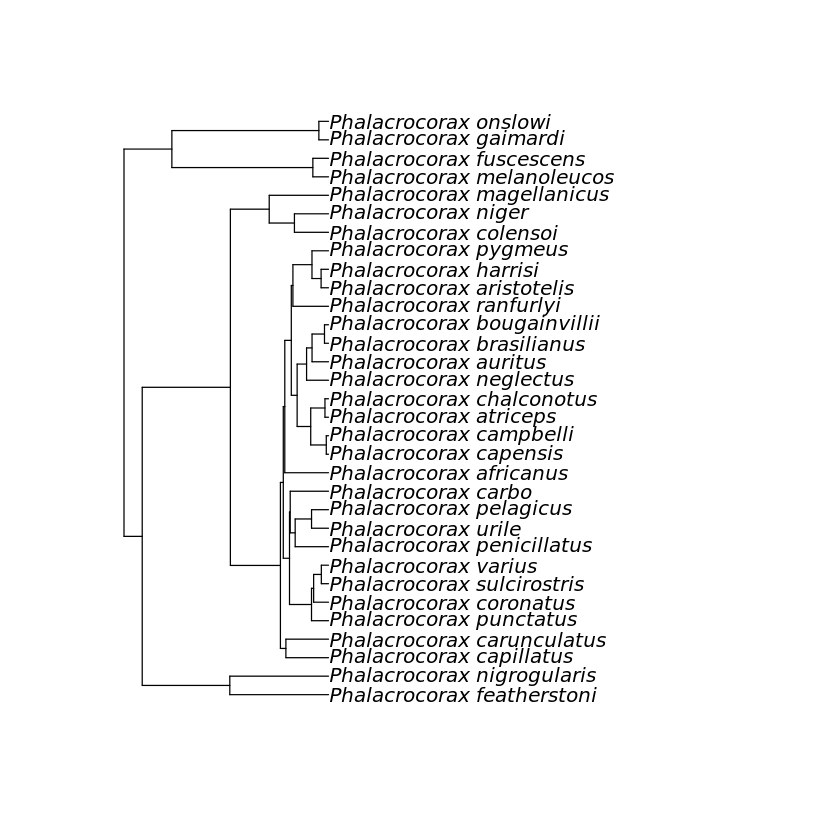

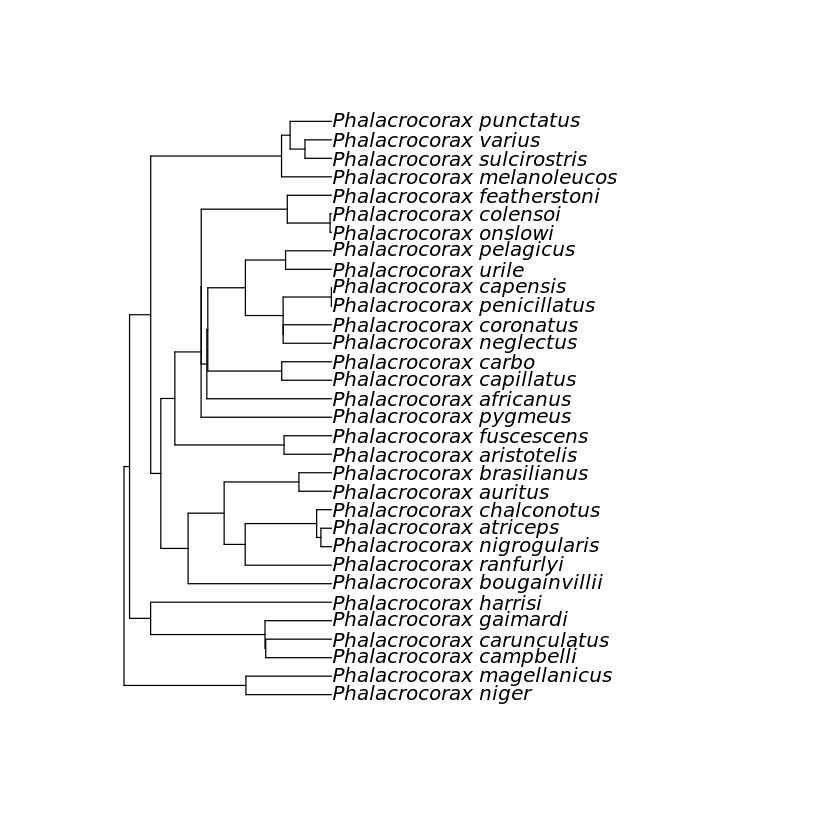

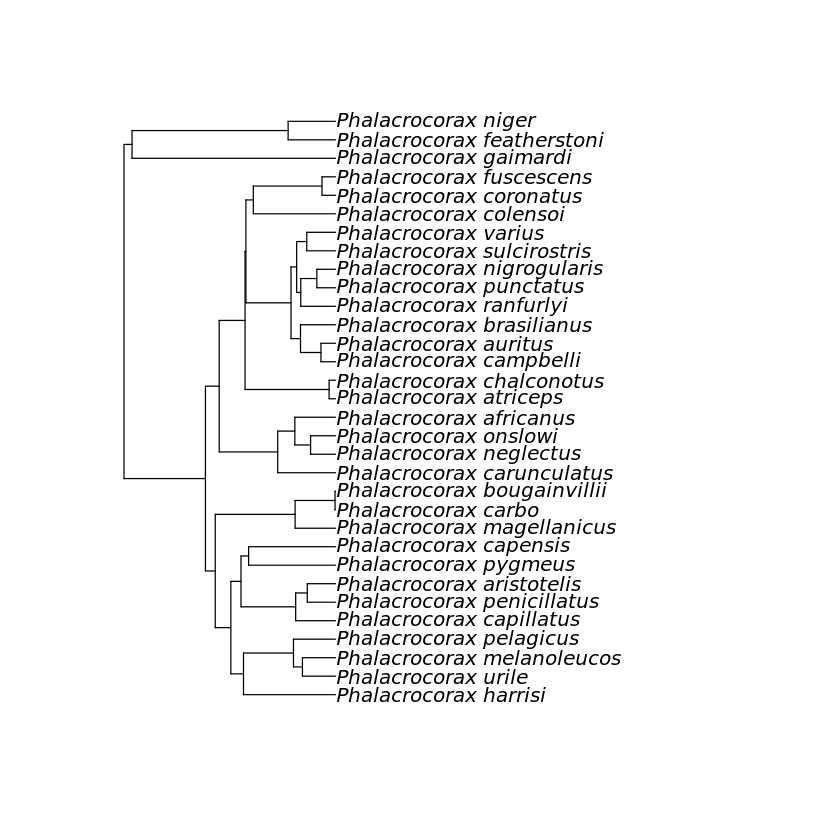

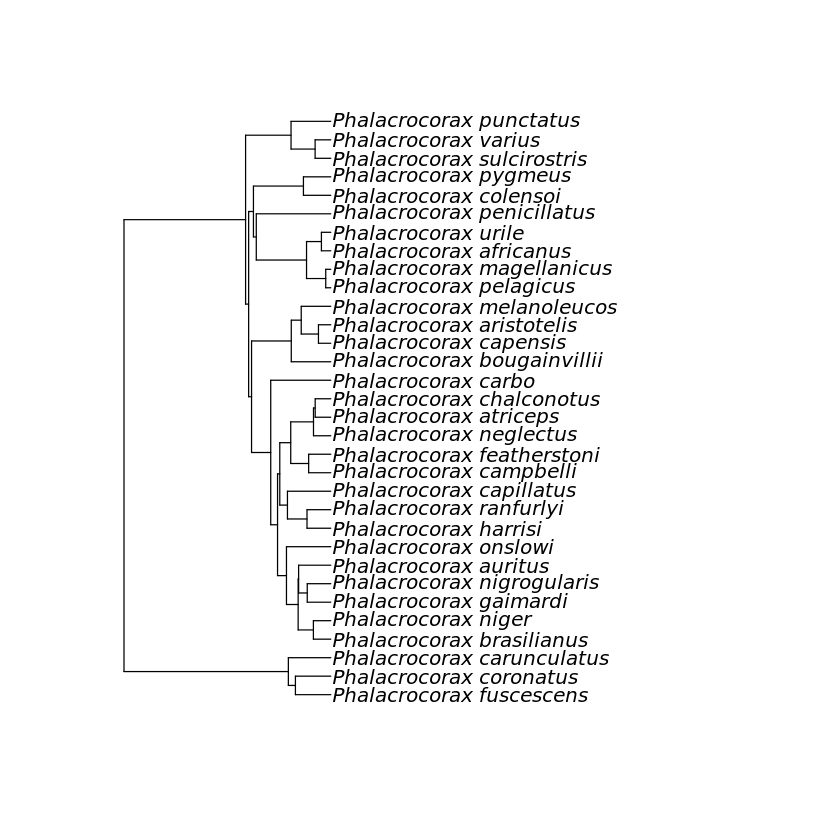

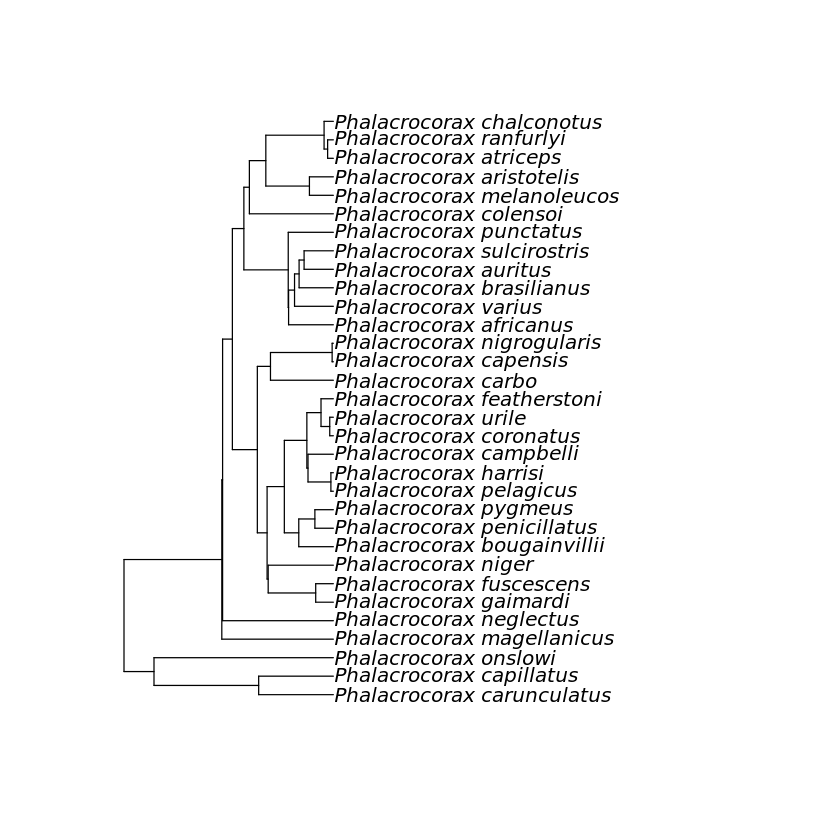

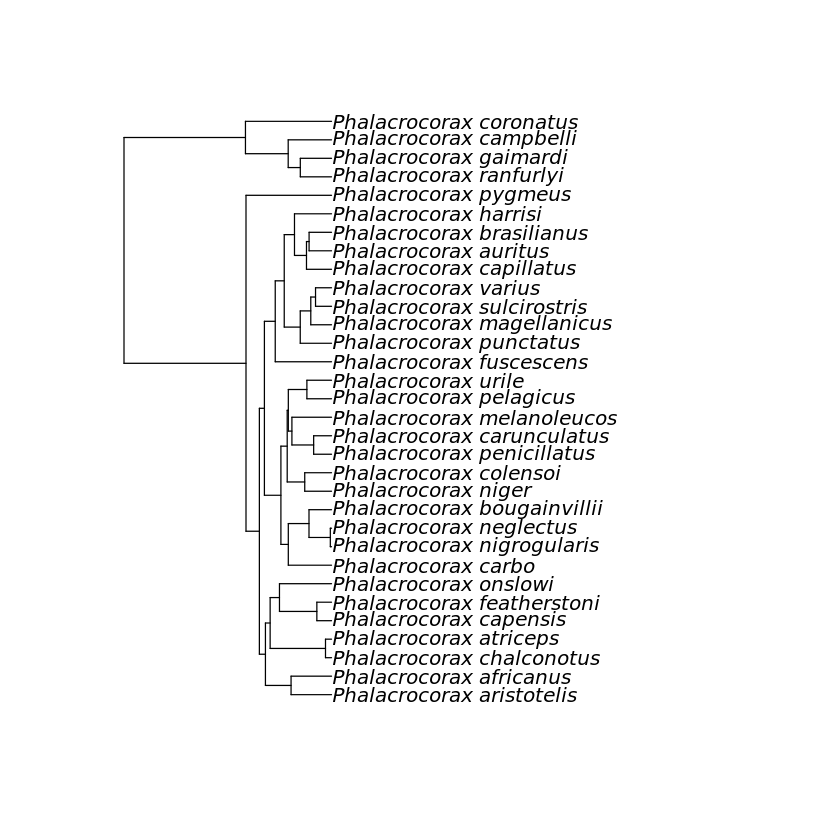

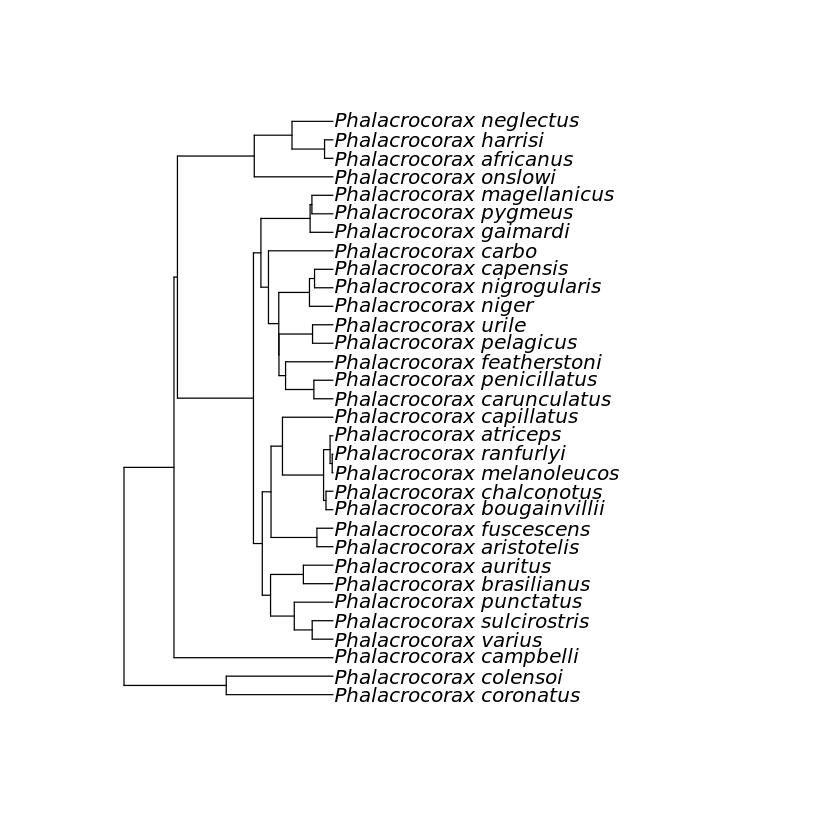

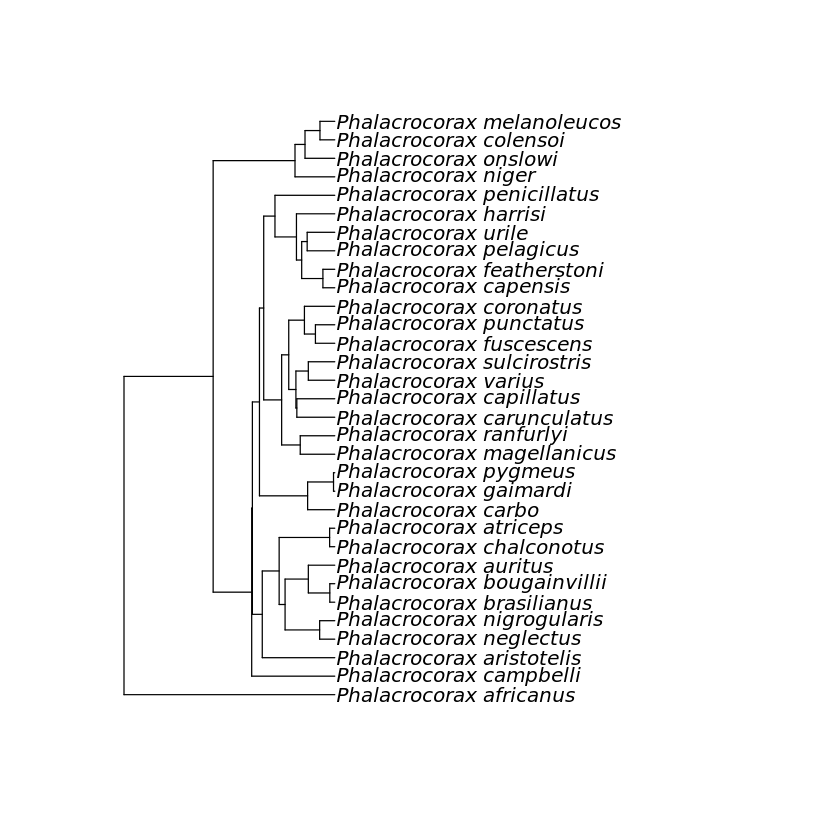

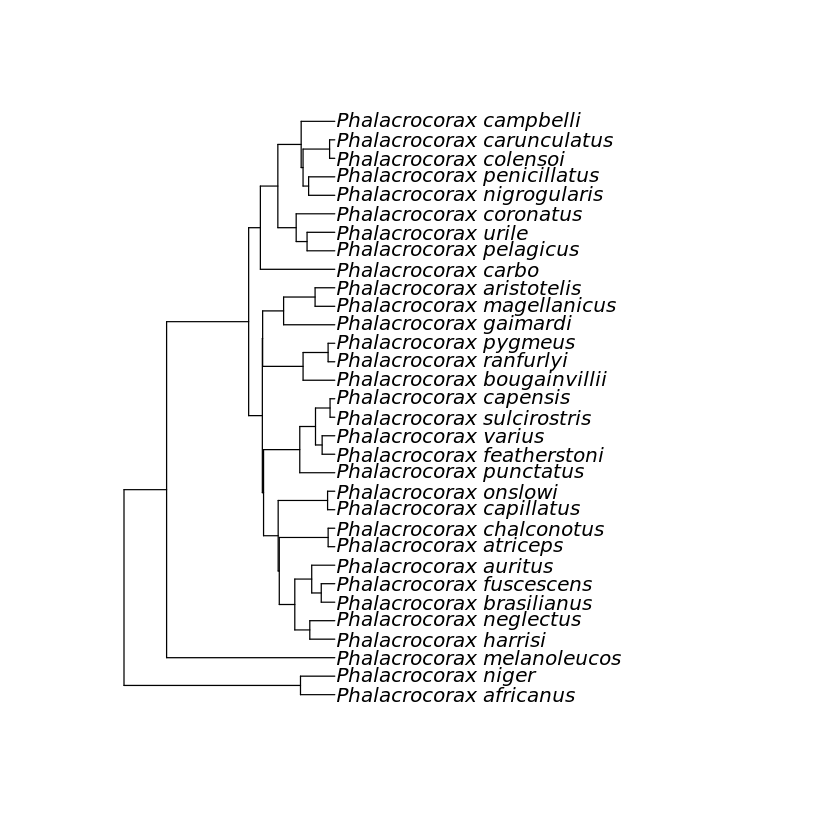

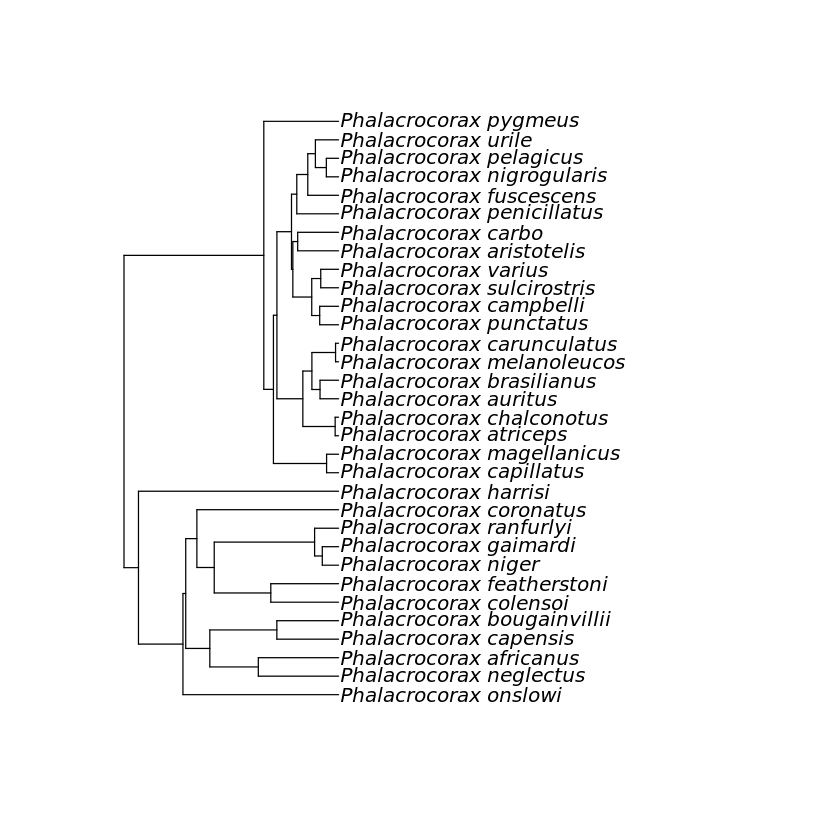

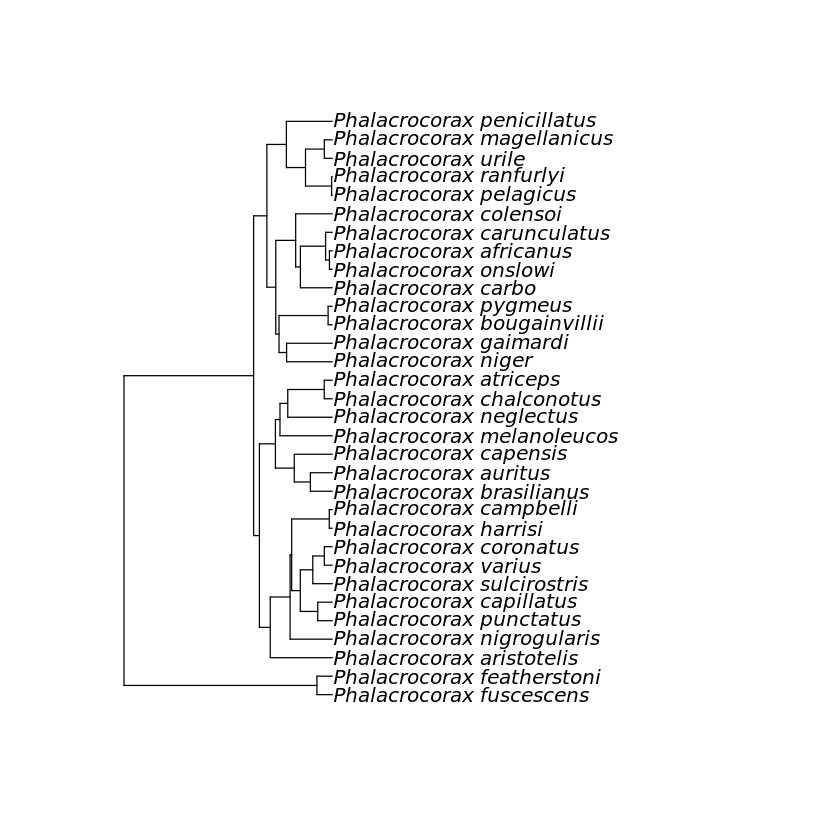

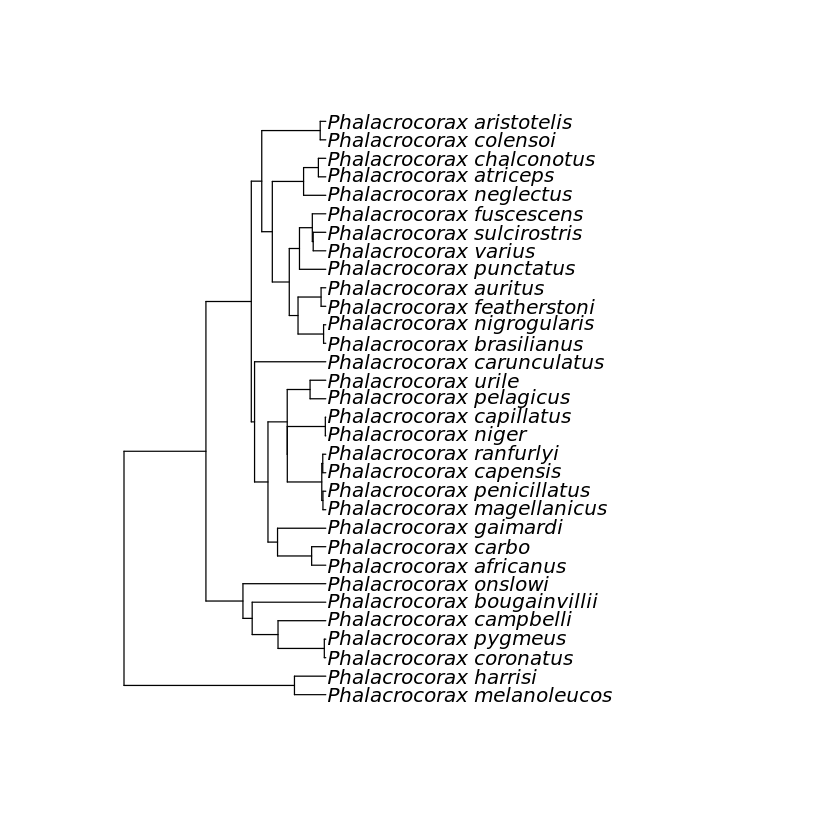

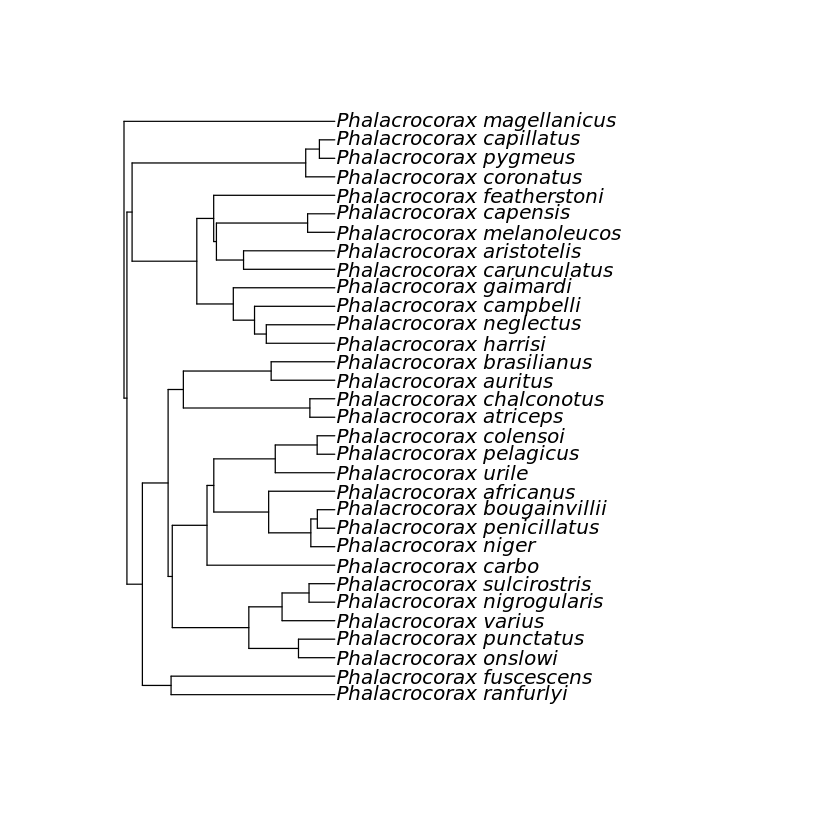

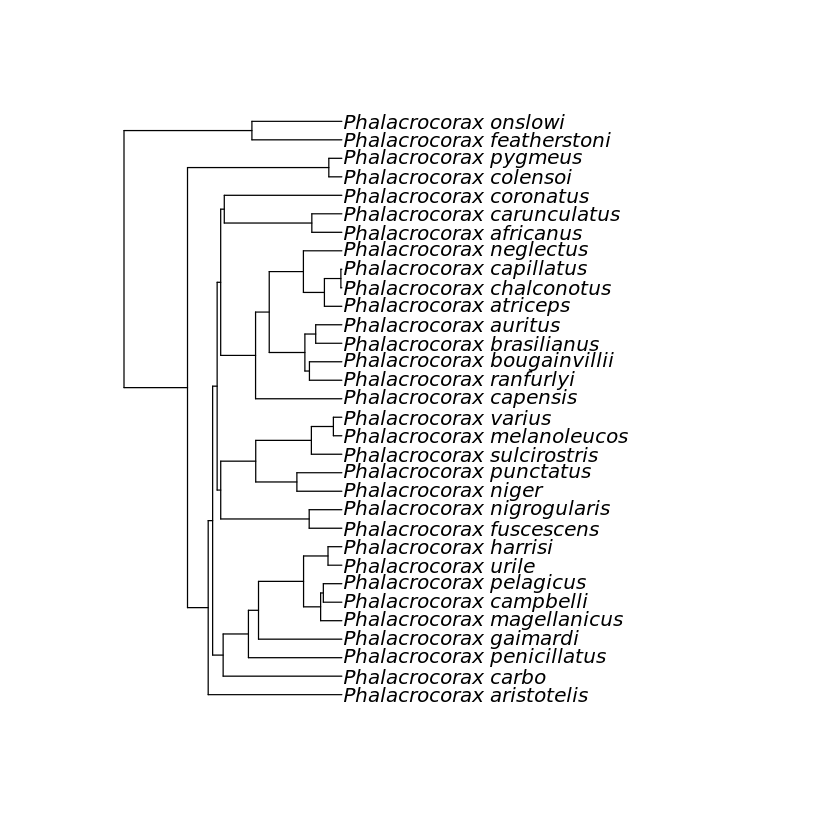

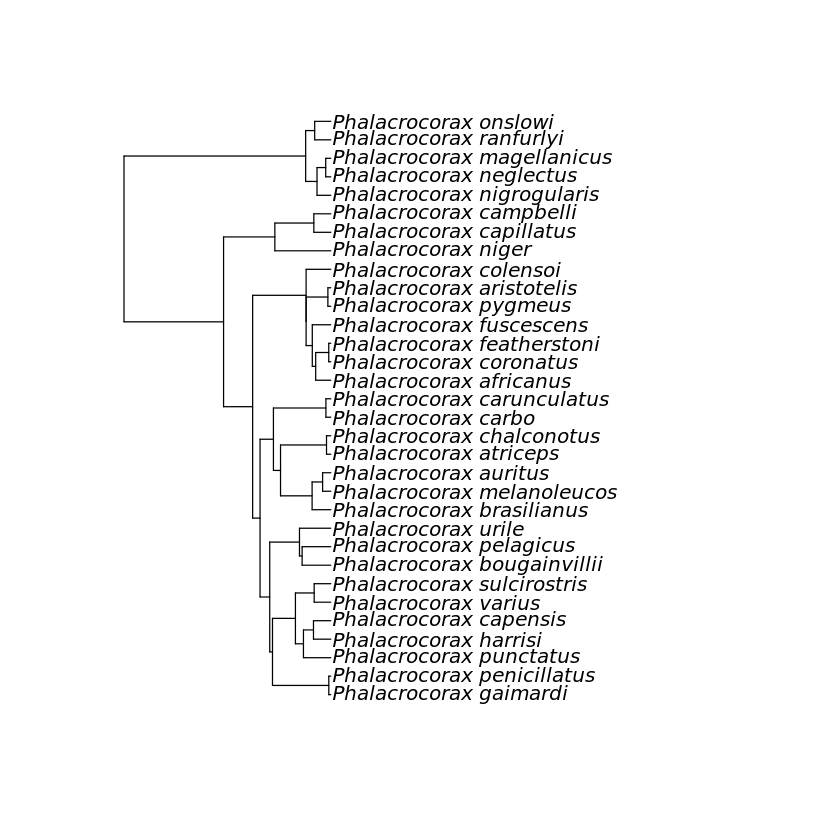

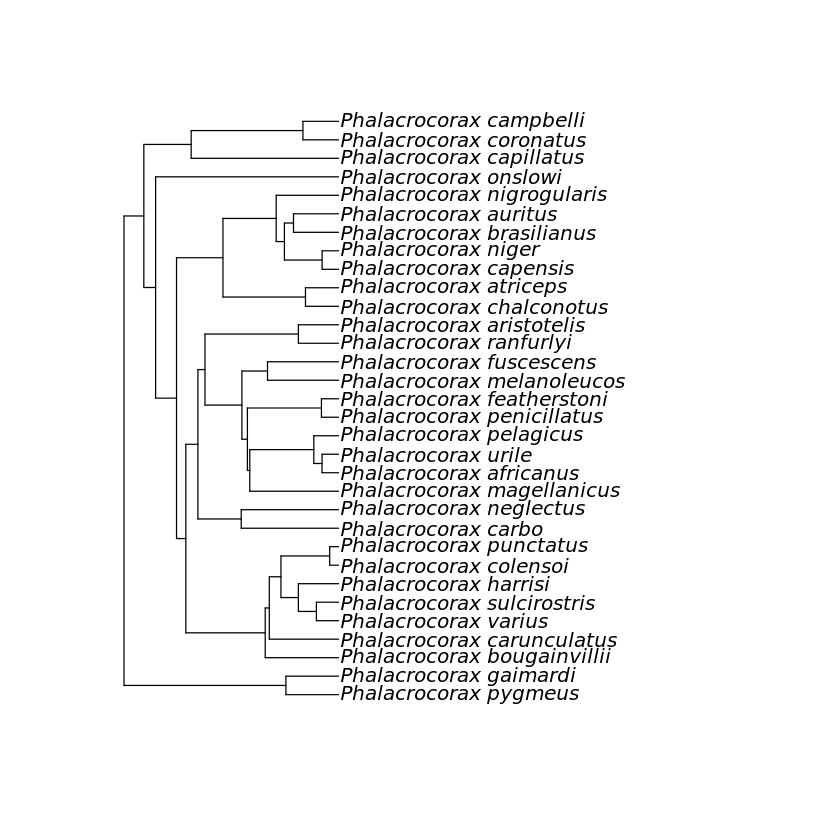

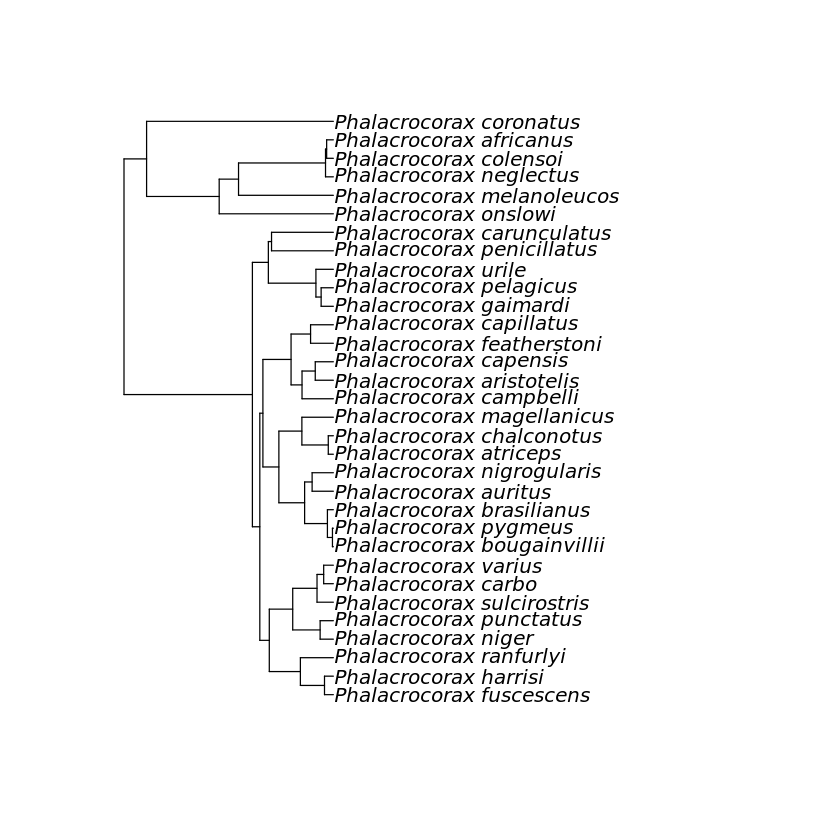

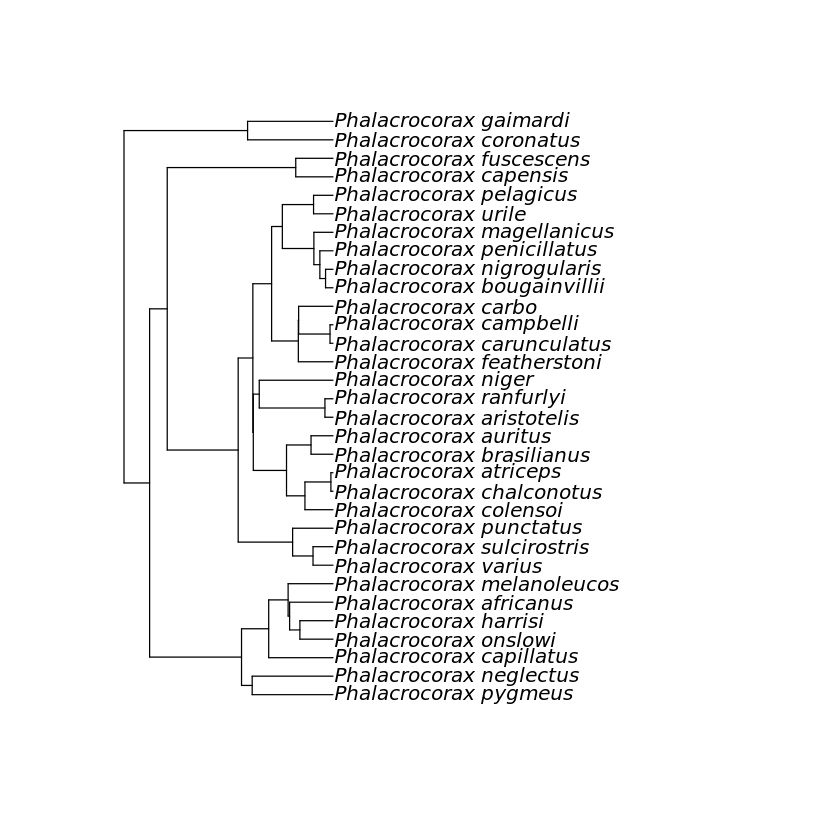

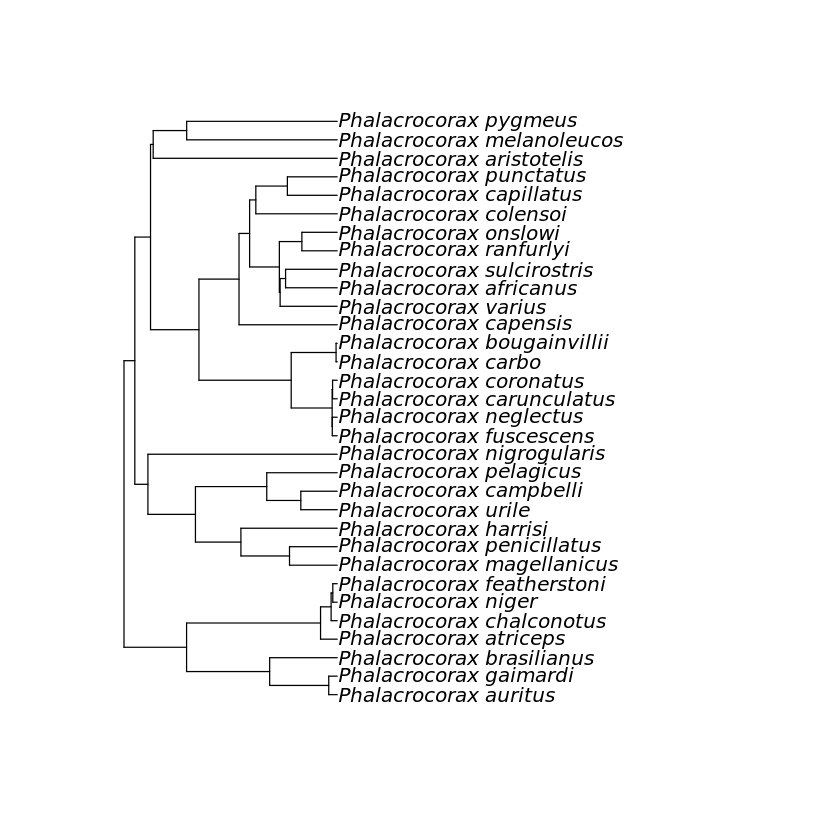

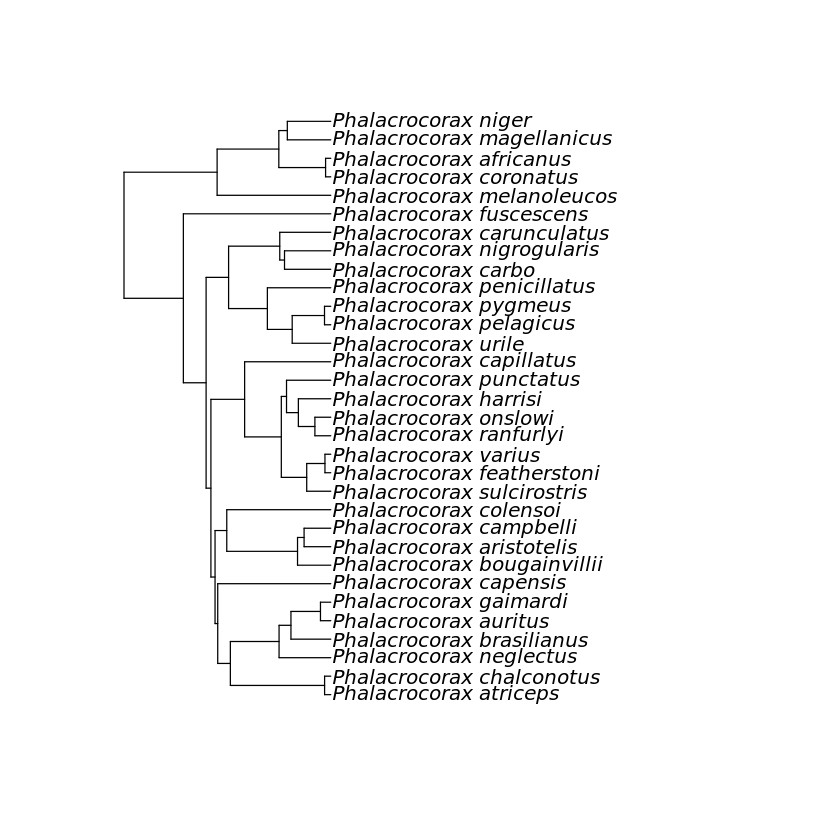

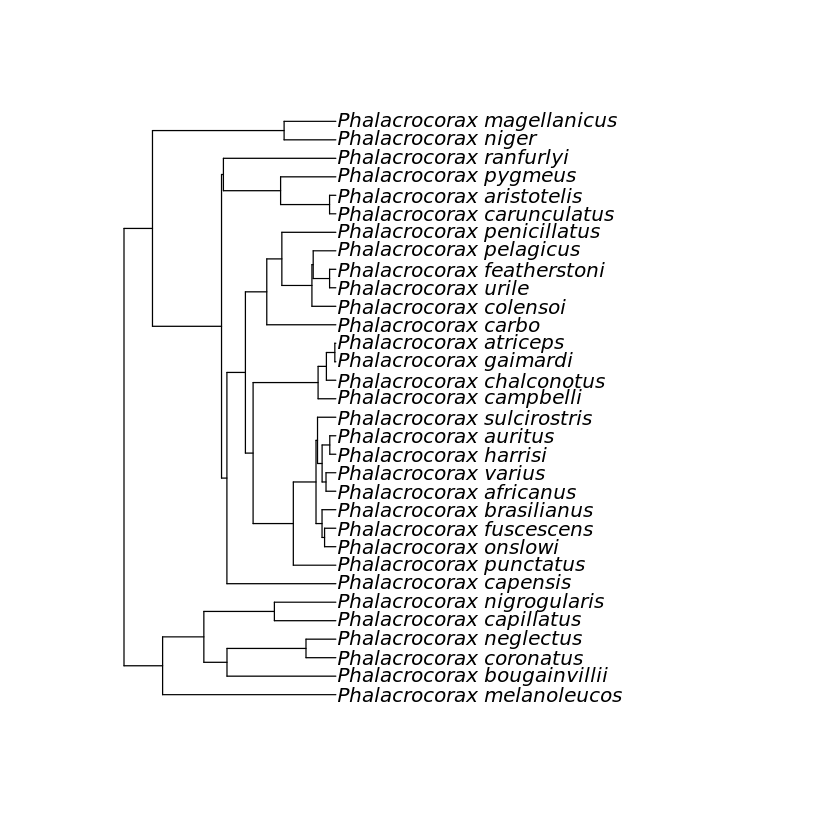

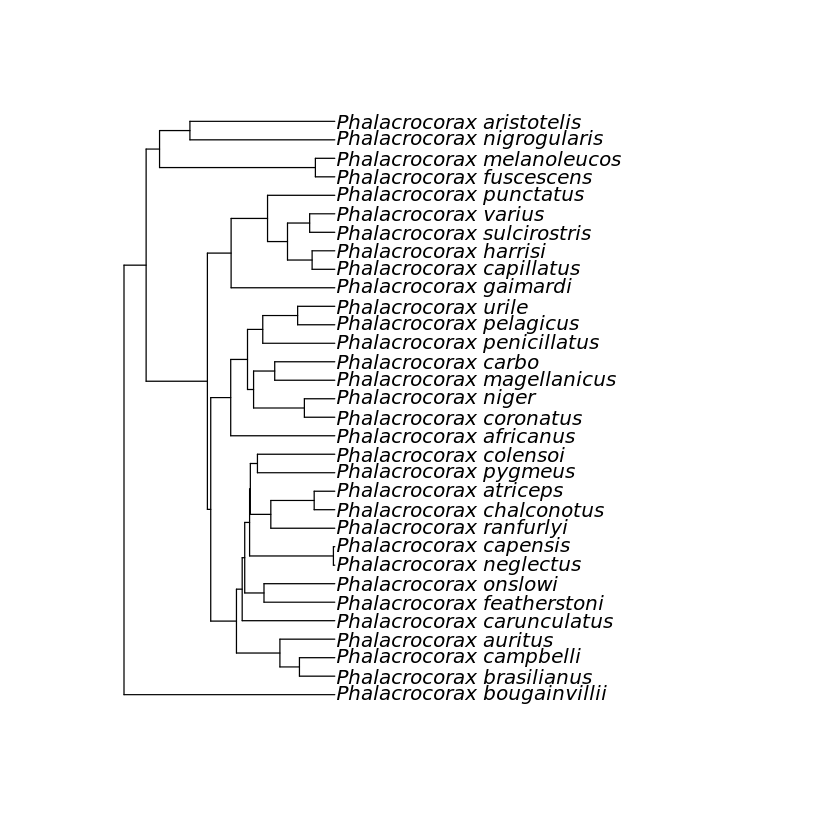

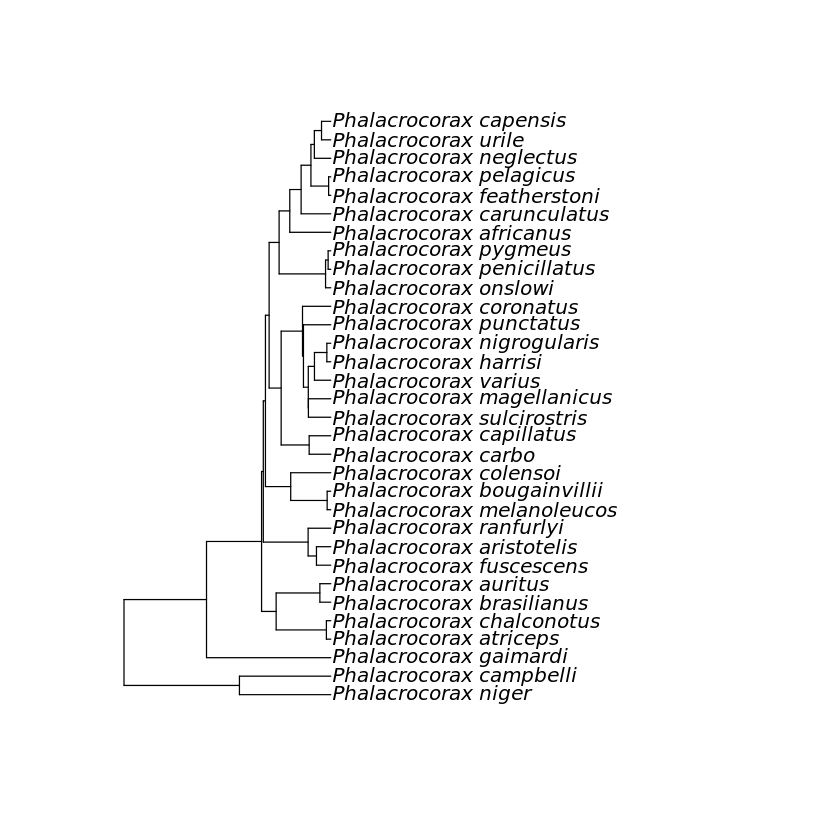

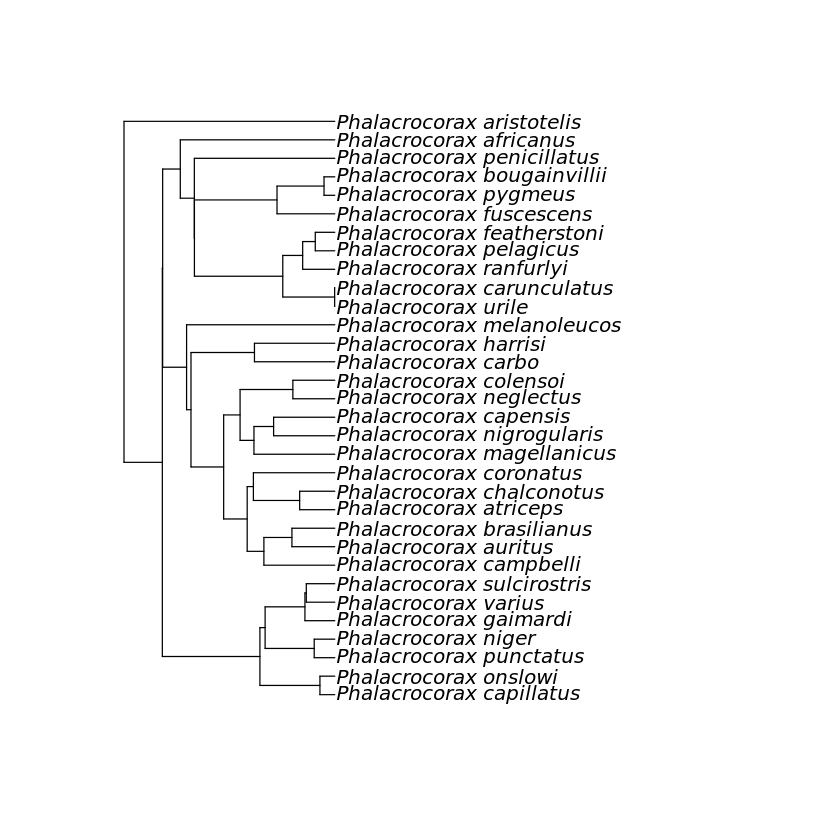

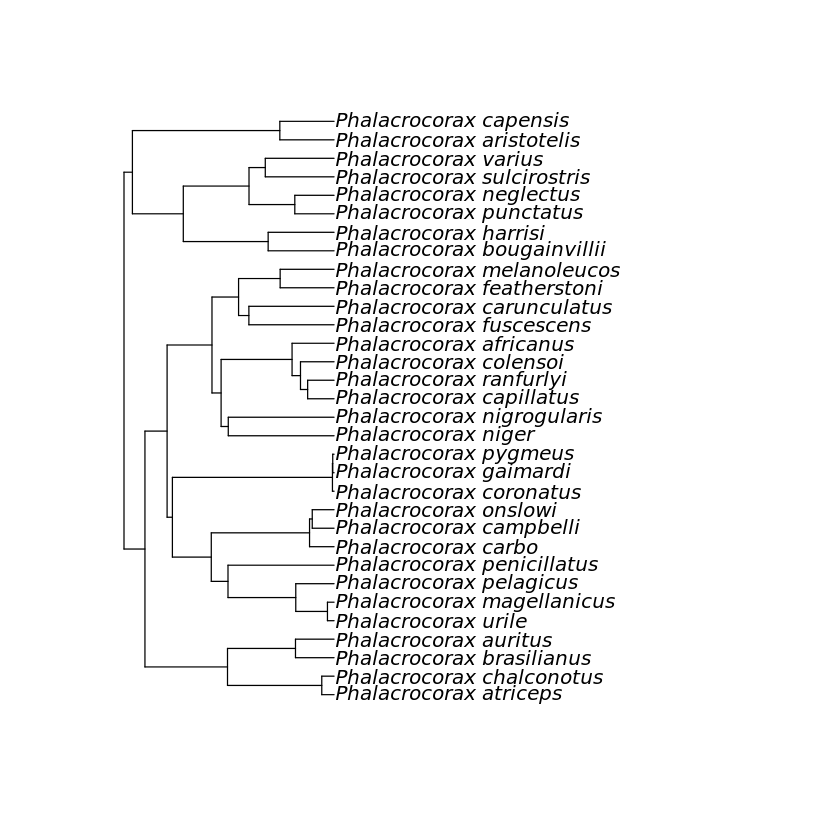

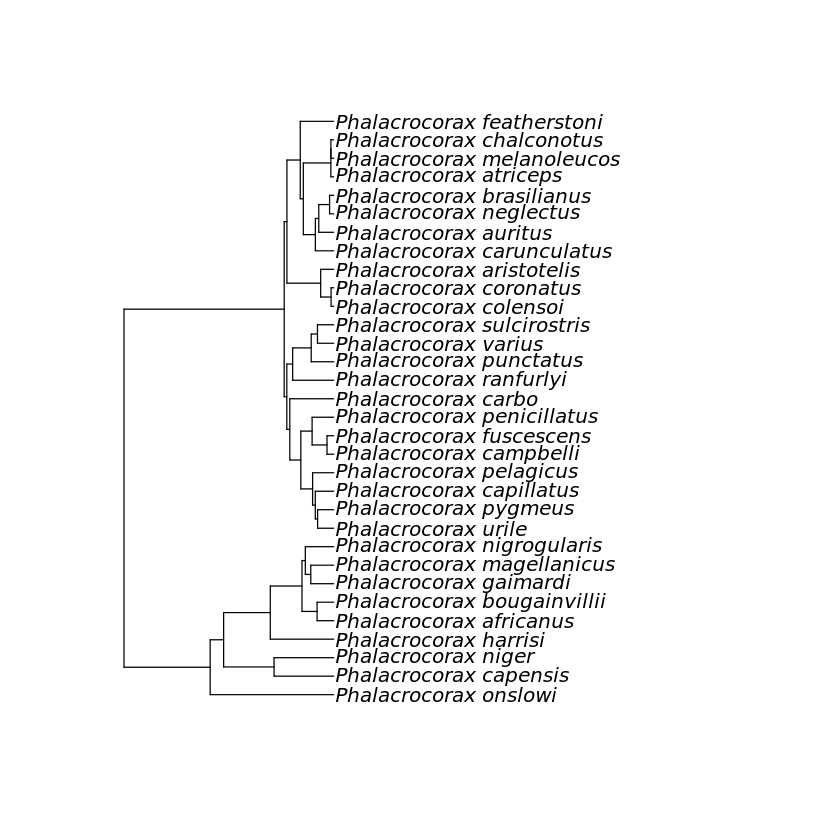

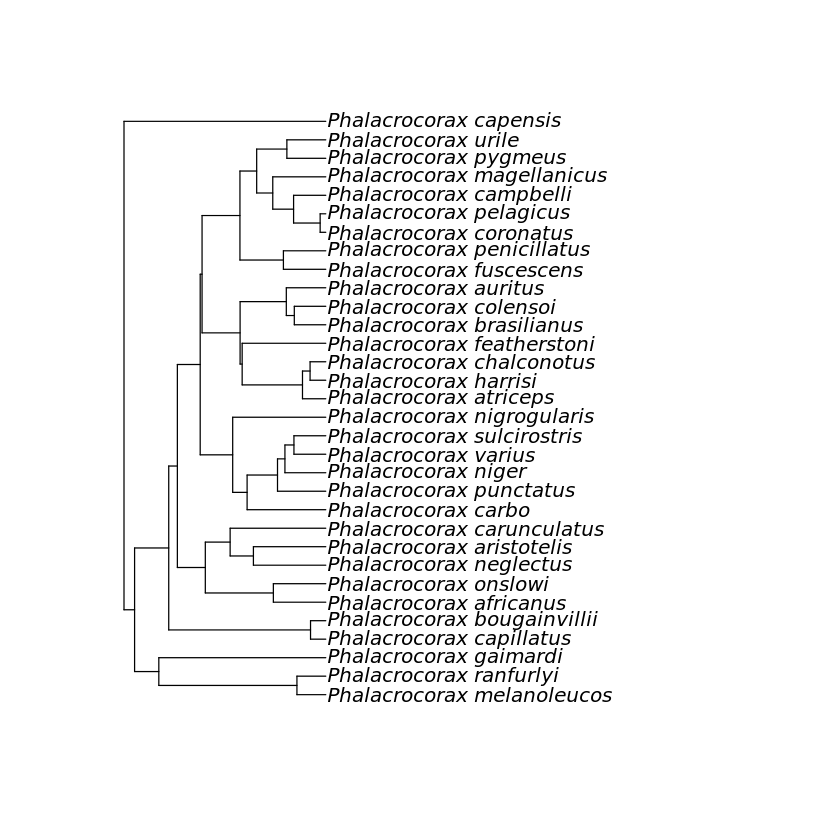

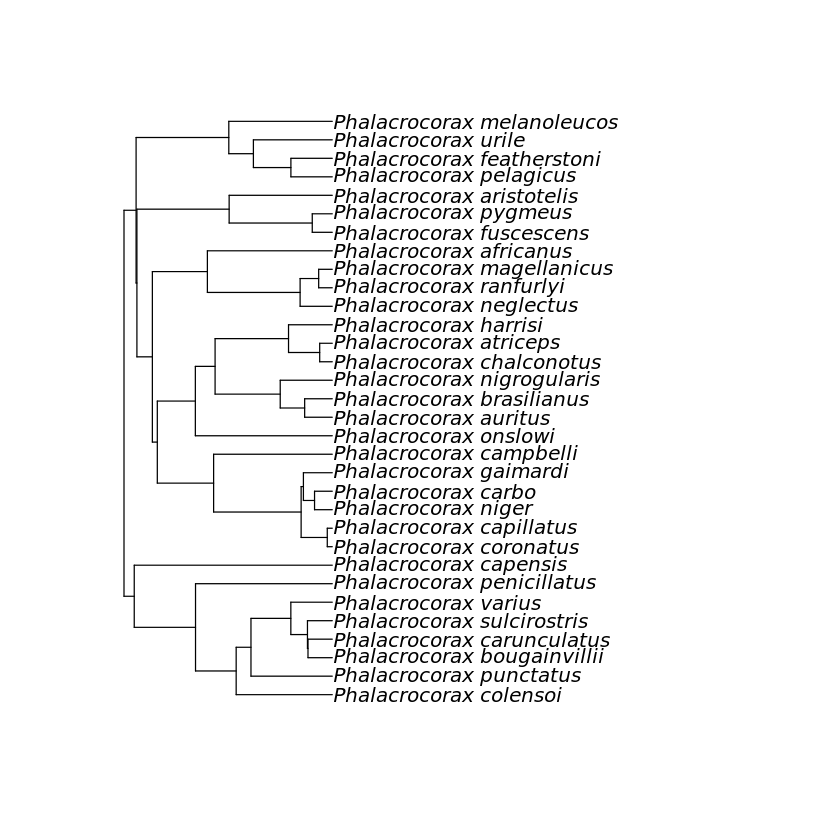

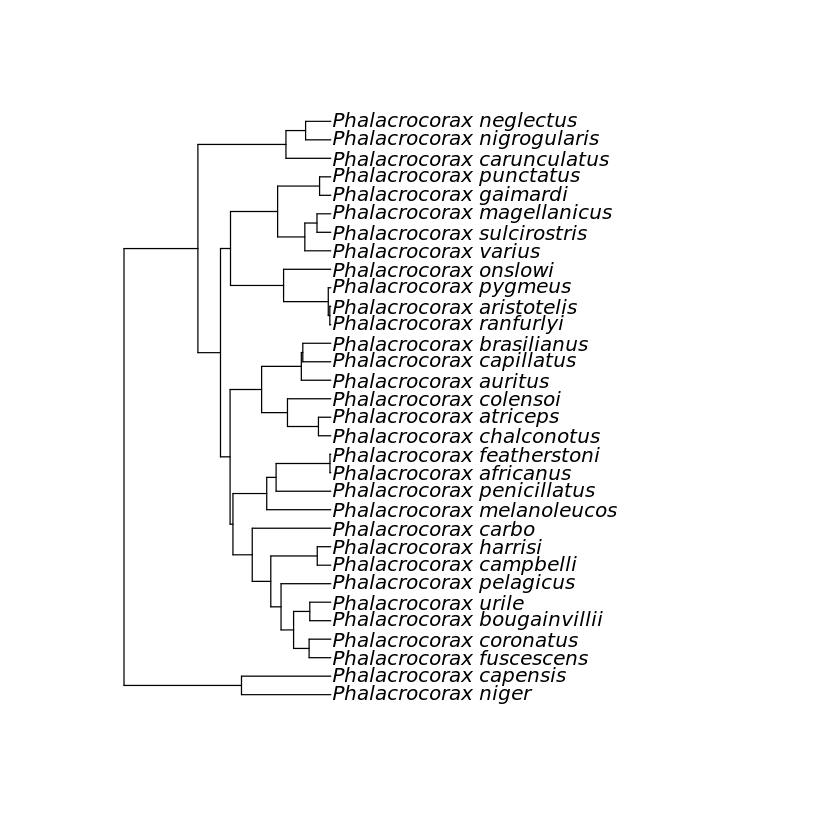

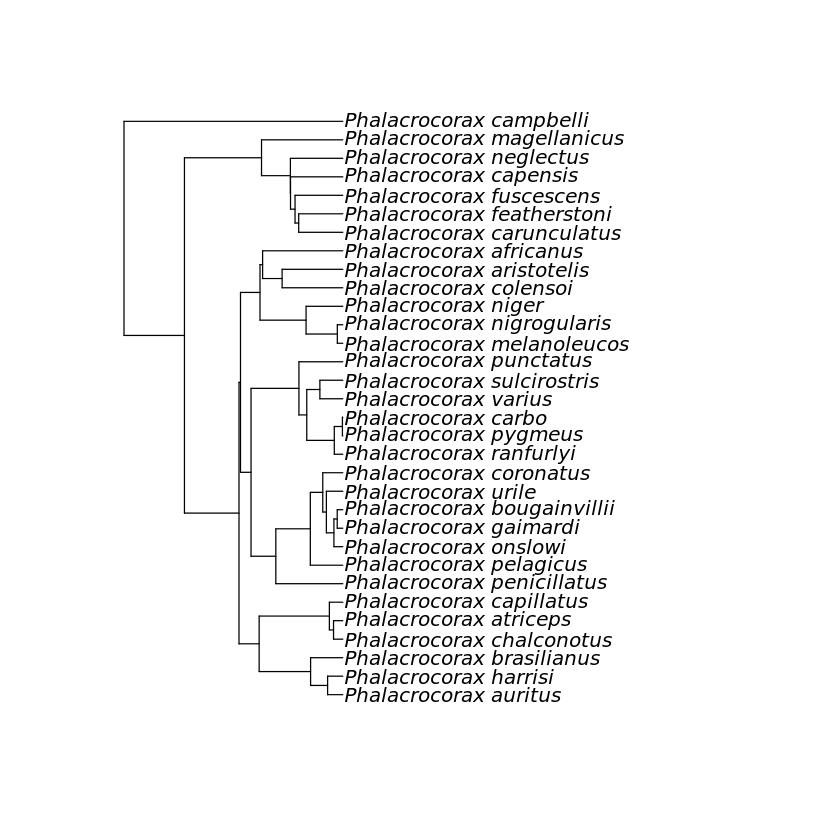

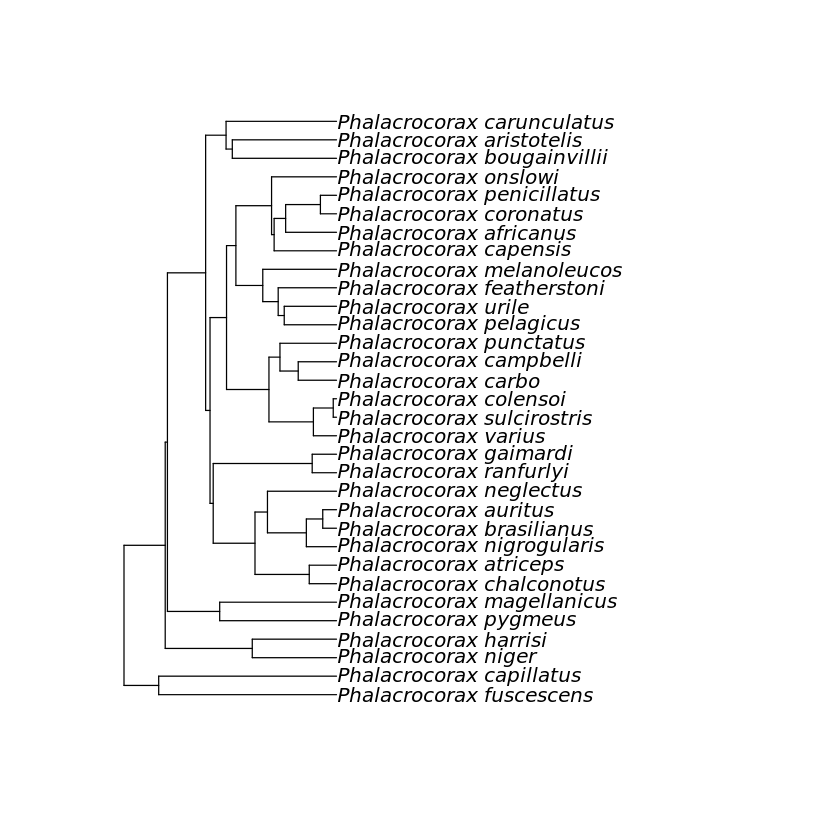

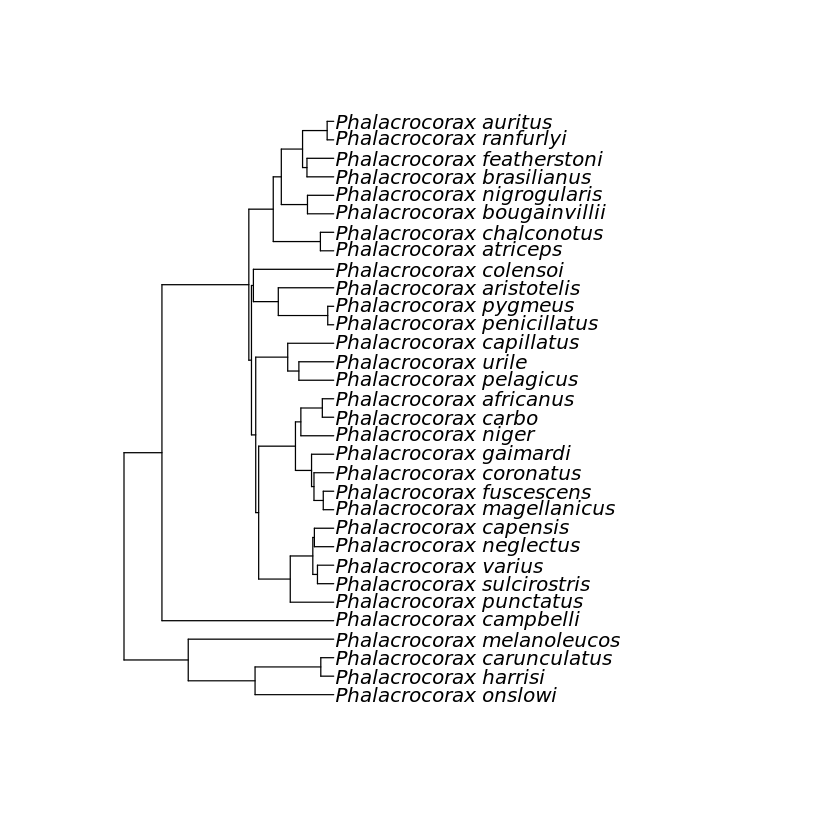

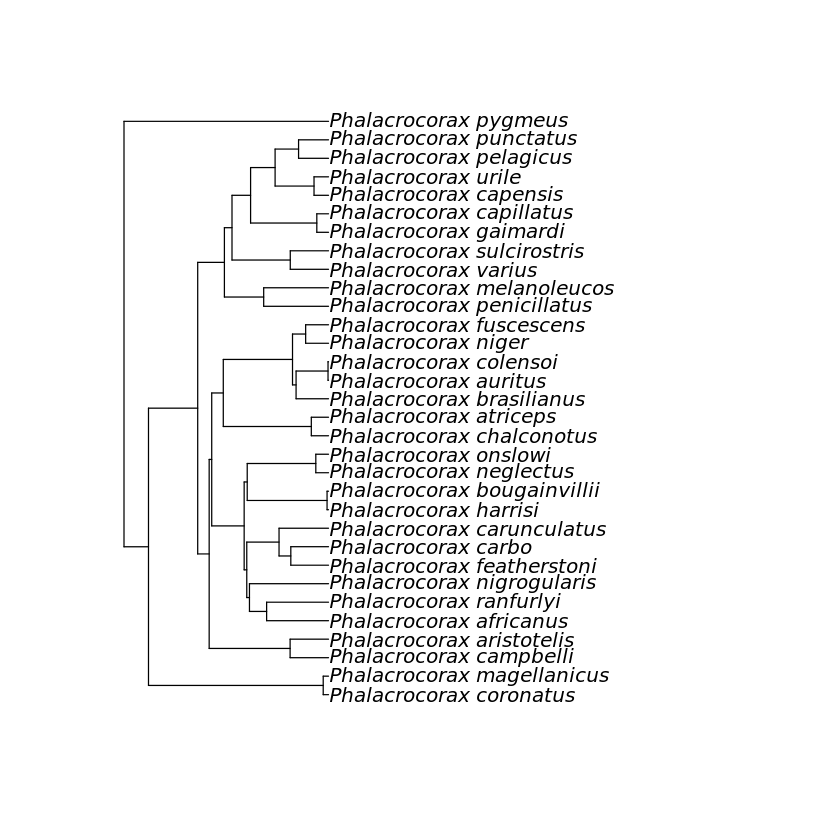

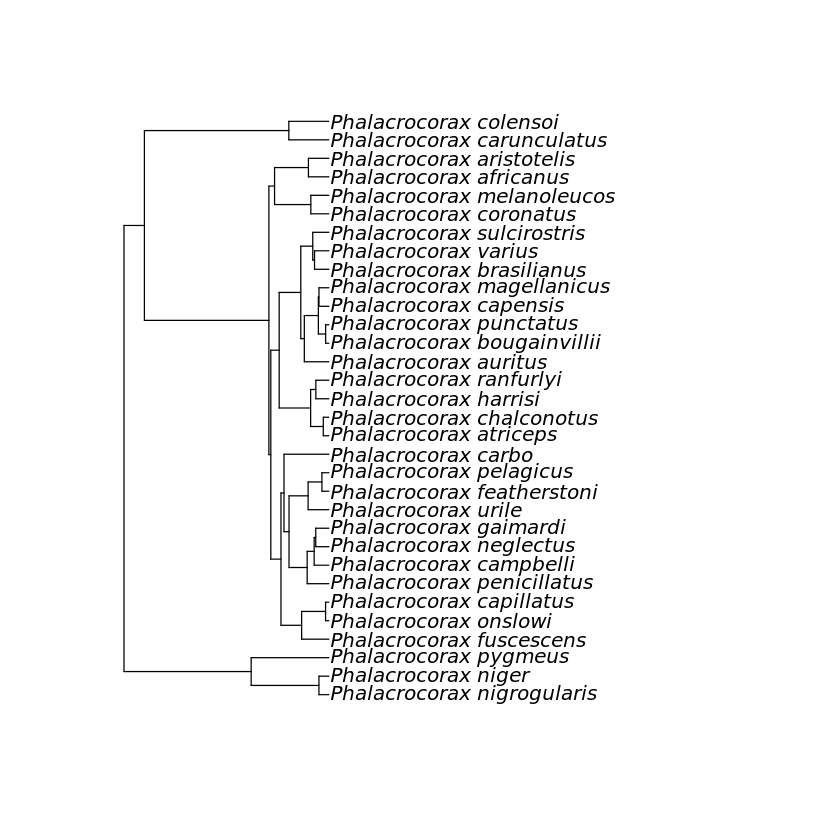

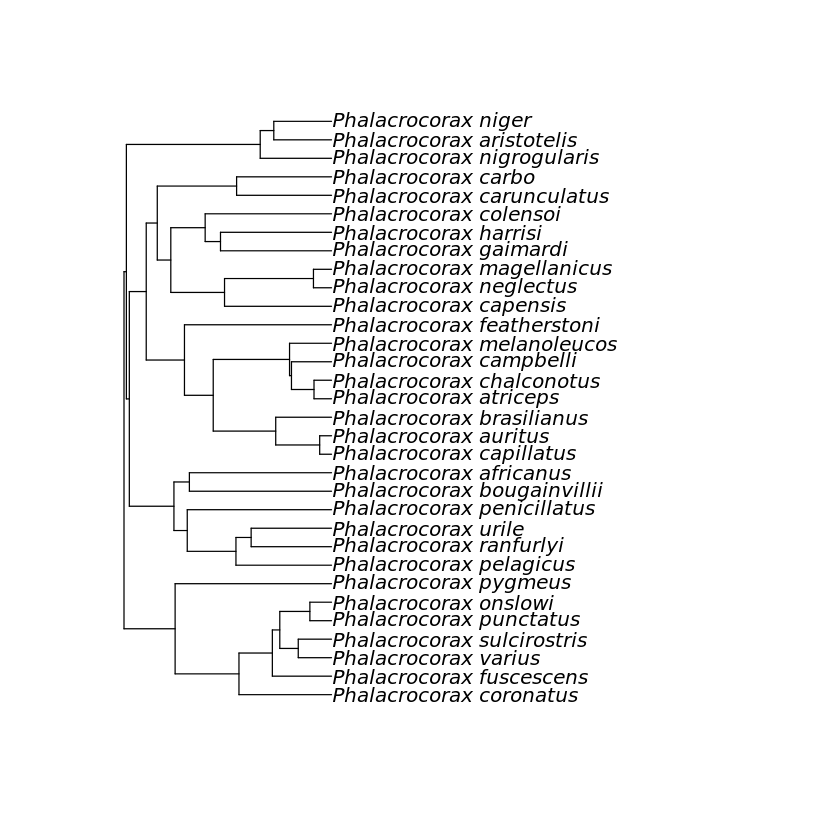

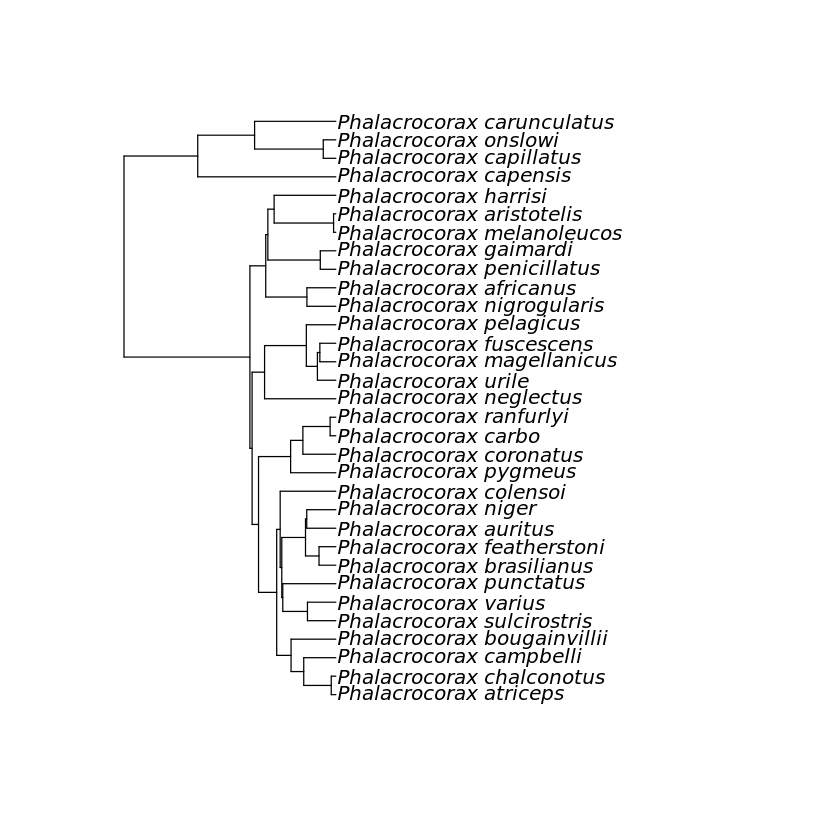

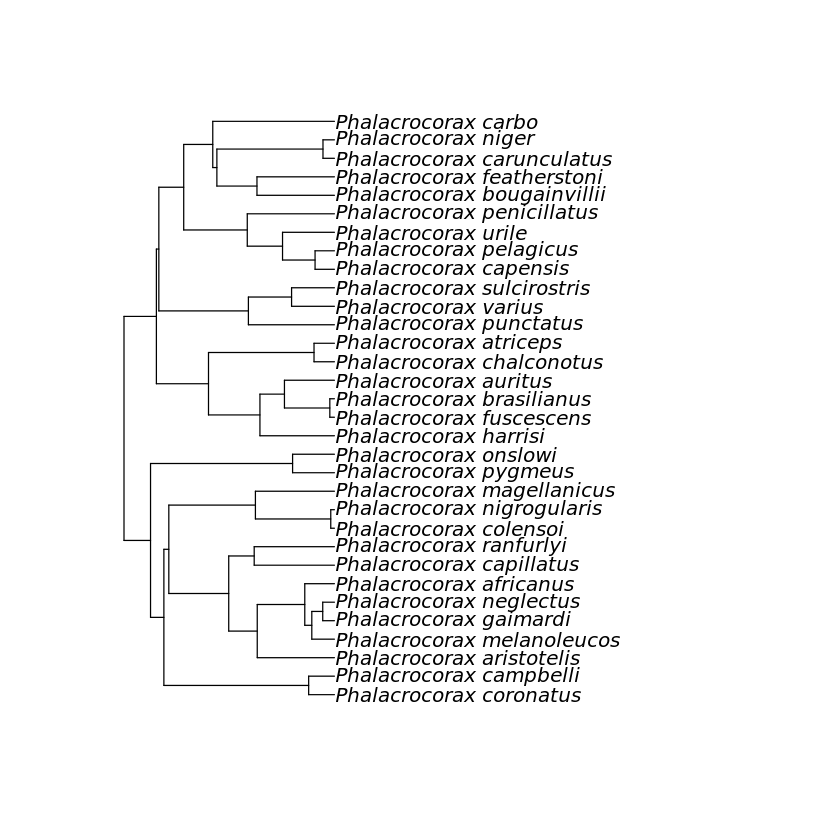

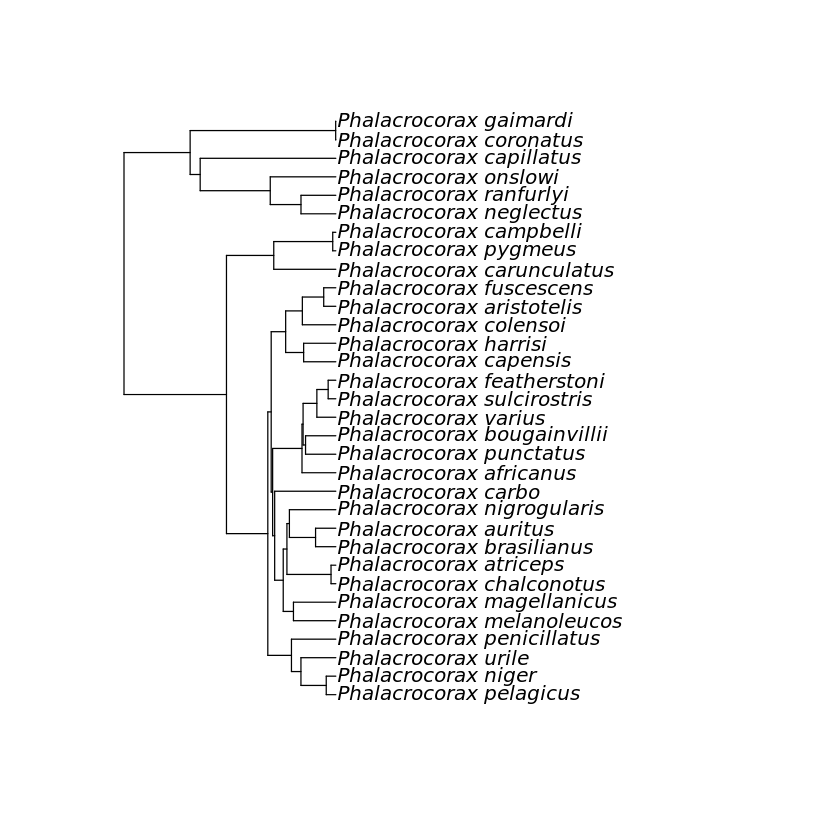

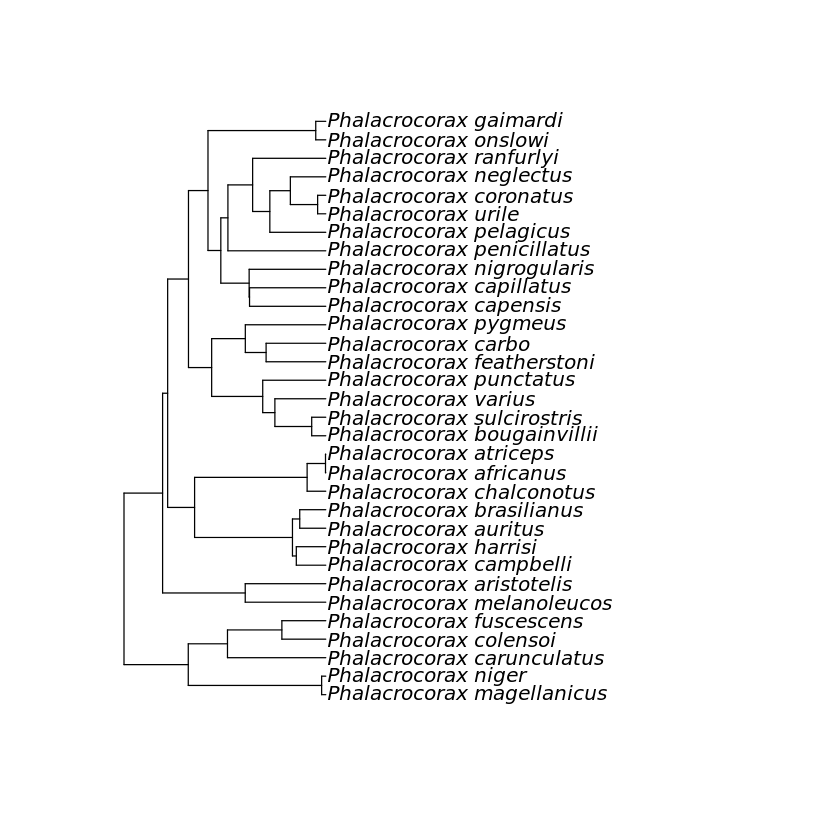

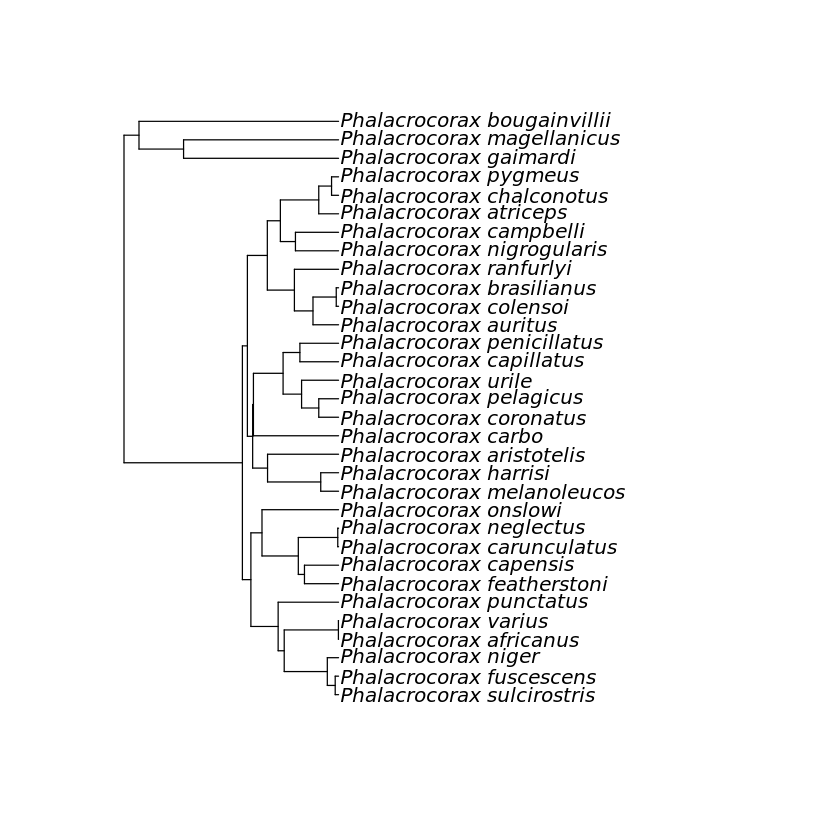

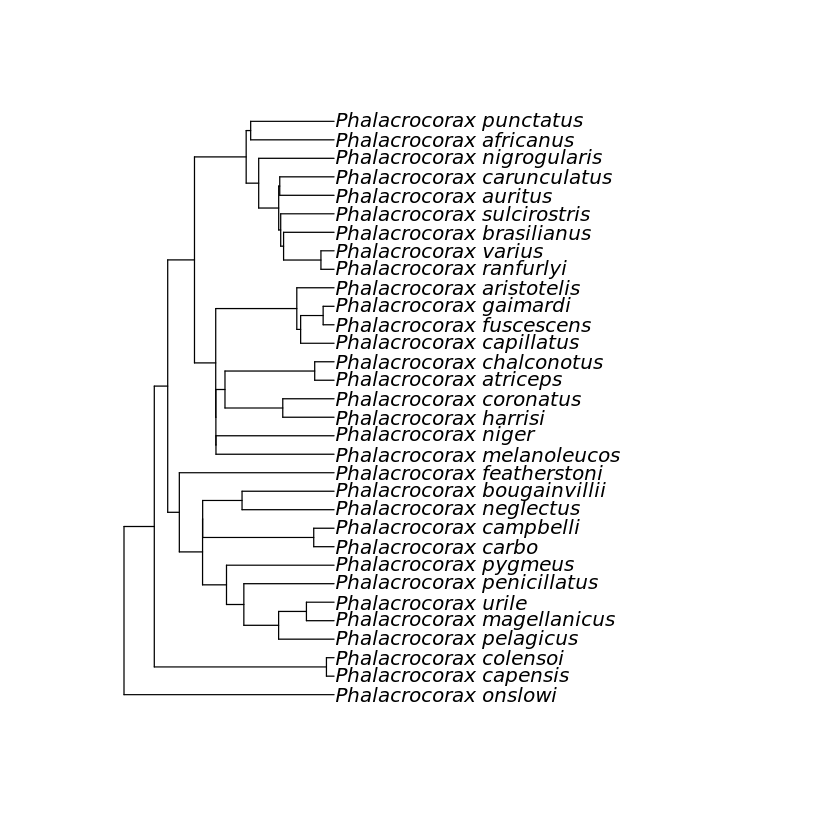

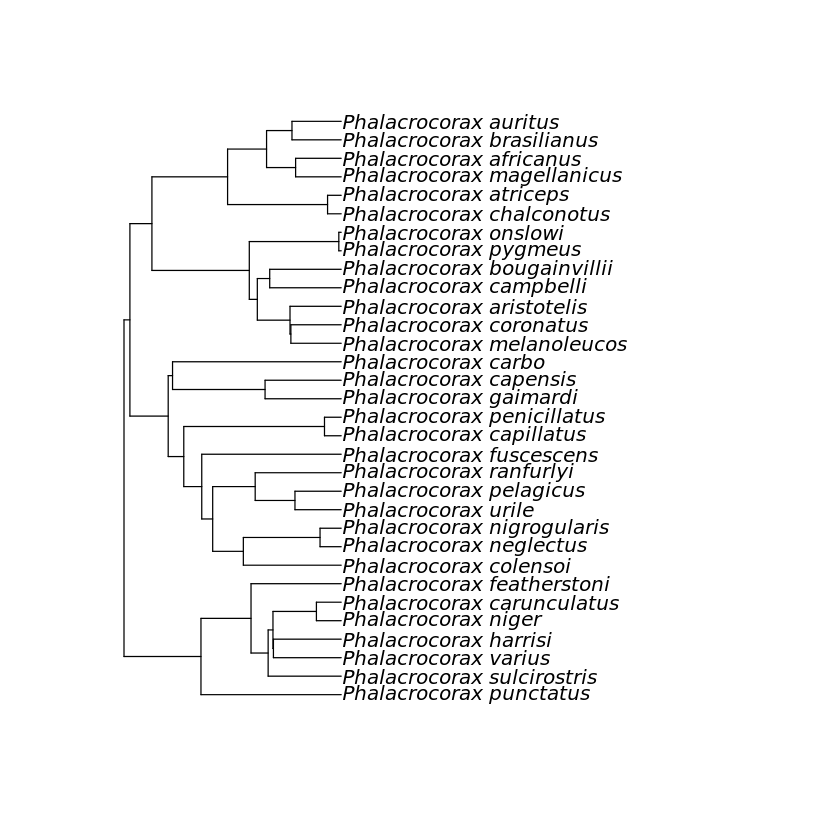

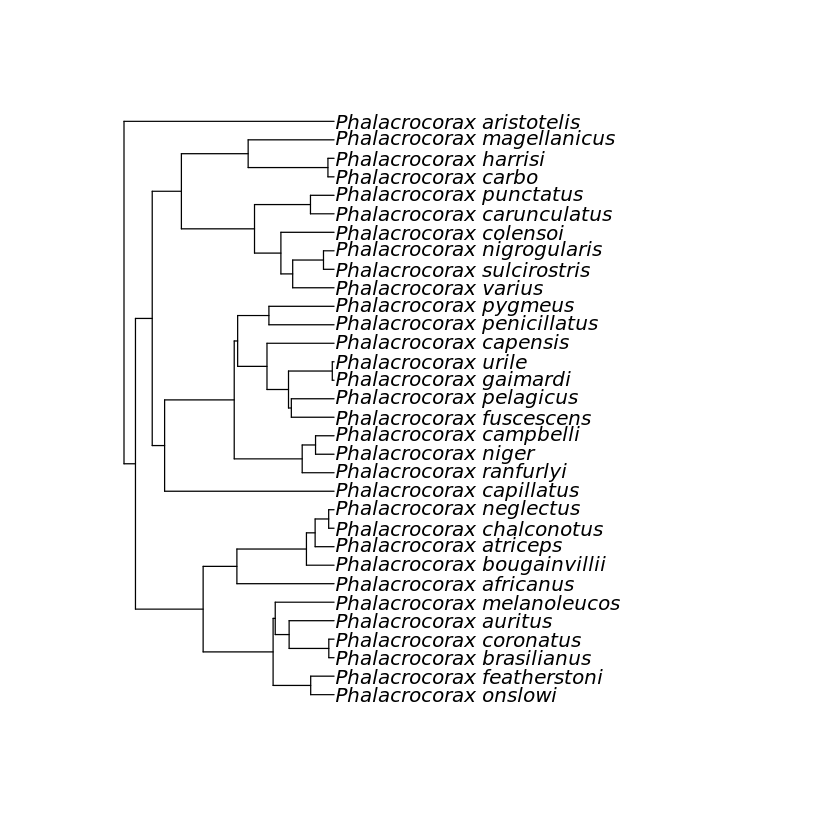

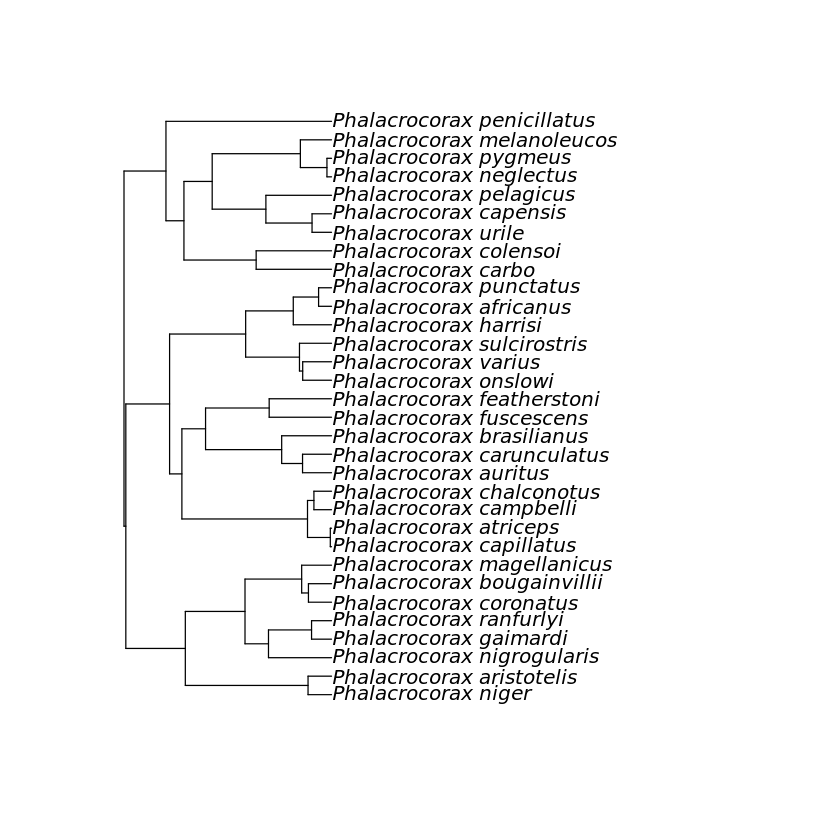

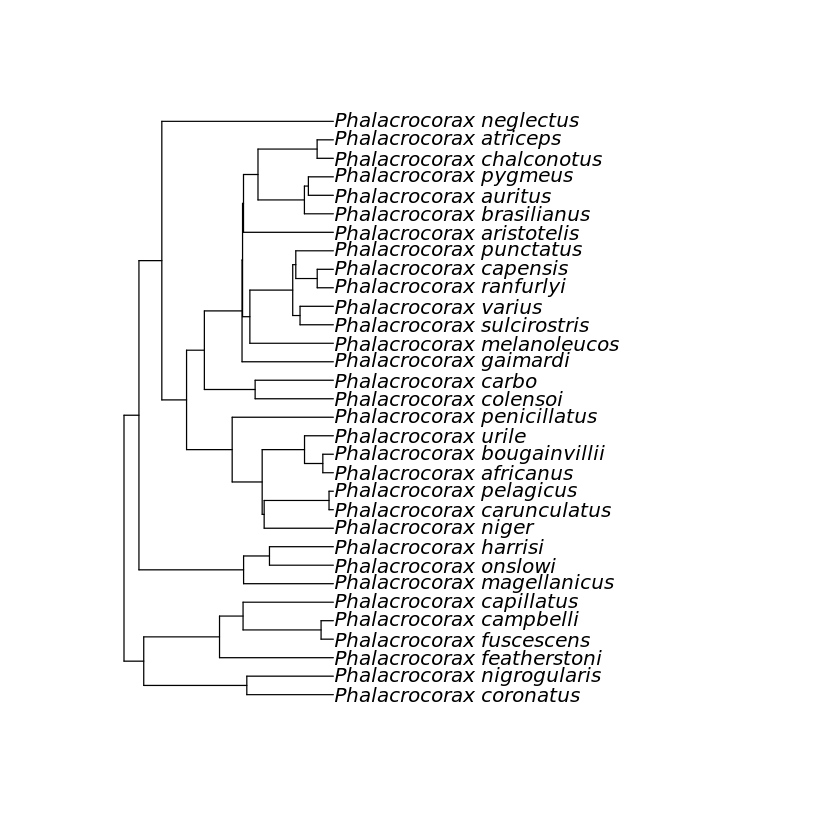

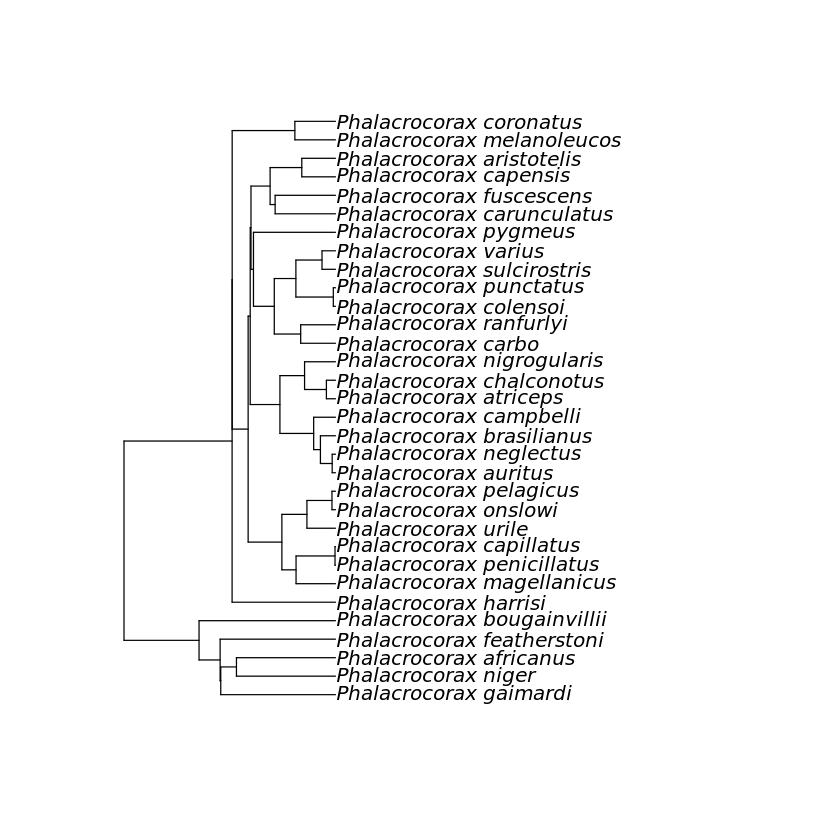

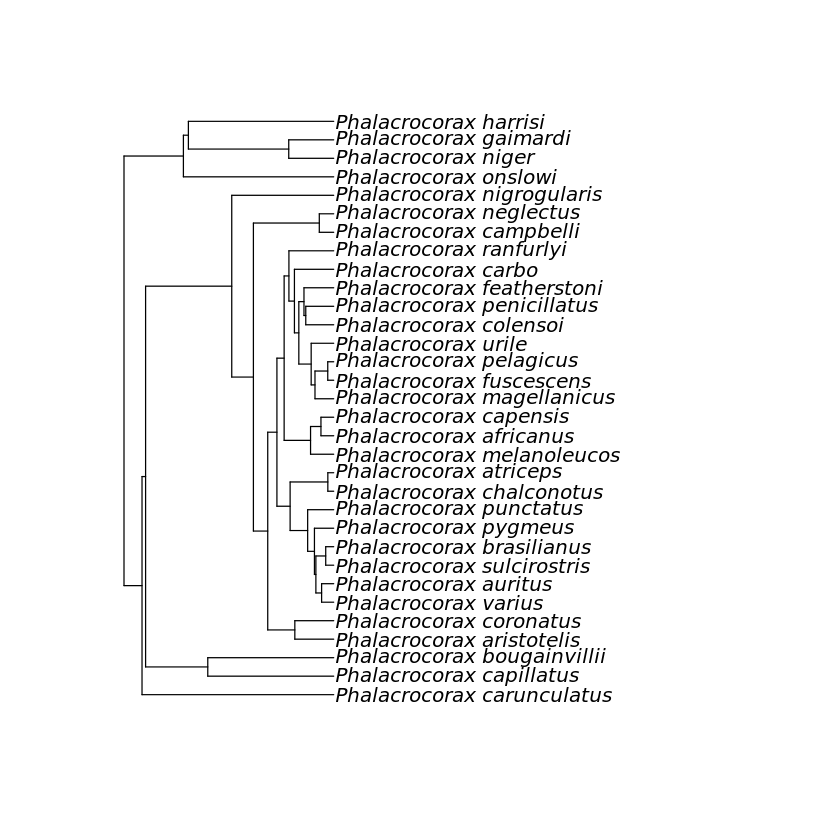

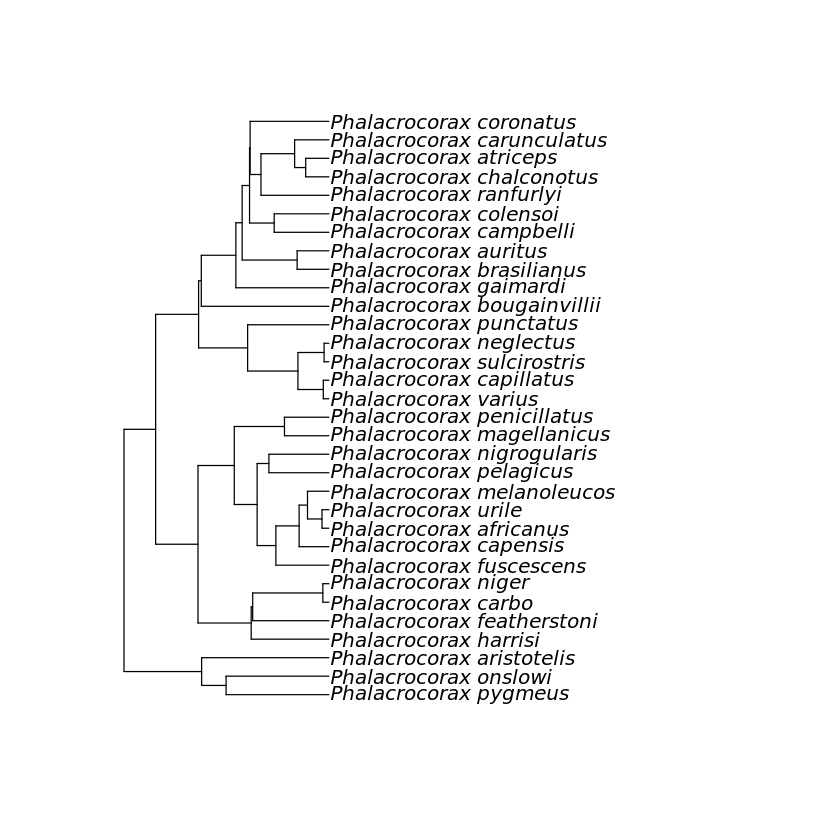

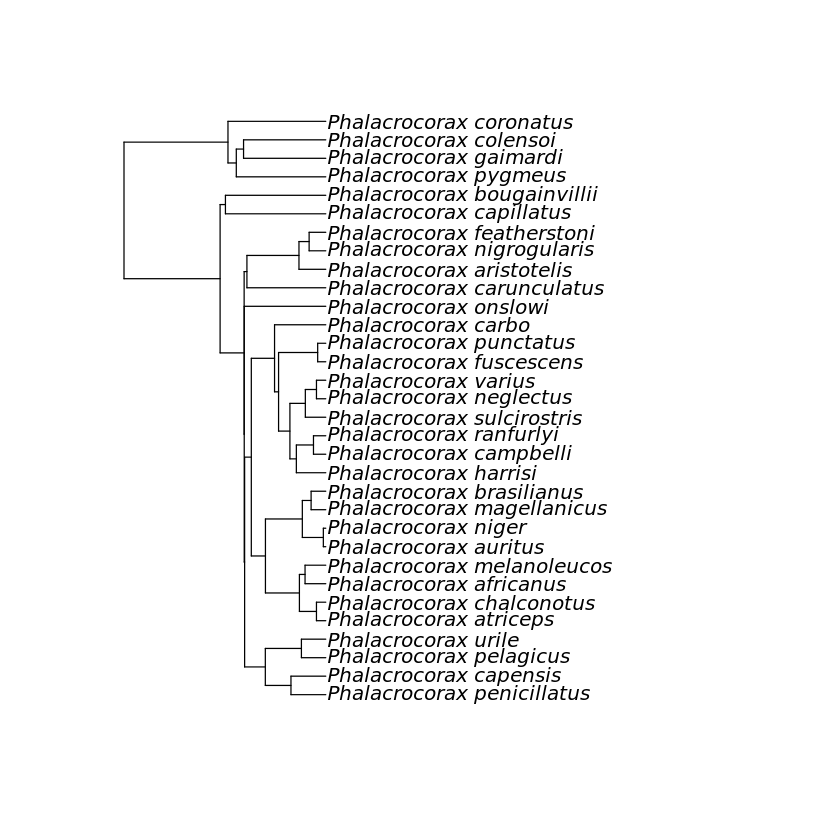

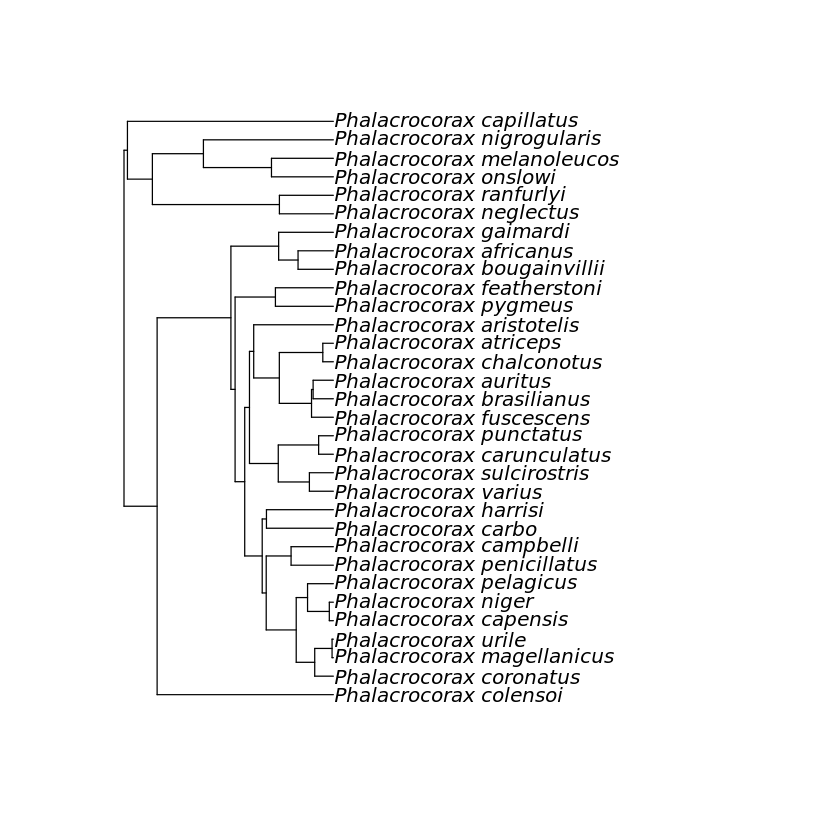

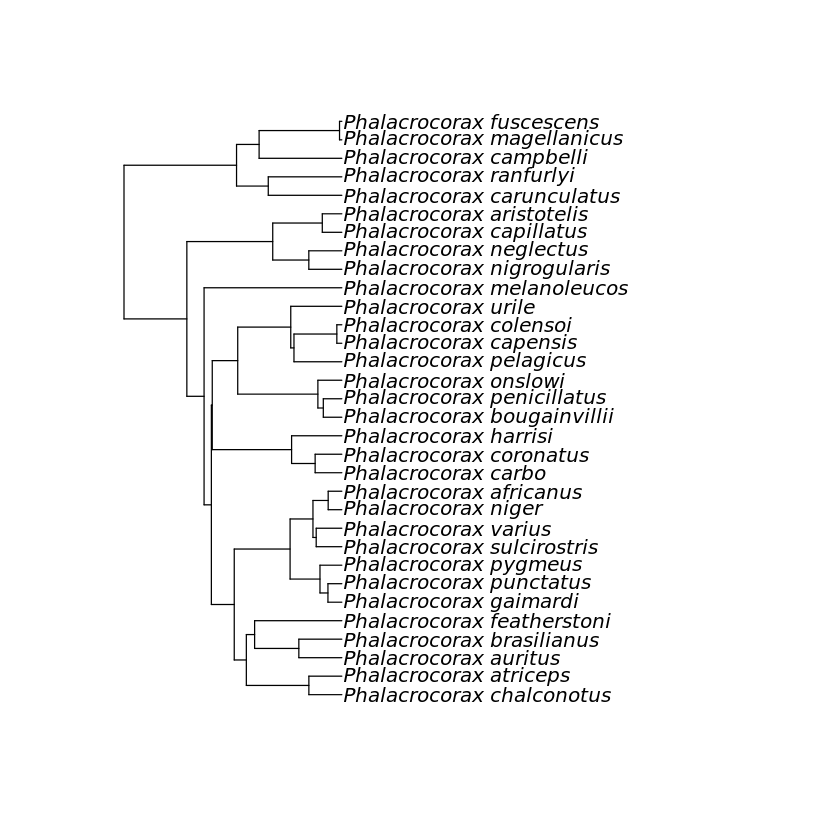

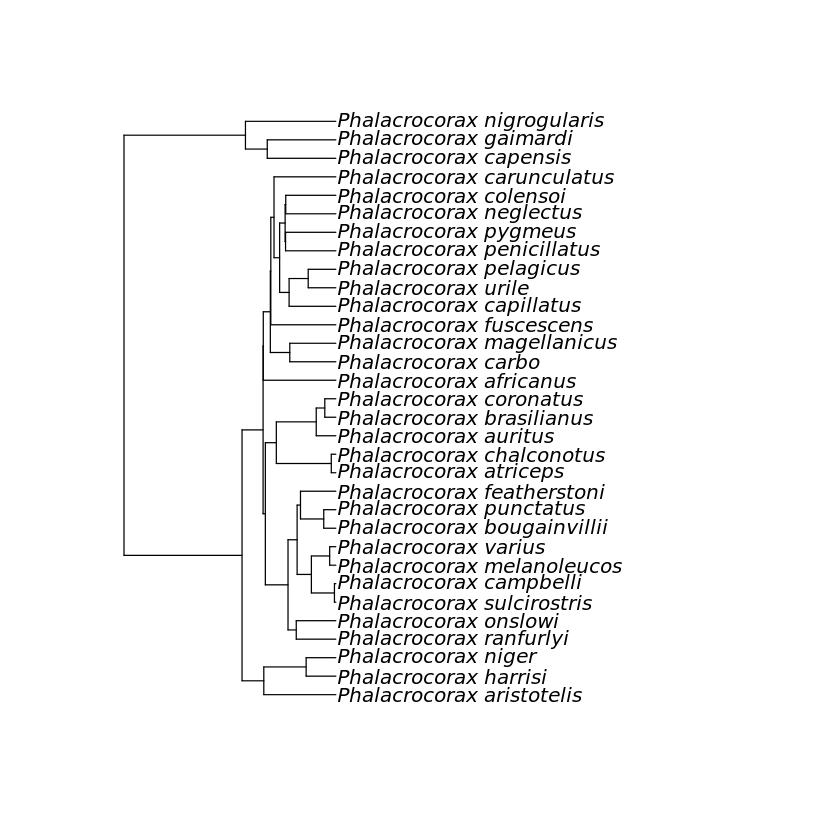

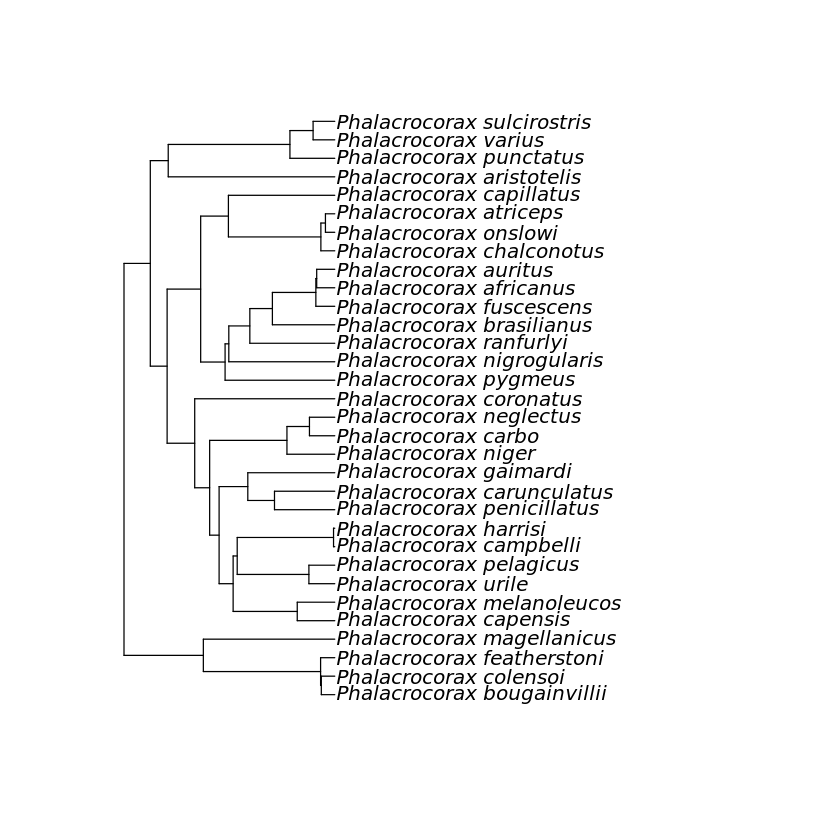

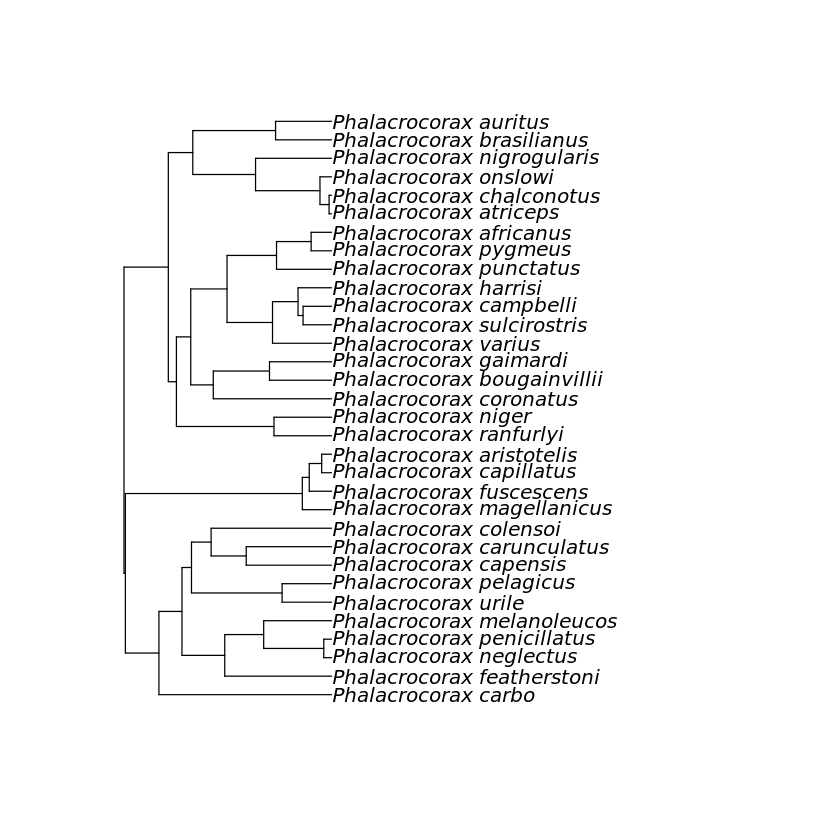

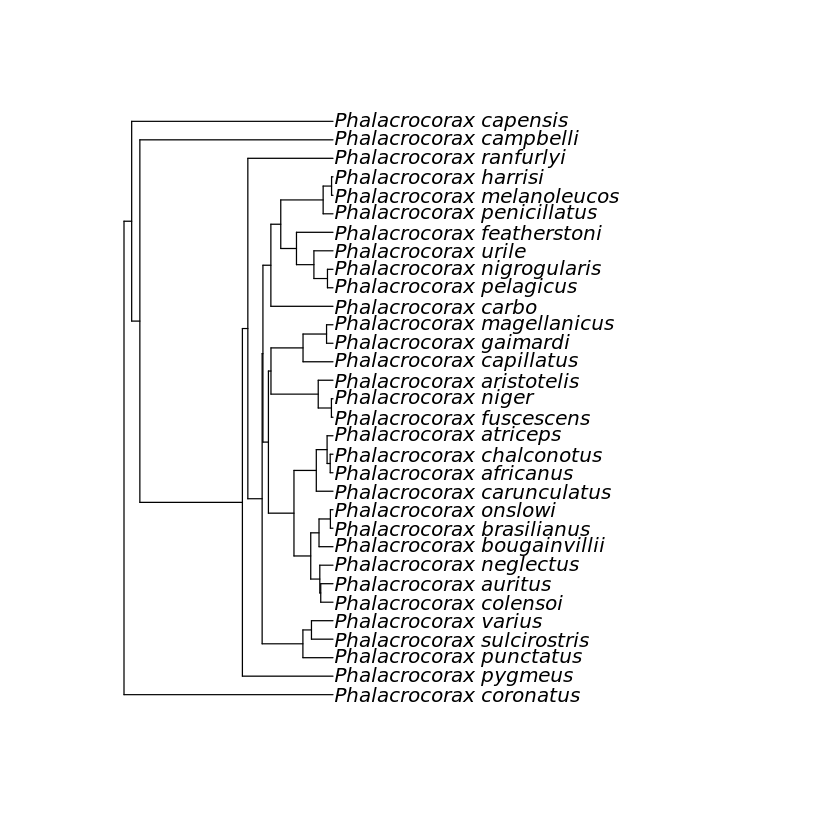

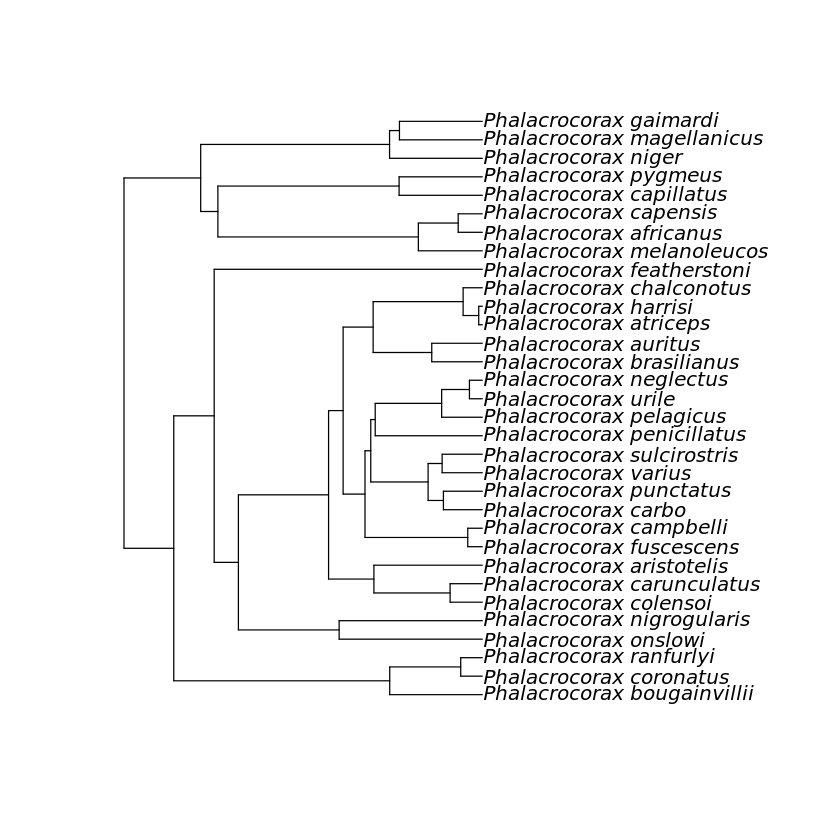

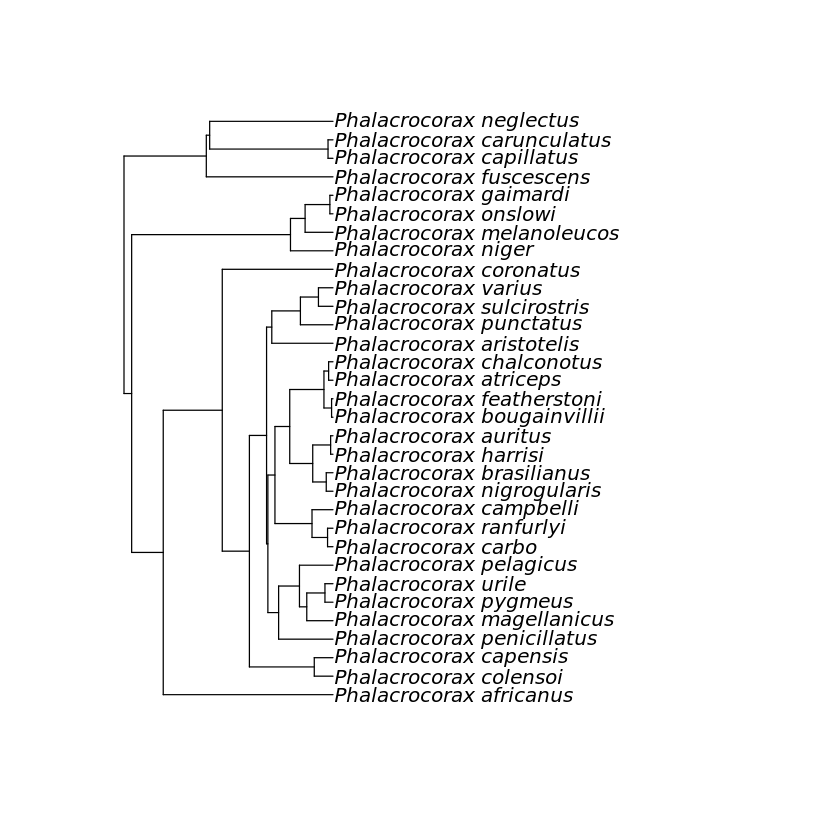

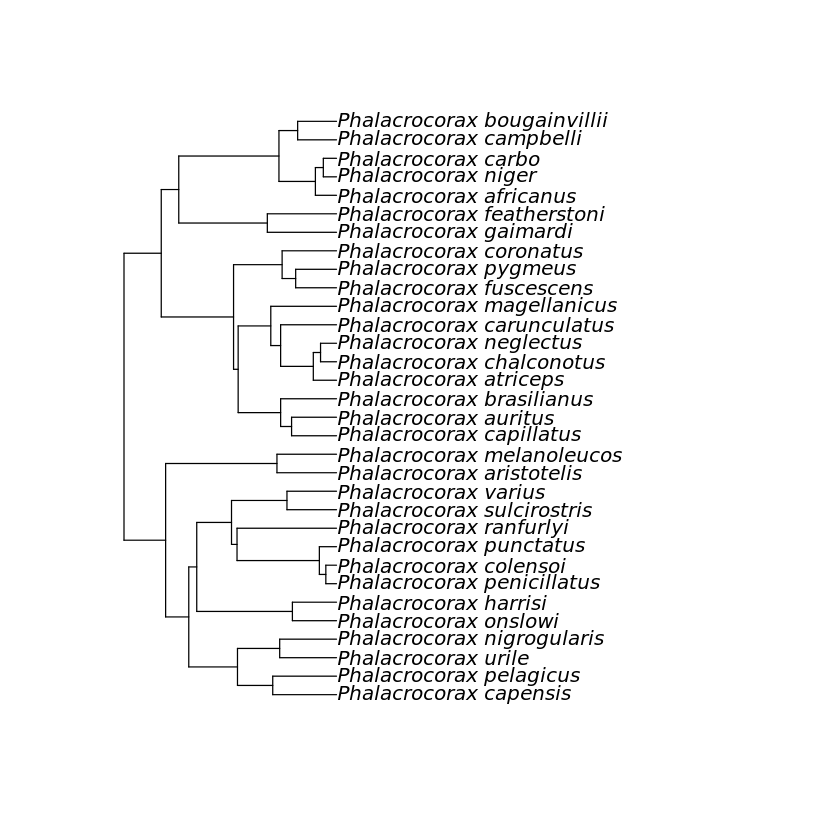

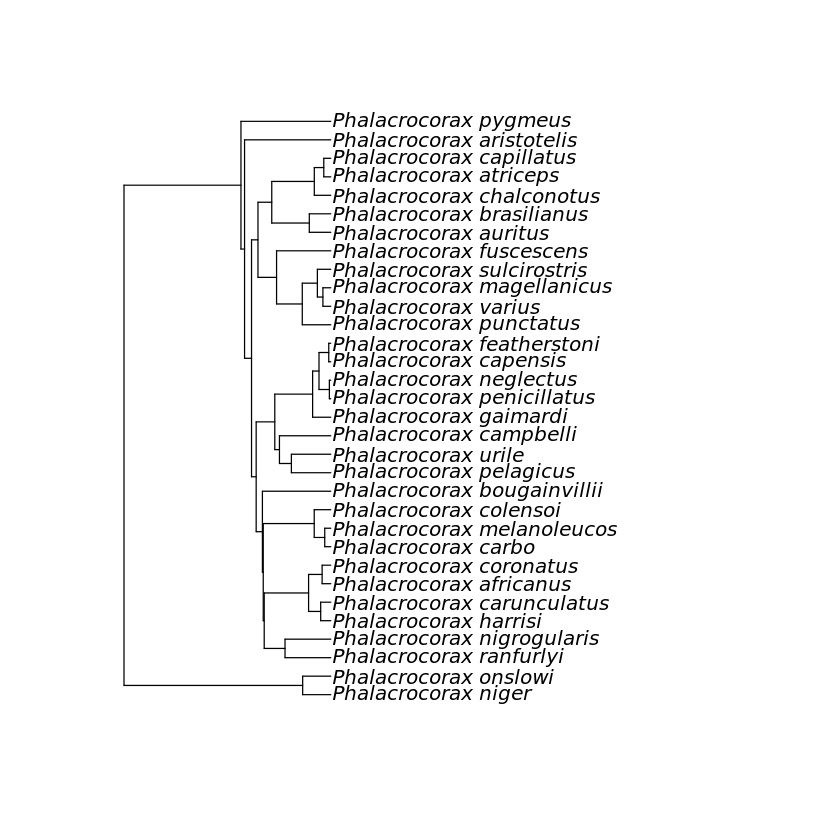

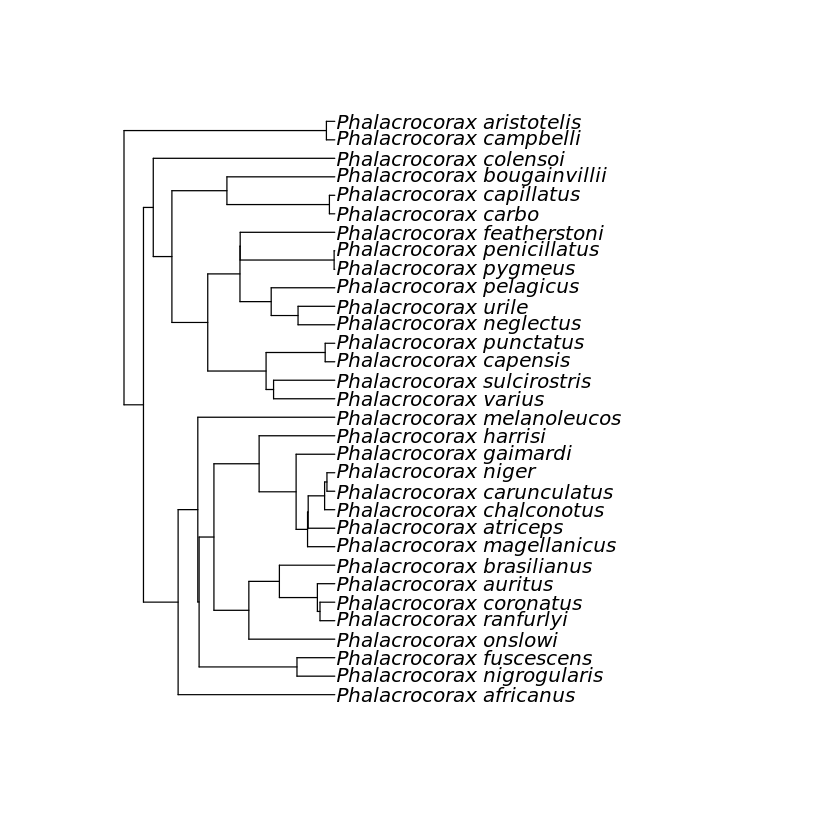

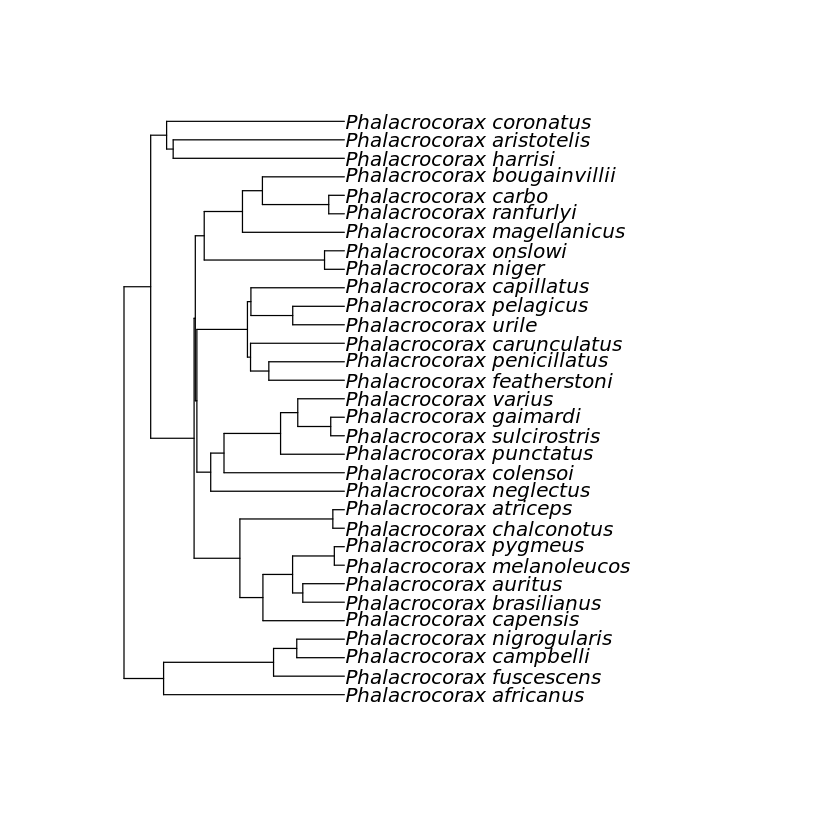

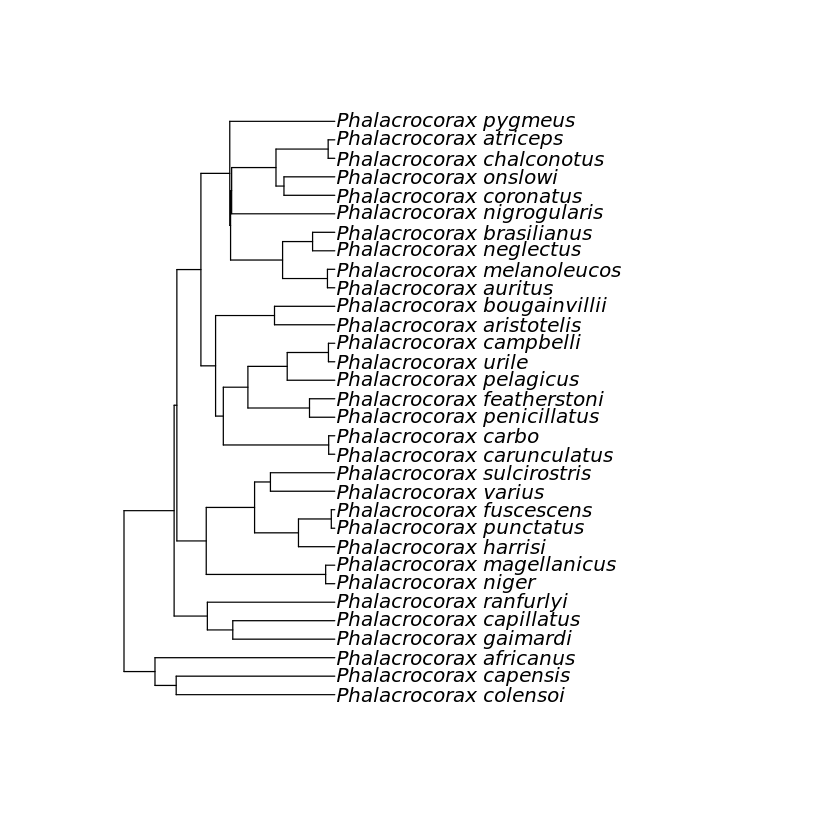

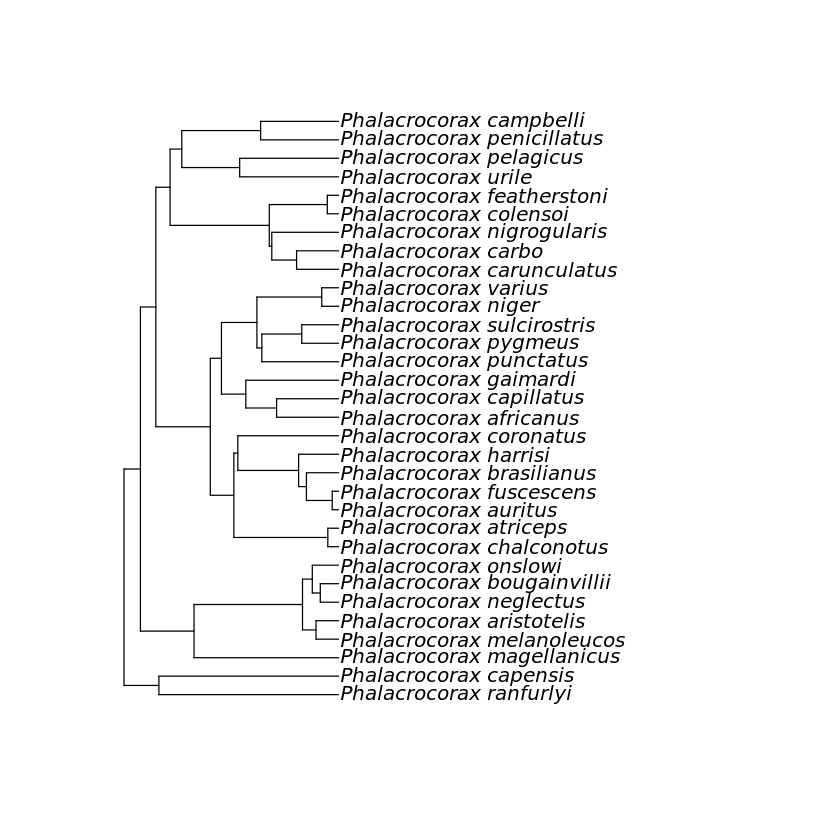

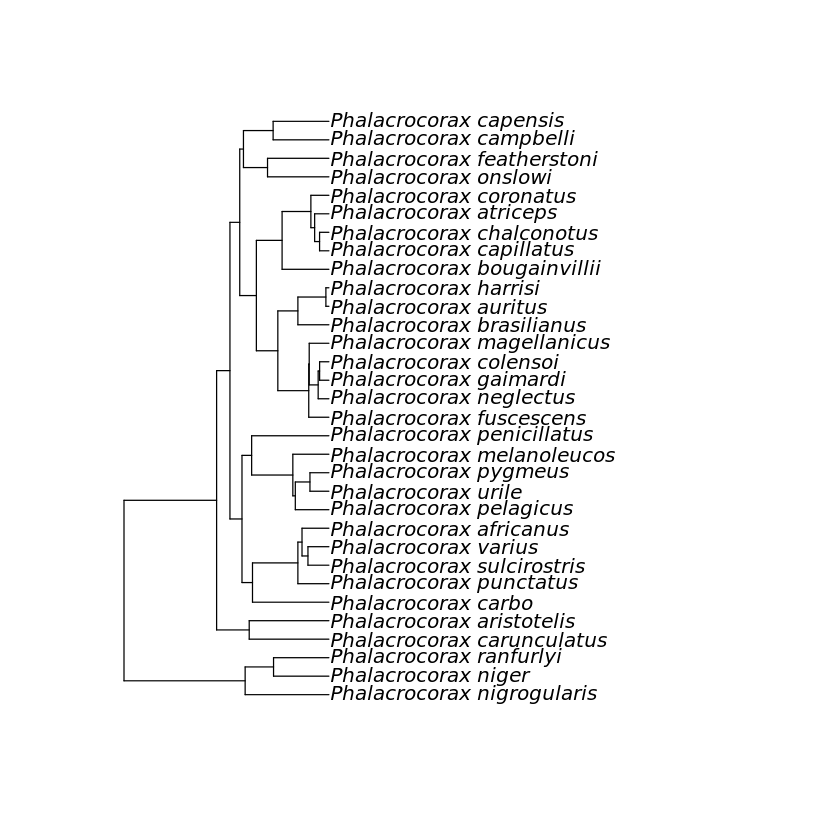

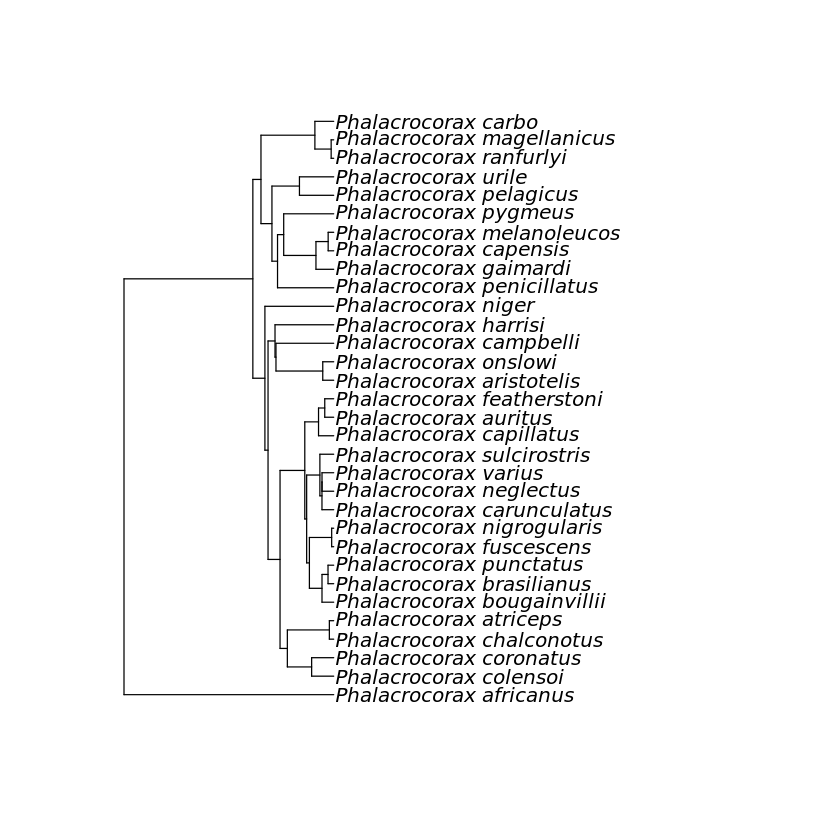

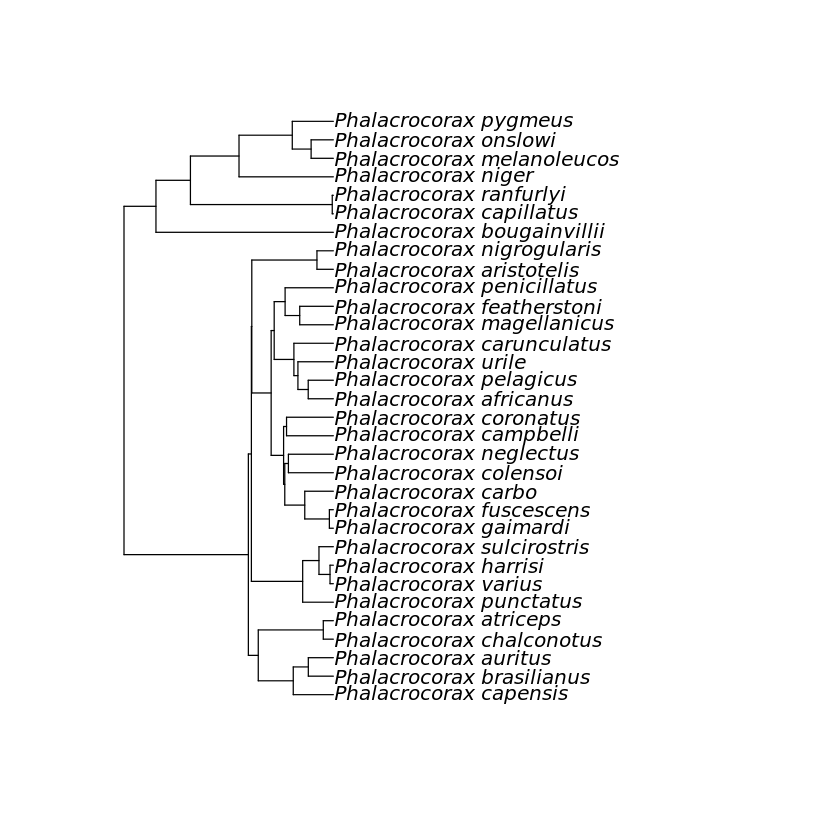

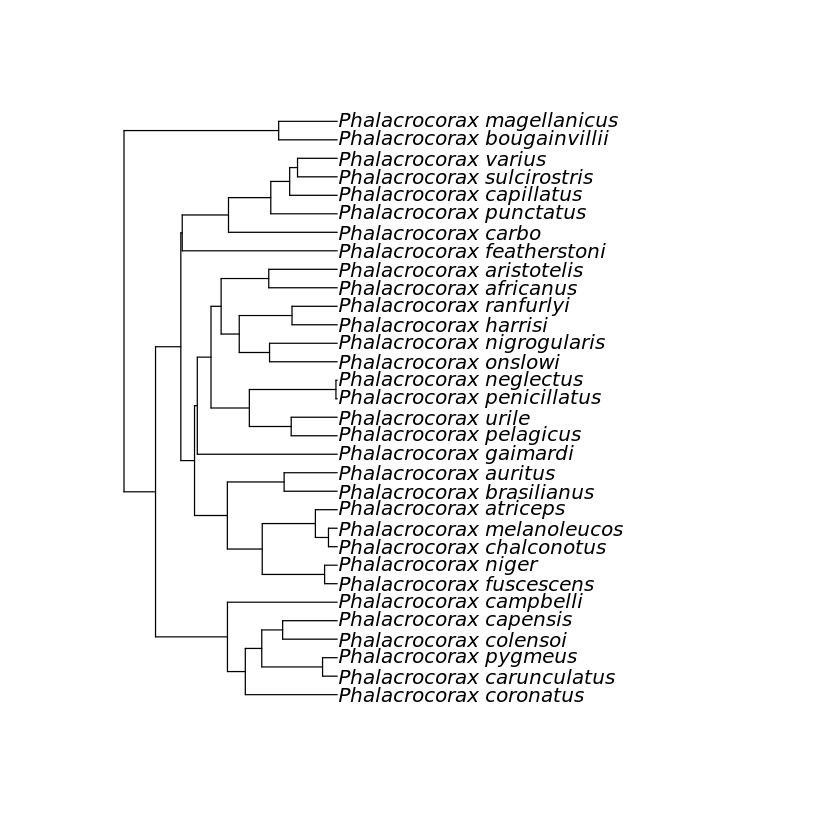

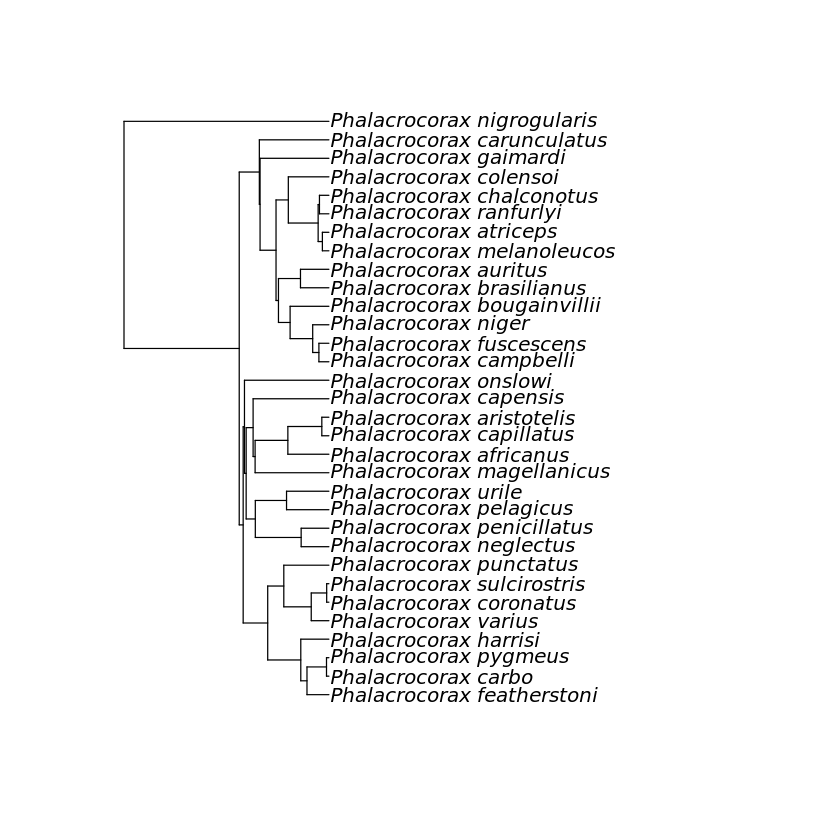

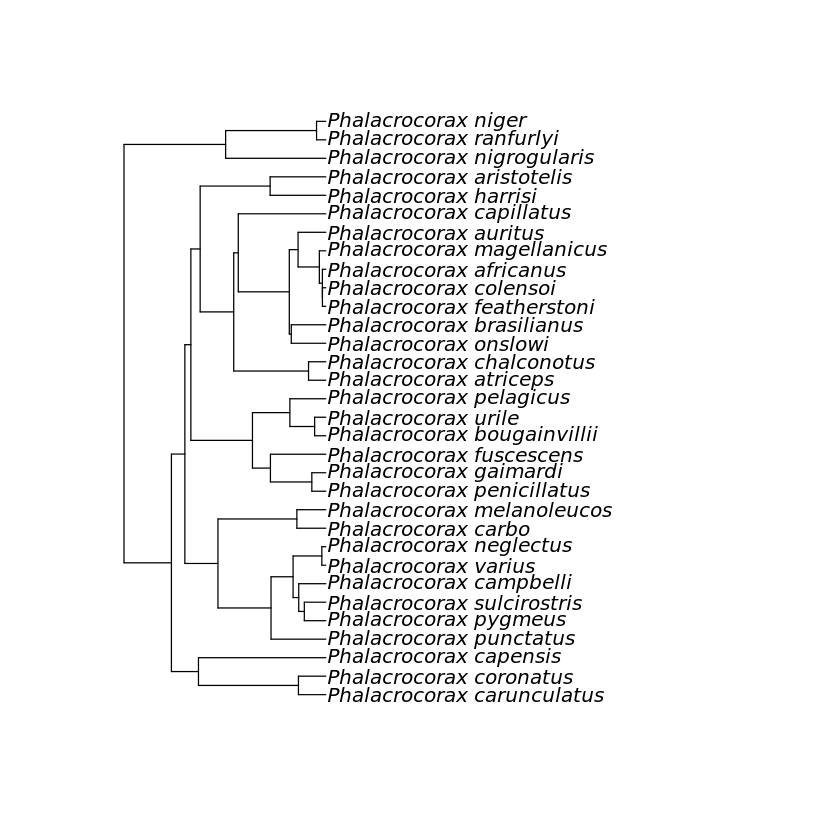

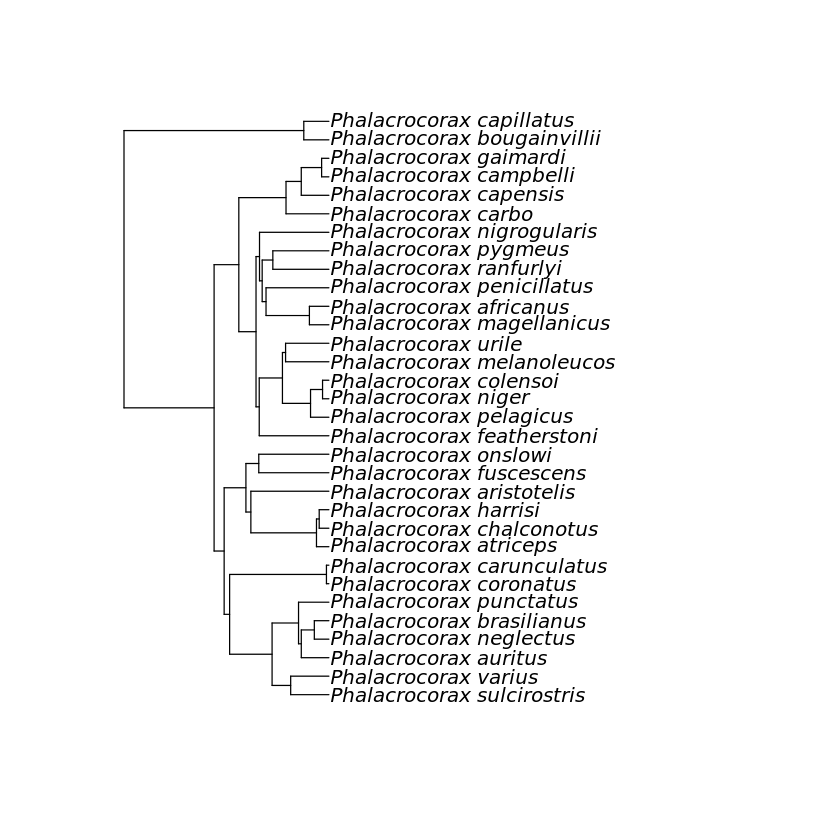

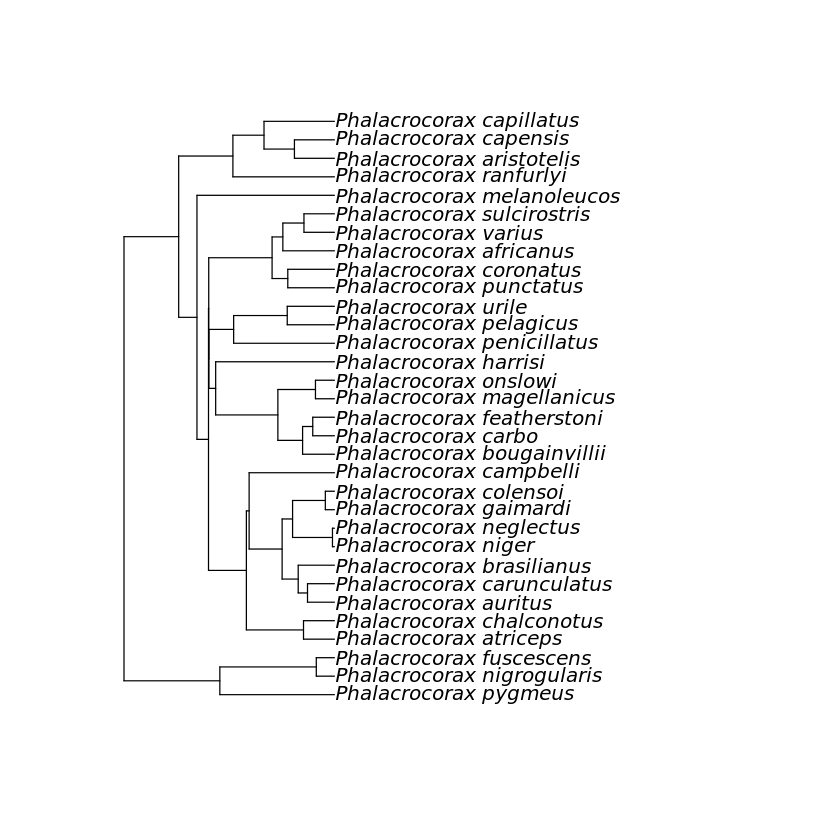

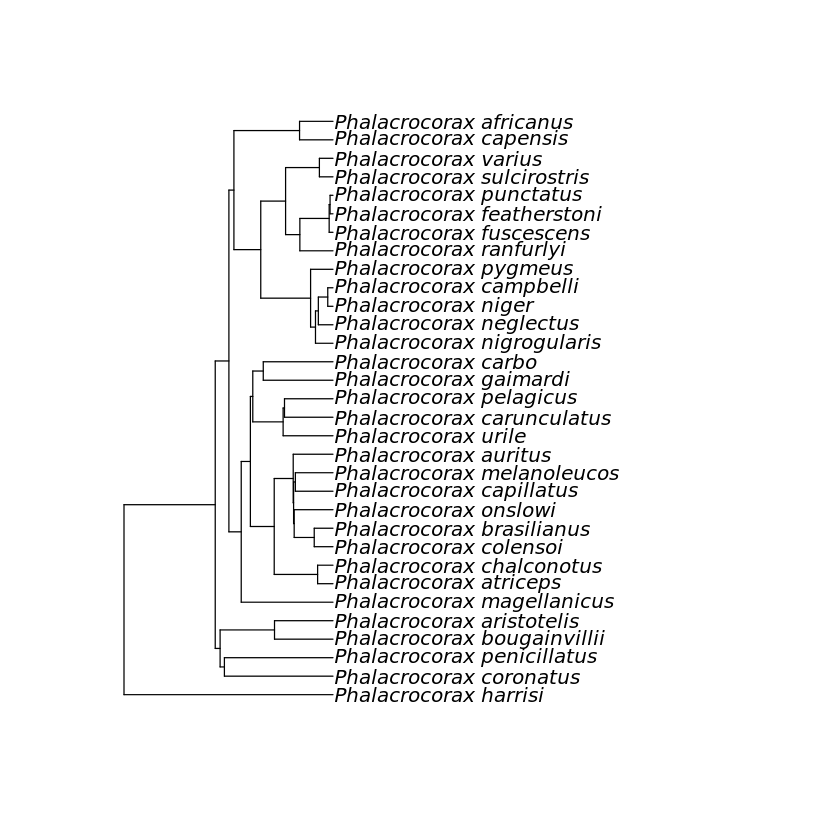

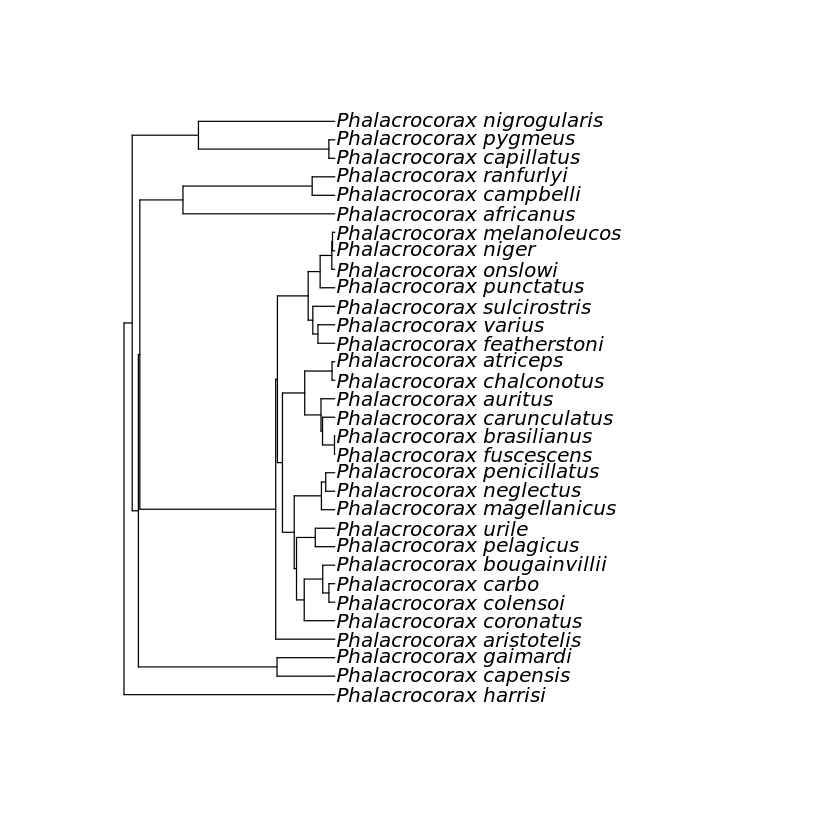

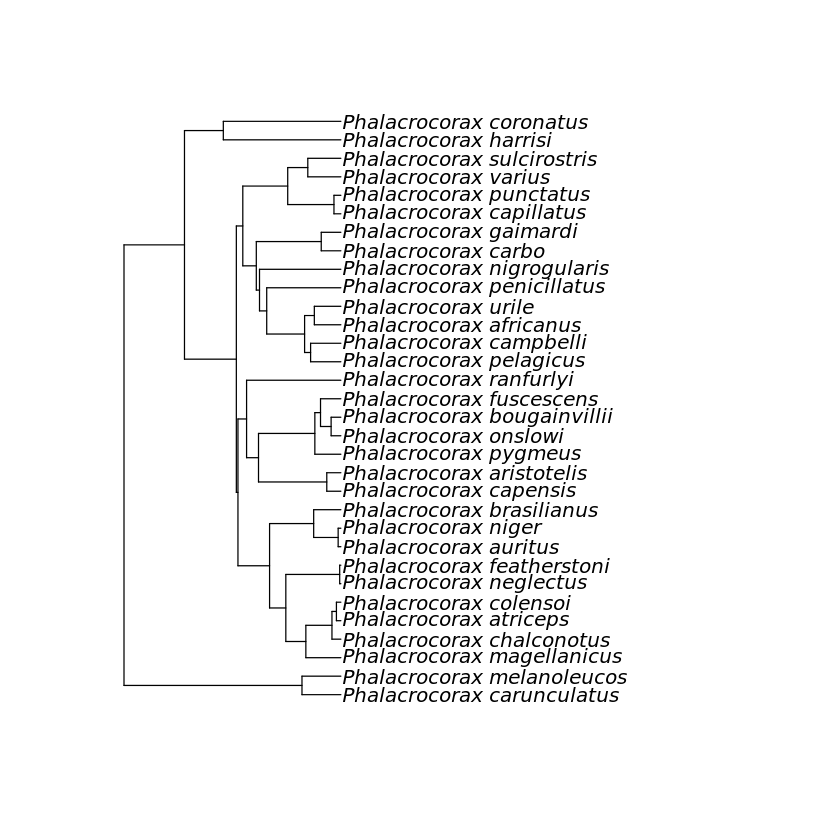

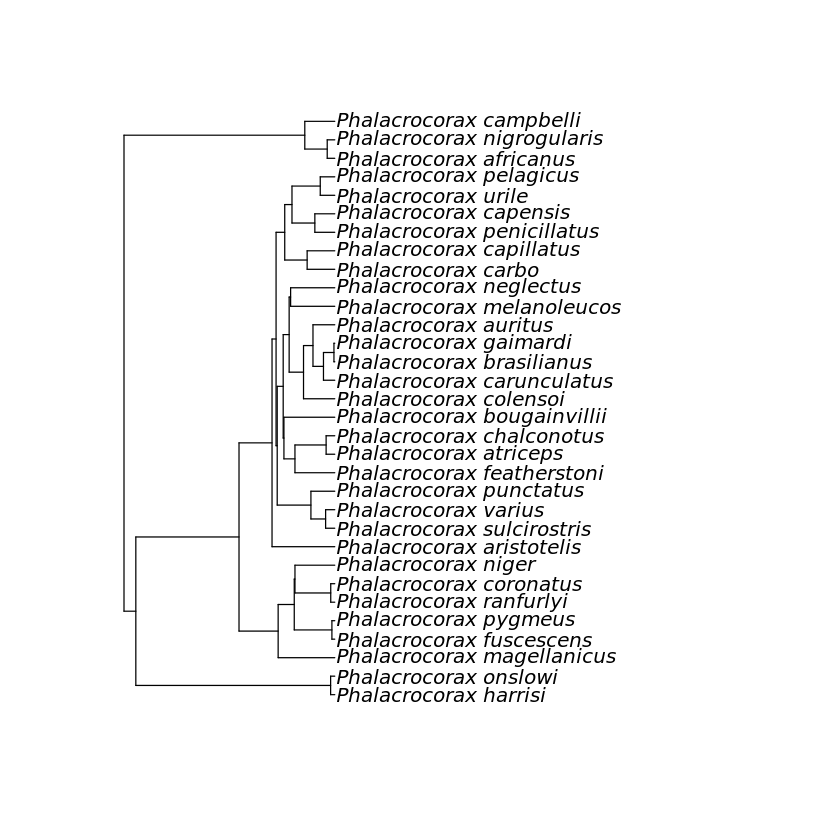

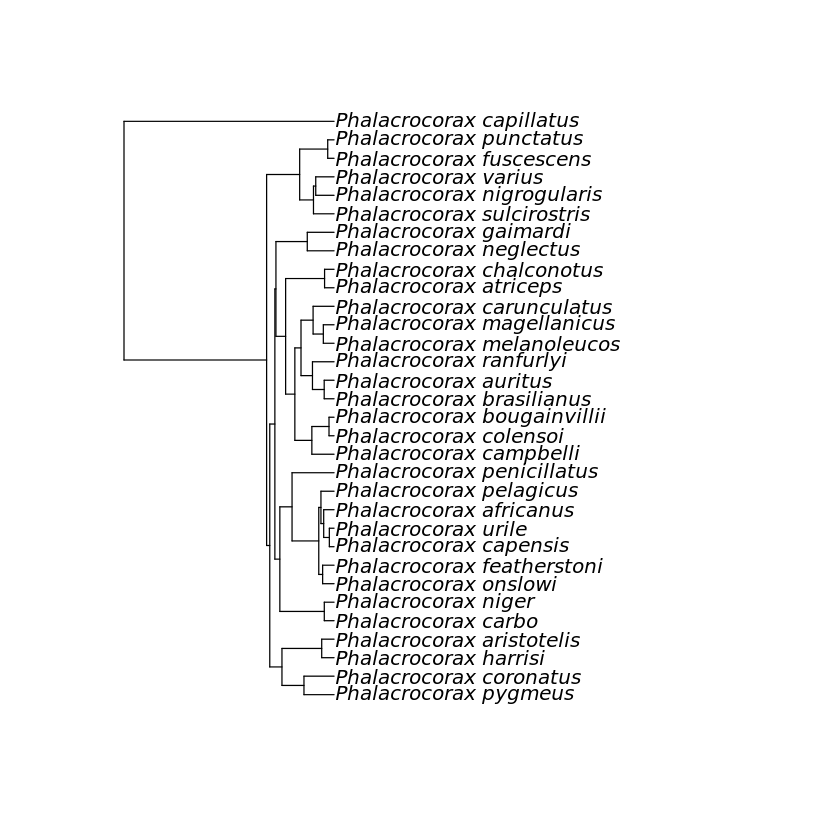

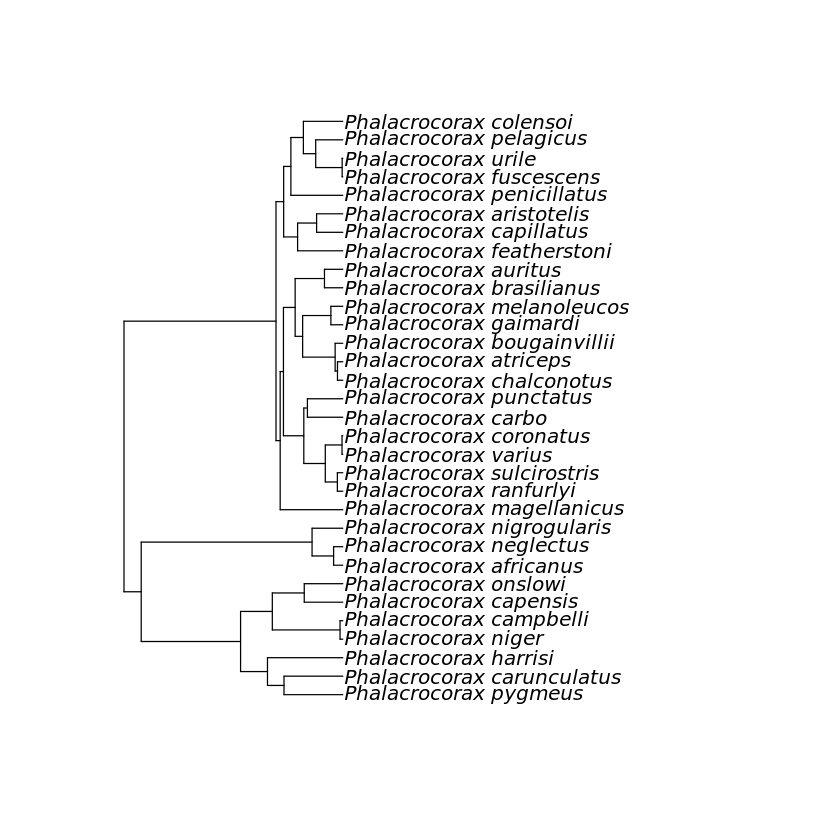

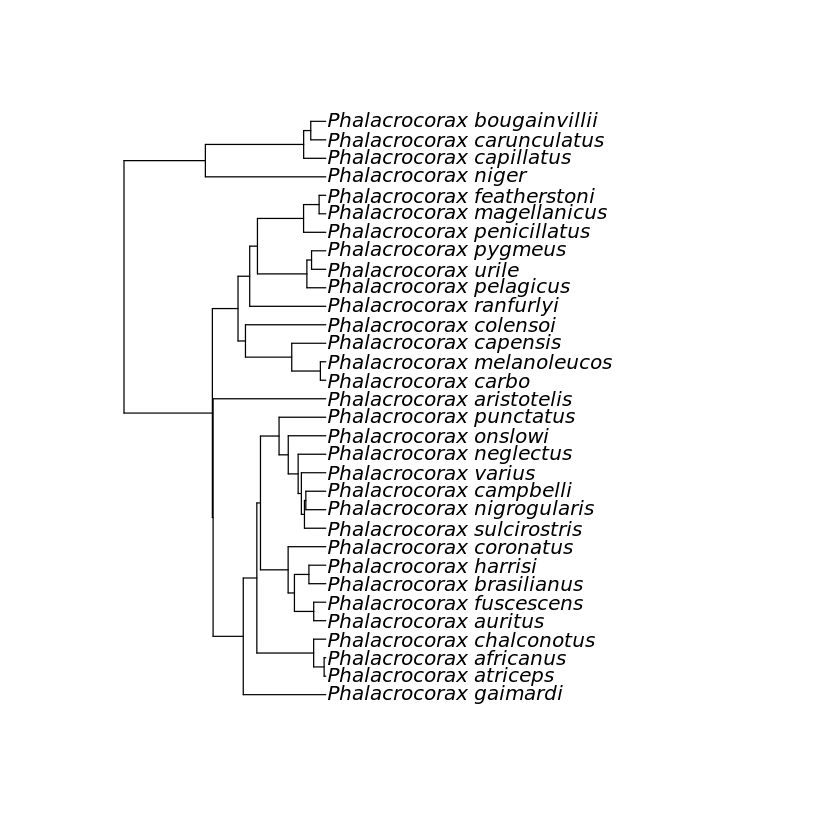

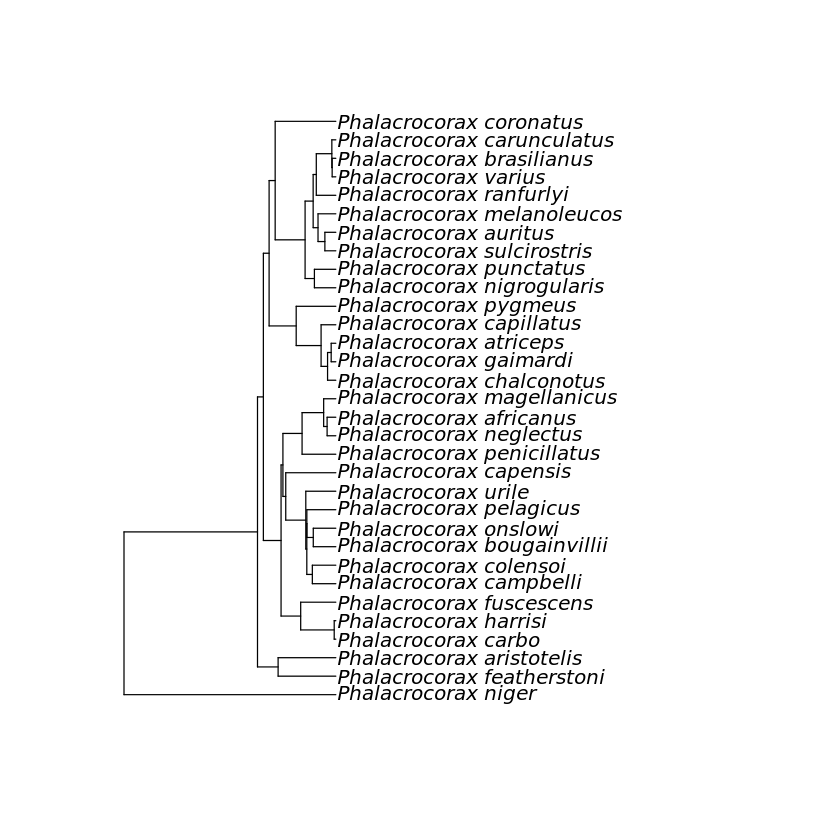

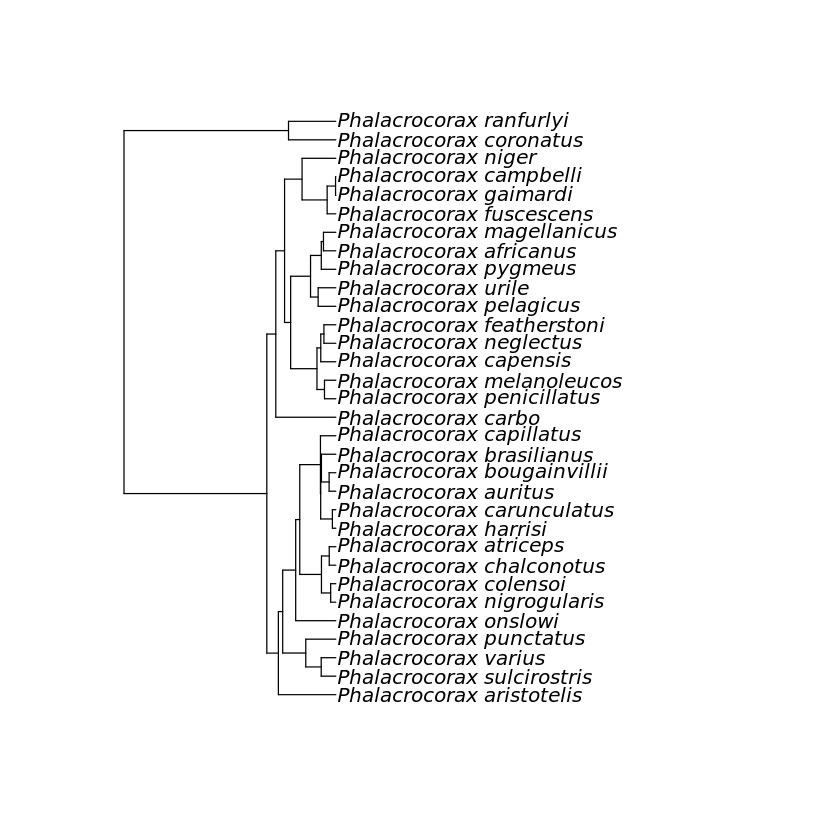

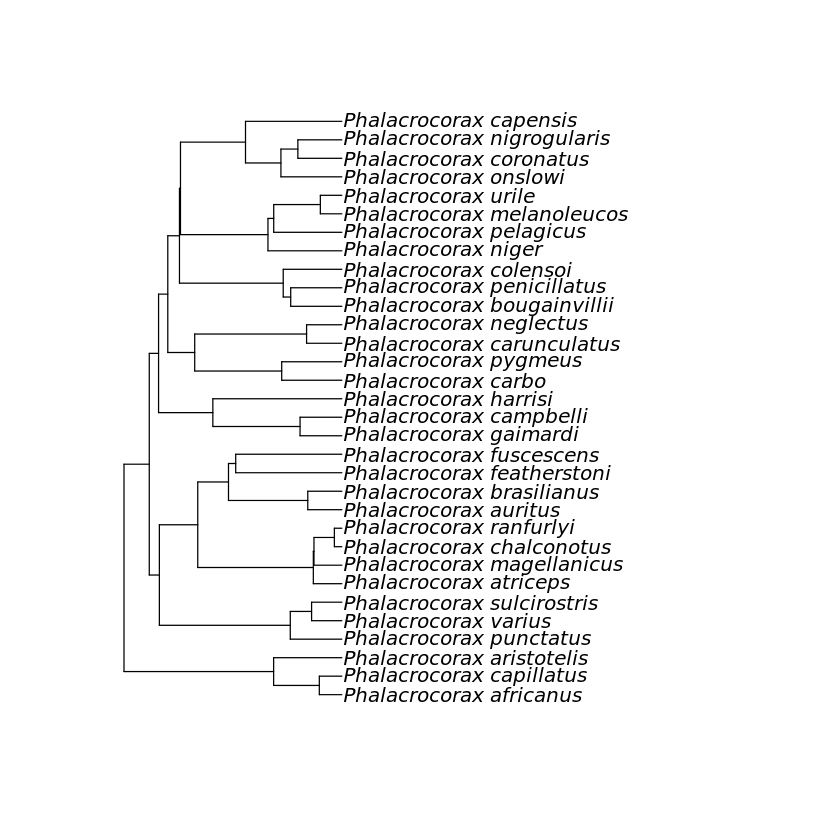

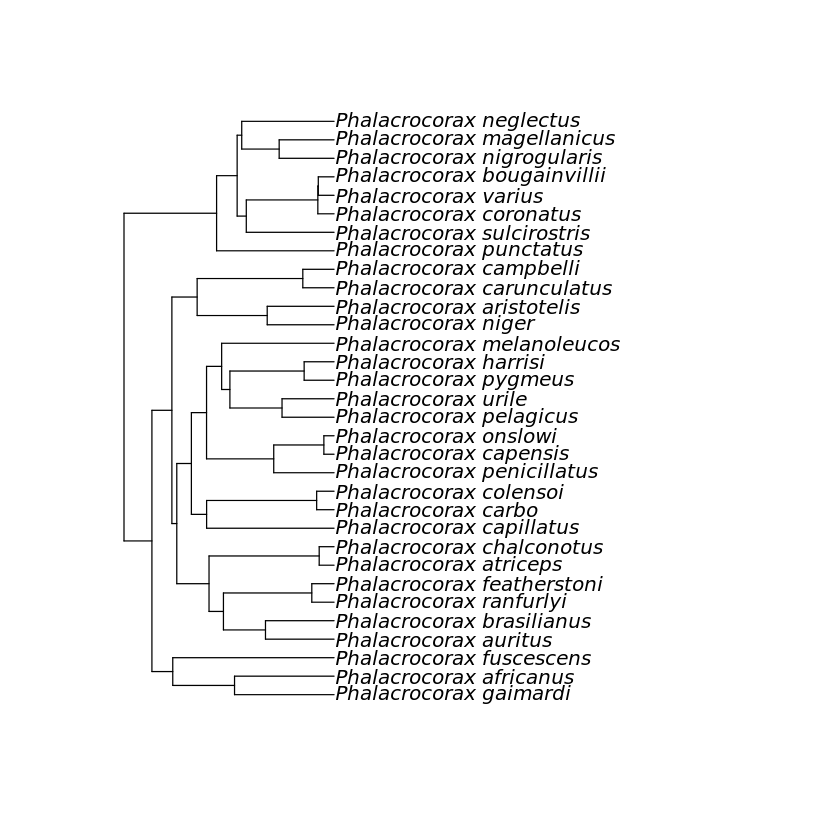

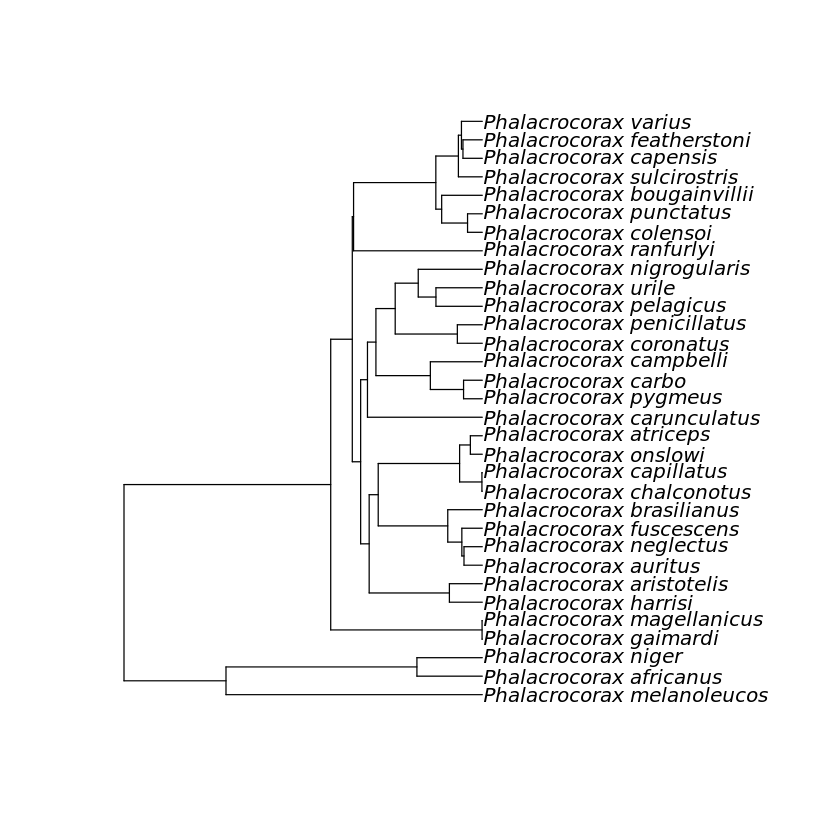

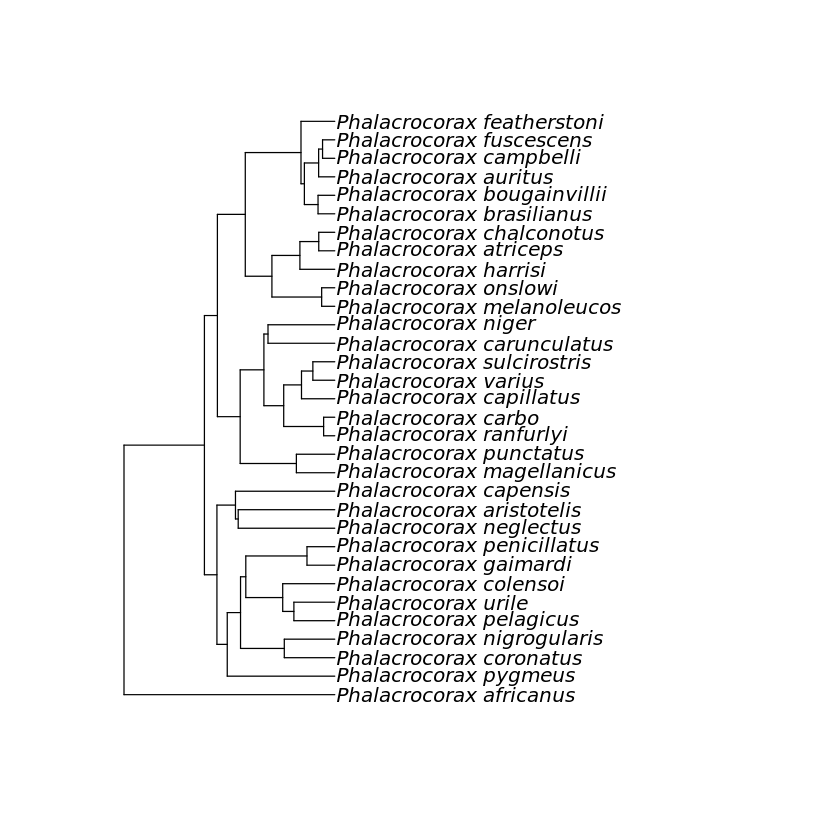

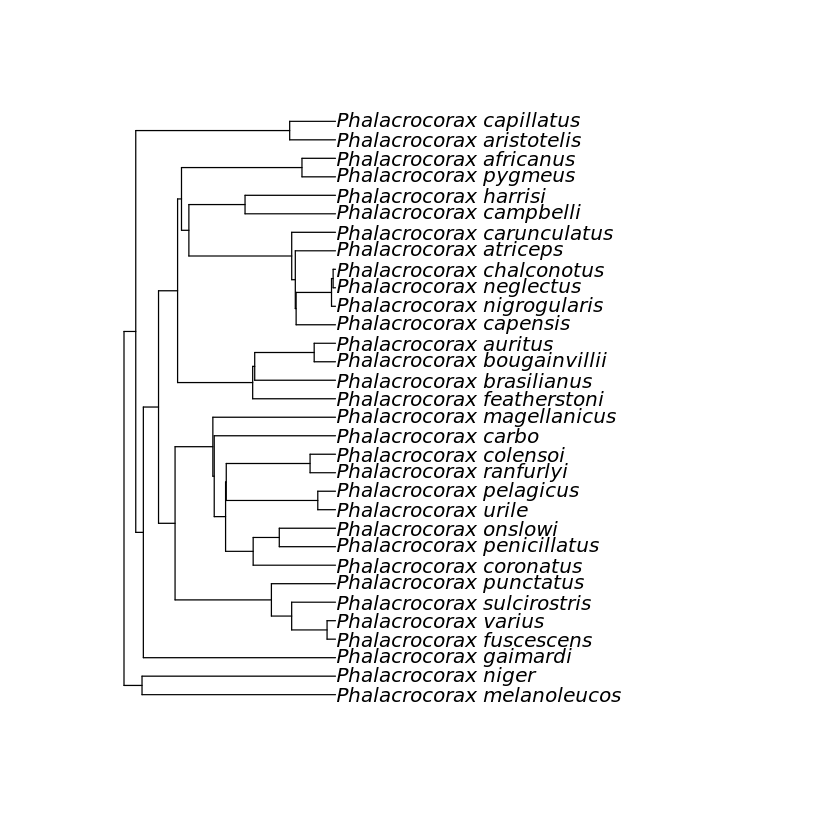

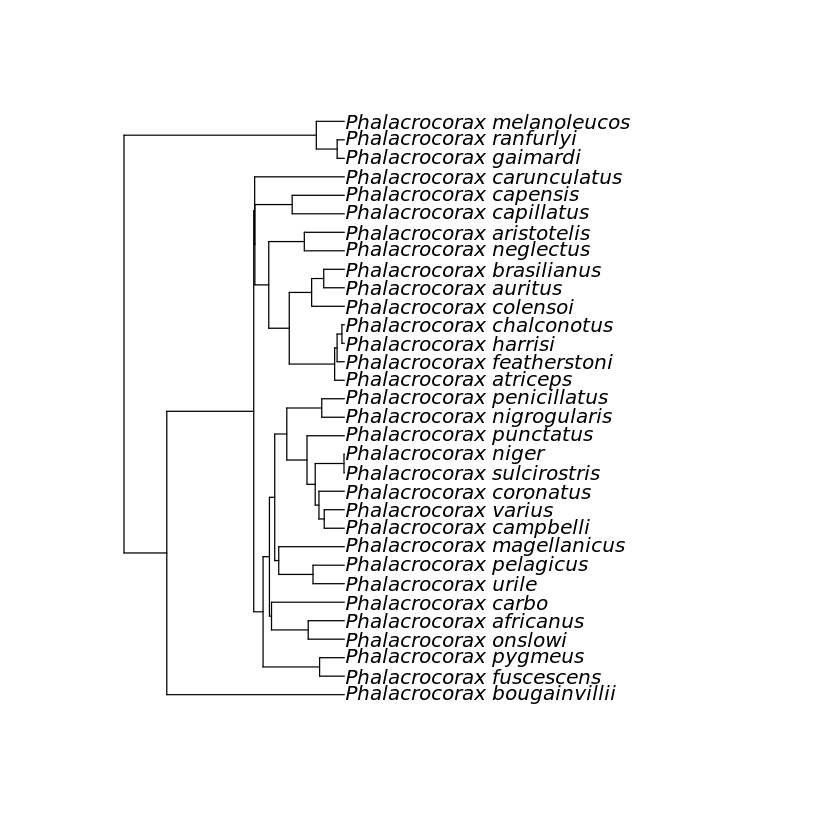

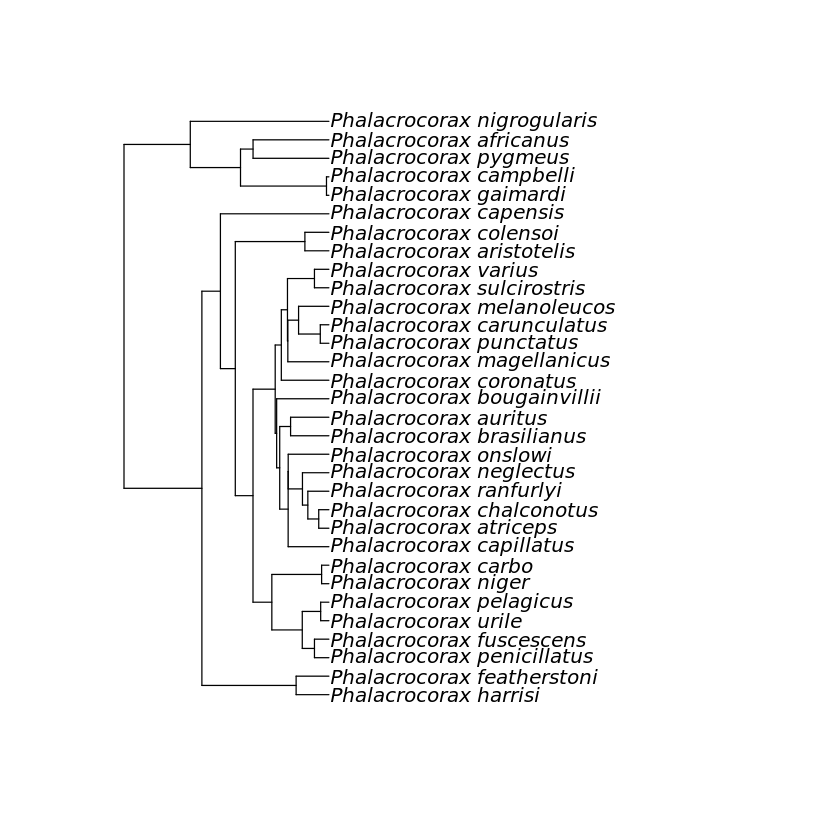

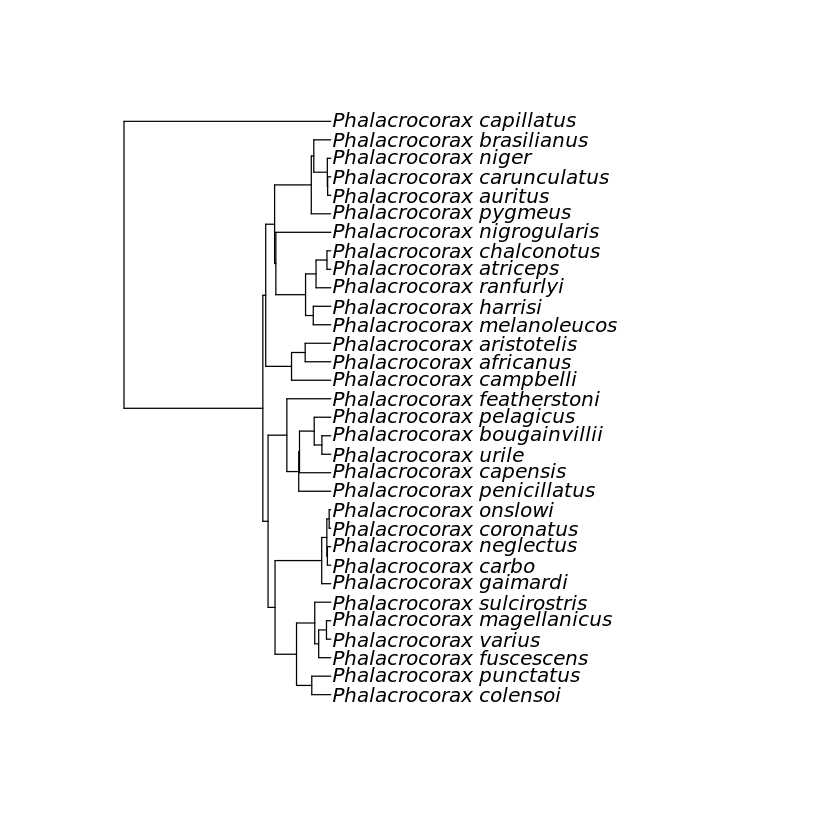

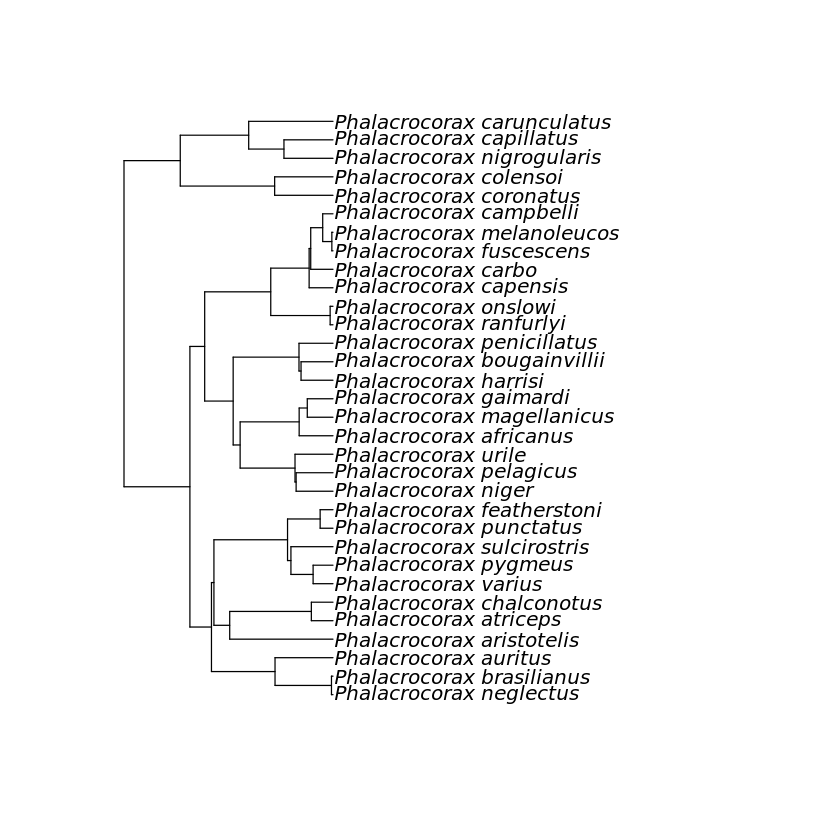

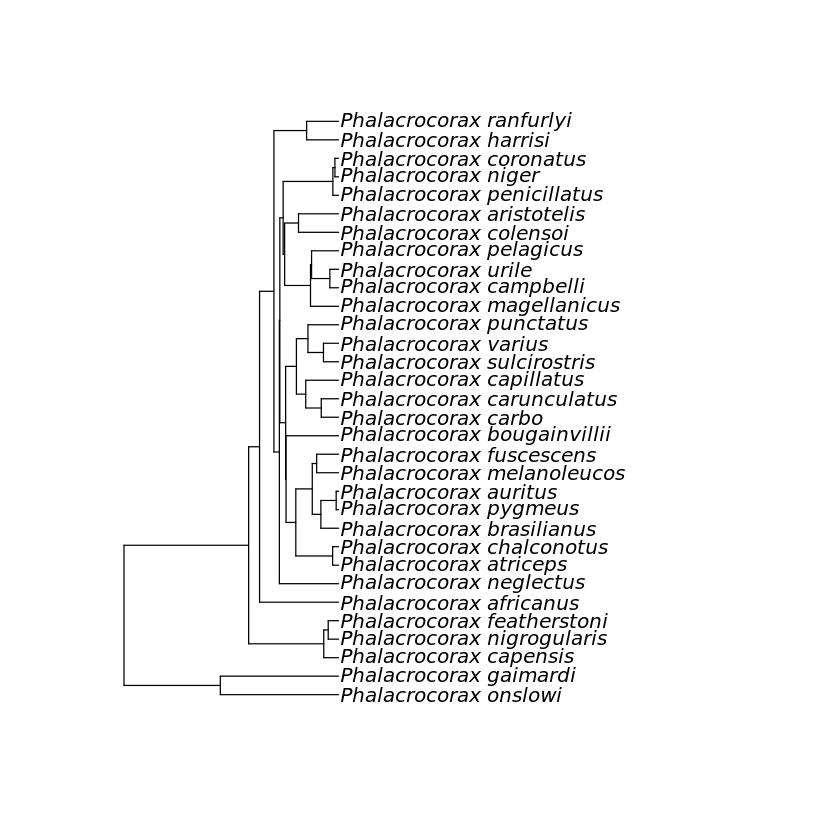

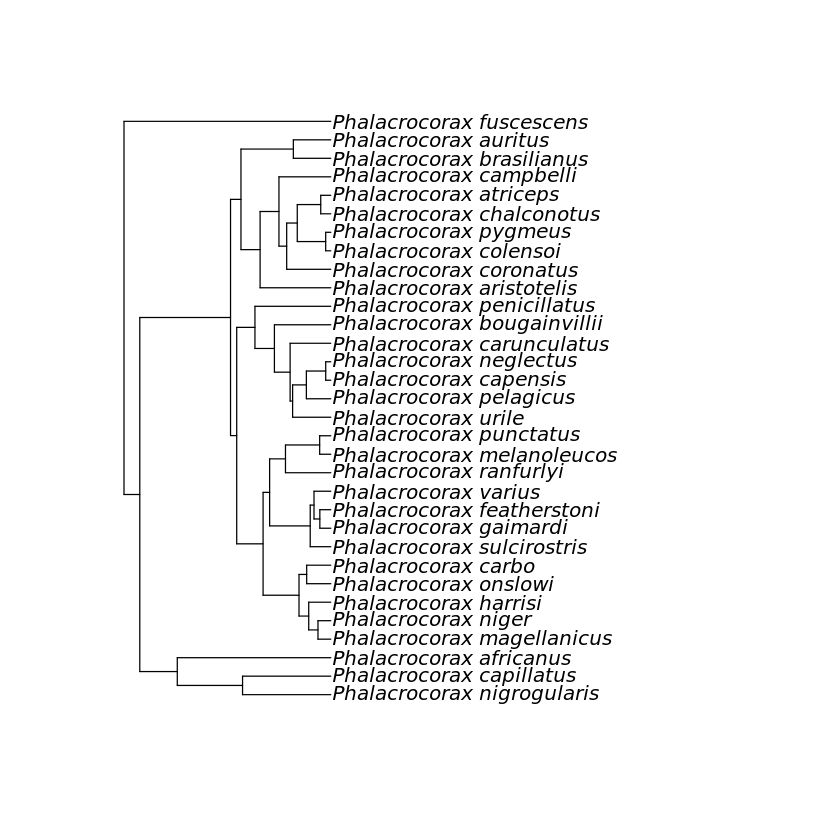

In [27]:
tree<-read.nexus("Cormorant_tree.nex") # loads the Cormorant tree
plot(tree) #have a look at the various trees <PRESS ESCAPE> when done.

In [1]:
# Load the Cormorant latitudinal and bodymass data
cormorant_data<-read.csv("Cormorant_data.csv",h=T) 

# Check it's been imported
str(cormorant_data)
head(cormorant_data)

'data.frame':	32 obs. of  4 variables:
 $ Birdtree.Name: Factor w/ 32 levels "Phalacrocorax_africanus",..: 20 1 14 22 28 26 18 21 16 6 ...
 $ English.Name : Factor w/ 32 levels "Auckland Shag",..: 21 28 11 20 25 6 14 3 4 22 ...
 $ Midpoint.Lat : num  -22.9 -0.38 -29.2 23.72 42.72 ...
 $ Body.Mass    : num  727 545 762 427 676 ...


,Birdtree.Name,English.Name,Midpoint.Lat,Body.Mass
,<fct>,<fct>,<dbl>,<dbl>
1,Phalacrocorax_melanoleucos,Little Pied Cormorant,-22.90,727.36
2,Phalacrocorax_africanus,Reed Cormorant,-0.38,545.00
3,Phalacrocorax_coronatus,Crowned Cormorant,-29.20,762.19
4,Phalacrocorax_niger,Little Cormorant,23.72,427.00
5,Phalacrocorax_pygmeus,Pygmy Cormorant,42.72,675.97
6,Phalacrocorax_penicillatus,Brandt's Cormorant,32.27,2224.24


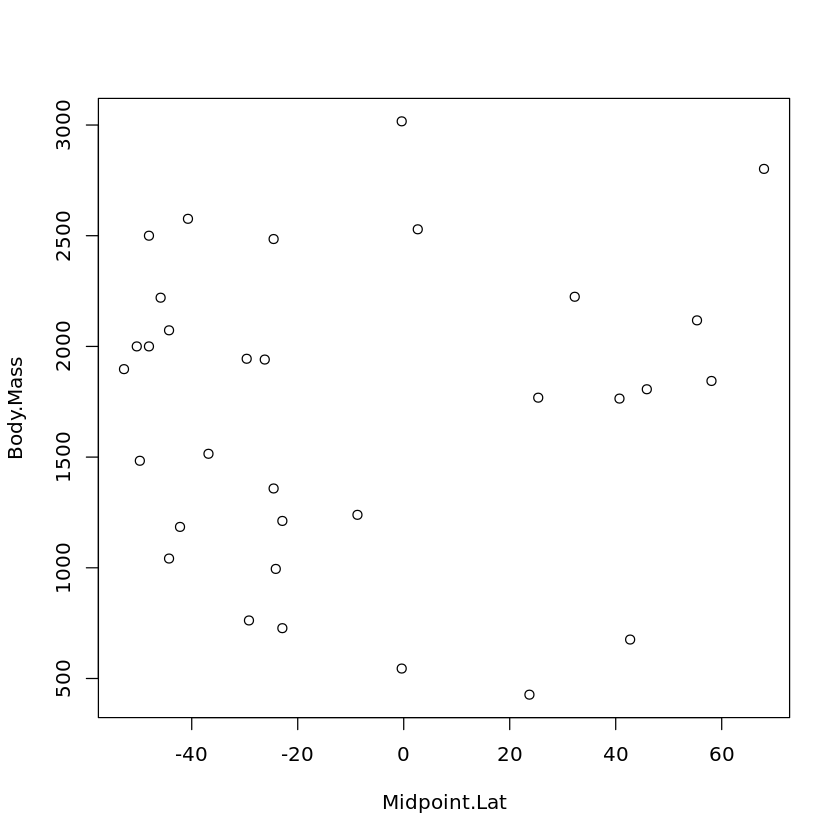

In [2]:
plot(Body.Mass~Midpoint.Lat, cormorant_data) #lets take a look at the data

In [ ]:



#convert latitude to absolute values, to represent distance from the equator
cormorant_data$Midpoint.Lat_Absolute<-abs(cormorant_data$Midpoint.Lat) 

In [ ]:
Alternatively, rather than just plot the midpoint.Lat we can bin the lattitudes first, and visualise the output.

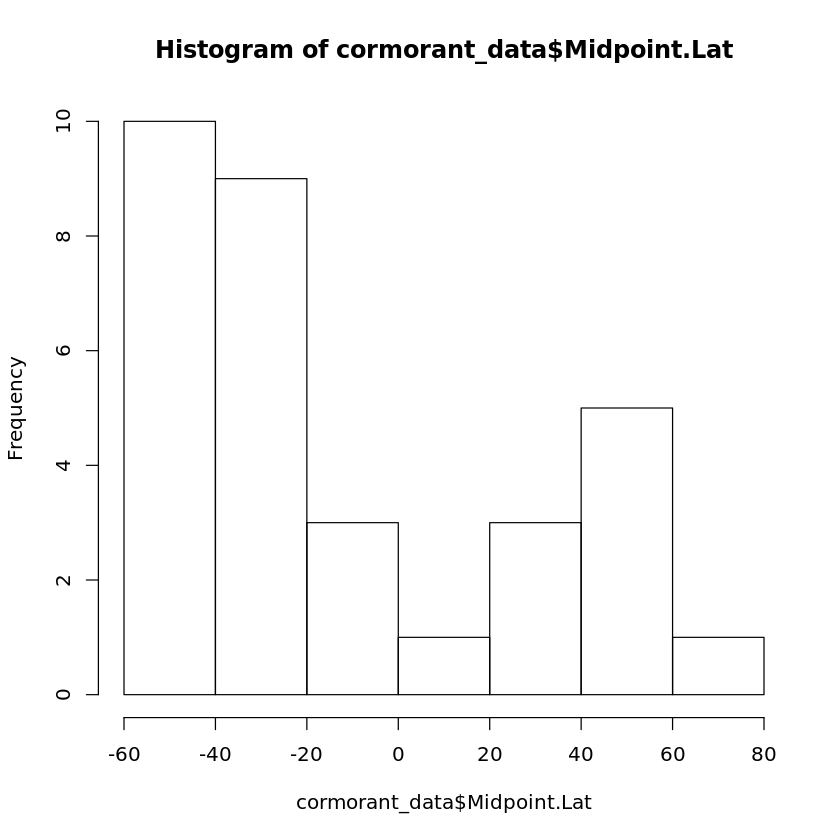

In [4]:
hist(cormorant_data$Midpoint.Lat) 

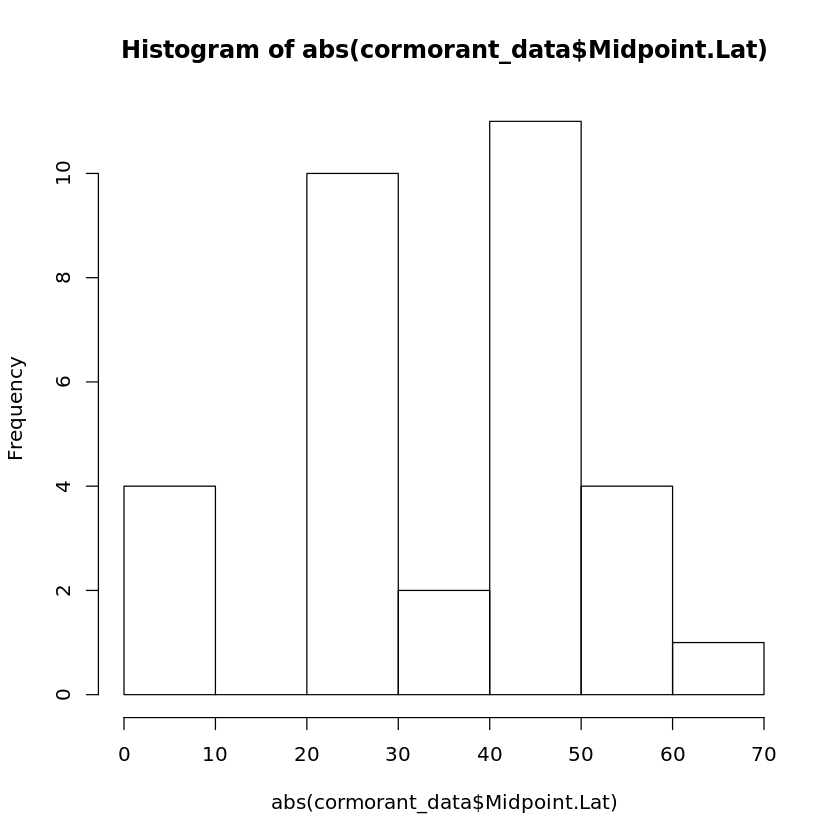

In [13]:
hist(abs(cormorant_data$Midpoint.Lat))

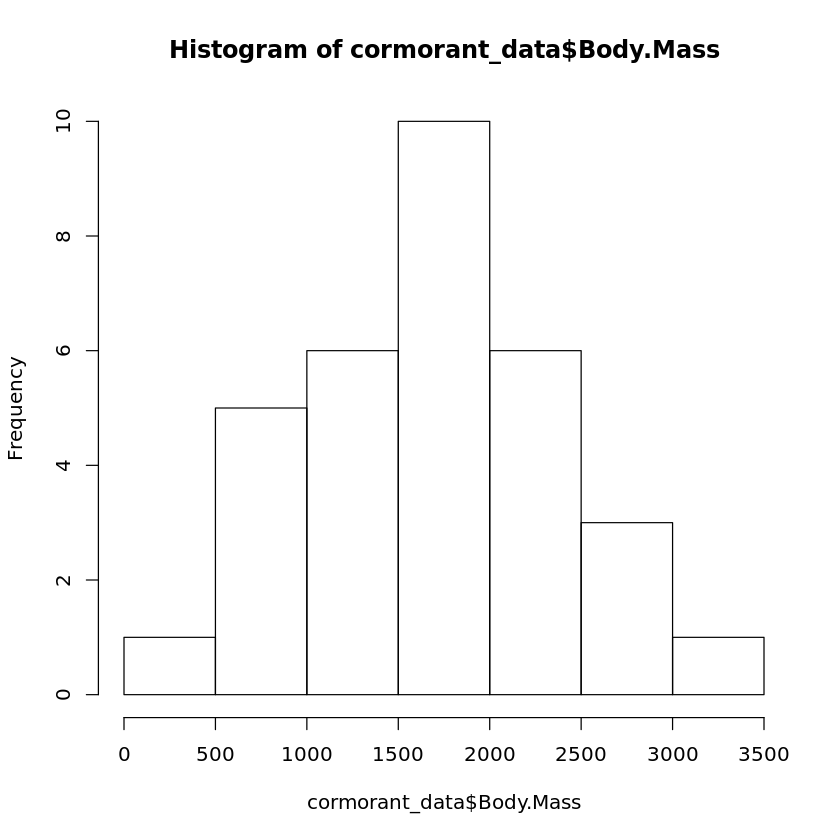

In [14]:
hist(cormorant_data$Body.Mass)